In [9]:
import numpy as np
import pandas as pd
import json
import gensim
import collections
import matplotlib.pyplot as plt
import pprint
import itertools
import seaborn as sns
import networkx as nx
from IPython.display import display_svg
import tqdm
%matplotlib inline

In [10]:
with open("./lt.json", "r") as f:
    raw_lt = json.load(f)

In [11]:
lt_per_cat = {}
for ltid, value in raw_lt.items():
    if value['cat'] not in lt_per_cat:
        lt_per_cat[value['cat']] = [value['lt']]
    else:
        lt_per_cat[value['cat']].append(value['lt'])

In [12]:
def remove_symbols(value):
    return value.replace('-', '').replace('+', '').replace("'",'').replace('>','').replace('<','').replace('=','').replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('**', '').replace(':', '').replace(',', '').replace("_", " ")

def string_to_corpus(lt, max_len=None):
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    if max_len != None:
        split_words = split_words[:max_len] # 前方のみ残す

    return split_words

In [13]:
words_per_cat = dict()
for cat, lts in lt_per_cat.items():
    corpus = []
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
        split_words = [t.lower() for t in split_words if t != '']
        corpus.extend(split_words)
    words_per_cat[cat] = corpus

In [14]:
all_words = list(set([word for cat, words in words_per_cat.items() for word in words]))
word2id = {w:i for i, w in enumerate(all_words)}
id2word = {v:k for k,v in word2id.items()}

corpus = []
for cat, lts in lt_per_cat.items():
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
        split_words = [t.lower() for t in split_words if t != '']
        
        split_words = split_words[:10] # 前方のみ残す
        
        lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
        
        corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])

In [15]:
len(all_words)

1684

In [16]:
# 単語のカウント
word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    print(id2word[wid], '\t', cnt)
    word_cnt[id2word[wid]] = cnt

user 	 544
ui 	 543
mgd 	 505
cfg 	 470
audit 	 466
rpd 	 374
set 	 326
other 	 257
event 	 198
index 	 182
multicast 	 168
broadcast 	 168
protocols 	 139
delete 	 136
to 	 134
on 	 127
bgp 	 123
up 	 110
from 	 107
mpls 	 99
logicalsystems 	 98
/kernel 	 92
address 	 91
lsp 	 89
interfaces 	 87
for 	 87
# 	 73
group 	 72
routinginstances 	 69
evt 	 62
policyoptions 	 61
unit 	 61
login 	 61
init 	 60
family 	 60
updown 	 55
primary 	 54
is 	 52
as 	 49
mtu 	 48
port 	 47
received 	 46
file 	 45
system 	 44
failed 	 44
state 	 43
chassisd 	 42
snmp 	 42
routingoptions 	 42
error 	 42
change 	 42
alarm 	 41
policystatement 	 41
trap 	 41
sent 	 41
task 	 41
pic 	 41
read 	 40
of 	 40
interface 	 40
mcsn 	 39
add 	 37
pointtopoint 	 37
term 	 36
notification 	 36
peer 	 35
area 	 34
class 	 34
xntpd 	 34
code 	 33
down 	 32
message 	 32
pid 	 31
host 	 31
changed 	 31
not 	 31
cmd 	 31
secondary 	 30
neighbor 	 30
luchip 	 30
link 	 30
client 	 30
no 	 29
status 	 29
deactivate 	 28
con

In [9]:
# LTレベルの共起
cor_df = pd.DataFrame(index=np.arange(len(word2id)), columns=np.arange(len(word2id)), dtype=int)
cor_df = cor_df.fillna(0)

for s in corpus:
    for a,b in itertools.combinations(s, 2):
        ida = int(a[0])
        idb = int(b[0])
        cor_df[ida][idb] += 1
        cor_df[idb][ida] += 1

cor_list = []
for a,b in itertools.combinations(np.arange(len(word2id)), 2):
    if cor_df[a][b] != 0 :
        cor_list.append([(a, b) , cor_df[a][b]])
        
for i in tqdm.tqdm(sorted(cor_list, key=lambda x:x[1], reverse=True)):
    a,b = i[0]
    print(id2word[a], id2word[b], i[1])
    print("\t simpson:", i[1]/min(word_cnt[id2word[a]], word_cnt[id2word[b]]))
    print("\t jaccard:", i[1]/(word_cnt[id2word[a]] + word_cnt[id2word[b]] - i[1]))
    print()

KeyboardInterrupt: 

In [ ]:
G = nx.DiGraph()
nx.set_node_attributes

for i in sorted(cor_list, key=lambda x:x[1], reverse=True):
    if i[1] > 9: # 共起が10回以上
        a,b = i[0]
        simpson = i[1]/min(word_cnt[id2word[a]], word_cnt[id2word[b]])
        jaccard = i[1]/(word_cnt[id2word[a]] + word_cnt[id2word[b]] - i[1])
        
        print(simpson)
        if simpson > 0.7:
            if a not in G.nodes:
                G.add_node(id2word[a])

            if b not in G.nodes:
                G.add_node(id2word[b])

            src = id2word[a] if np.argmin([word_cnt[id2word[a]], word_cnt[id2word[b]]]) == 0 else id2word[b]
            dst = id2word[a] if src == id2word[b] else id2word[b]
            G.add_edge(src, dst, weight=jaccard)

In [ ]:
json_data = nx.node_link_data(G)
f = open("nx.json", "w")
json.dump(json_data, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
f.close()

In [ ]:
plt.figure(figsize=(13, 13))
nx.draw_networkx(G, pos=nx.shell_layout(G))
plt.show()

## LDA

In [17]:
for cat, lts in lt_per_cat.items():
    print(cat)

system(cron)
network(lacp)
service(ntp)
monitor(syslog)
network(mtu)
mgmt(login)
system(ui)
mgmt(command)
mgmt(ssh)
network(l2)
system(unix)
network(storm)
system(pic)
network(pfe)
system(ppe)
mgmt(pam)
mgmt(su)
egp(bgp)
network(mld)
system(fpc)
network(arp)
interface(port)
mgmt(config)
interface(agg)
monitor(snmp)
interface(if_event)
interface(vlan)
mgmt(enable)
vpn(mpls)
network(stp)
igp(ospf)
network(rsvp)
vpn(l2vc)
vpn(vpls)
network(tcp)
system(fan)
mgmt(ftp)
network(sfp)
system(power)
system(system_conf)
network(socket)
system(tnp)
system(alarm)
system(gres)
network(pim)
egp(msdp)
interface(interface)
system(others)
system(config_apply)
mgmt(config_process)
network(routing)
mgmt(ui_error)
system(None)
system(cos)
system(ppm)
monitor(bfd)
system(lisence)
network(icmp)
system(csu)
system(boot)
system(pci)
interface(inet6)
network(lldp)
network(mcsnoop)


In [18]:
STOP_WORDS = [word2id[i] for i in ['and', 'of', 'from', 'to', 'in', 'on', 'is', 'for']]
# STOP_WORDS = []

In [19]:
tmp = []
eval_corpus = []
eval_corpus_ltids = []

for ltid, i in enumerate(corpus):
    if word2id['ui'] not in [j[0] for j in i]: # uiを弾く(550番)
        i = [j for j in i if j[0] not in STOP_WORDS]
        tmp.append(tuple(sorted(i)))
        eval_corpus.append(i)
        eval_corpus_ltids.append(ltid)
    
set_corpus2 = list(set(tmp))

E stepとM step を172回やっている

In [20]:
junos_lda = gensim.models.ldamodel.LdaModel(
                                      corpus=set_corpus2,
                                      chunksize=5,
                                      num_topics=40, 
                                      id2word=id2word, 
                                      minimum_probability=1e-8, 
                                      #gamma_threshold=1e-5,
                                      #eval_every=10,
                                      iterations=100,
#                                       alpha='auto', 
#                                       eta='auto', 
                                      decay=1.0,
                                      passes=1,
                                      per_word_topics=True)

In [21]:
results =  [np.argmax(l) for l in junos_lda.inference(eval_corpus)[0]]

inference_results = {}
for a,b in zip(eval_corpus, results):
    if b in inference_results:
        inference_results[b].append([id2word[c[0]] for c in a])
    else:
        inference_results[b] = [[id2word[c[0]] for c in a]]

In [22]:
inf_topic_words = {}
for topic in range(junos_lda.num_topics):
    print(topic, [id2word[i[0]] for i in junos_lda.get_topic_terms(topic)])
    inf_topic_words[topic] = [id2word[i[0]] for i in junos_lda.get_topic_terms(topic)]

0 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
1 ['tnp.bootpd', 'boot', 'su', 'bootpd', 'dyn', 'bootstring', 'onboard', 'diagnostic', 'contains', 'information.']
2 ['the', 'found', 'detected', 'lacp', 'switch', 'ethernet', 'port.', 'timer', 'bcm5389', 'processed']
3 ['address', '#', 'duplicate', 'attempt', 'base', 'ip', 'ipv6', 'dad', 'ichip', 'ia']
4 ['state', 'ifl', 'bundle', 'complete', 'l2cp', 'initializing', 'initialized', 'vc', 'machines', 'module']
5 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
6 ['chassisd', 'fpc', 'ready', 'cm', 'sending', 'offline', 'gres', 'chassis', 'speed', 'cmsfpc']
7 ['register', 'id', 'mqchip', 'buffer', 'bist', 'hostif', 'mode', 'client', 'rt', 'setting']
8 ['alarm', 'failed', 'craftd', 're', 'minor', 'pem', 'fan', 'absent', 'backup', 'feed']
9 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
10 ['queue', 'create', 'ifdev',

### eval

- 外れたやつについて，調査

In [23]:
for a,b in lt_per_cat.items():
    print(a, len(b))

system(cron) 8
network(lacp) 6
service(ntp) 35
monitor(syslog) 4
network(mtu) 26
mgmt(login) 38
system(ui) 41
mgmt(command) 24
mgmt(ssh) 18
network(l2) 15
system(unix) 35
network(storm) 6
system(pic) 35
network(pfe) 47
system(ppe) 6
mgmt(pam) 3
mgmt(su) 4
egp(bgp) 56
network(mld) 1
system(fpc) 76
network(arp) 6
interface(port) 10
mgmt(config) 491
interface(agg) 36
monitor(snmp) 80
interface(if_event) 133
interface(vlan) 6
mgmt(enable) 2
vpn(mpls) 85
network(stp) 12
igp(ospf) 15
network(rsvp) 14
vpn(l2vc) 2
vpn(vpls) 2
network(tcp) 4
system(fan) 2
mgmt(ftp) 4
network(sfp) 9
system(power) 8
system(system_conf) 1
network(socket) 6
system(tnp) 6
system(alarm) 45
system(gres) 7
network(pim) 4
egp(msdp) 10
interface(interface) 5
system(others) 6
system(config_apply) 2
mgmt(config_process) 1
network(routing) 4
mgmt(ui_error) 5
system(None) 228
system(cos) 10
system(ppm) 3
monitor(bfd) 3
system(lisence) 4
network(icmp) 2
system(csu) 6
system(boot) 4
system(pci) 17
interface(inet6) 1
network(ll

In [24]:
## show results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic, ",", lt)

system(cron)
	 9 , /usr/sbin/cron[**]: (root) CMD (newsyslog)
	 9 , /usr/sbin/cron[**]: (**) CMD (adjkerntz -a)
	 9 , /usr/sbin/cron[**]: (**) CMD (/usr/sbin/check-support -l)
	 9 , ** /usr/sbin/cron[**]: (**) CMD (newsyslog)
	 9 , ** /usr/sbin/cron[**]: (**) CMD (adjkerntz -a)
	 9 , ** /usr/sbin/cron[**]: (**) CMD (/usr/sbin/check-support -l)
	 9 , /usr/sbin/cron[**]: (root) CMD ( /usr/libexec/atrun)
	 9 , /usr/sbin/cron[**]: (*system*) RELOAD (/etc/crontab)
network(lacp)
	 2 , mib2d[**]: lacp info not found for ifl:**
	 2 , mib2d[**]: cleared lacp info not found for ifl:**
	 2 , ifinfo: lacp info not found for ifl:**
	 2 , ifinfo: cleared lacp info not found for ifl:**
	 33 , /kernel: KERN_LACP_INTF_STATE_CHANGE: lacp_update_state_userspace: new state is ** cifd **
	 2 , lacpd[**]: LACPD_TIMEOUT: **: lacp current while timer expired current Receive State: CURRENT
service(ntp)
	 38 , xntpd[**]: NTP Server Unreachable
	 30 , xntpd[**]: kernel time sync enabled **
	 38 , xntpd[**]: sync

	 36 , file[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command '**'
	 36 , file[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command 'load-configuration rollback="**" '
	 36 , file[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command 'load-configuration format="xml" action="**" '
	 36 , mgd[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command 'request-package-validate operation=validate package-name=/var/tmp/mchassis-install.tgz **'
	 36 , mgd[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command 'request-package-validate package-name=/var/tmp/mchassis-install.tgz **'
	 36 , mgd[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command 'request-package-add operation=update no-validate package-name=/var/tmp/mchassis-install.tgz **'
mgmt(ssh)
	 20 , sshd[**]: Accepted password for ** from ** port ** **
	 25 , sshd[**]: Received disconnect from **: **: disconnected by user
	 30 , 

	 27 , rpd[**]: bgp_read_v4_message:**: NOTIFICATION received from ** (** AS **): code ** (Hold Timer Expired Error), socket buffer sndcc: ** rcvcc: ** TCP state: **, snd_una: ** snd_nxt: ** snd_wnd: ** rcv_nxt: ** rcv_adv: **, hold timer **
	 20 , rpd[**]: bgp_process_caps: mismatch NLRI with ** (** AS **): peer: <** **>(**) us: <**>(**)
	 22 , rpd[**]: bgp_read_message:**: NOTIFICATION sent to **+** (proto): code ** (Message Header Error) subcode ** (bad length) value **
	 27 , **: rpd[**]: bgp_hold_timeout:**: NOTIFICATION sent to ** (** AS **): code ** (Hold Timer Expired Error), Reason: holdtime expired for ** (** AS **), socket buffer sndcc: ** rcvcc: ** TCP state: **, snd_una: ** snd_nxt: ** snd_wnd: ** rcv_nxt: ** rcv_adv: **, hold timer **
	 27 , **:rpd[**]: RPD_BGP_NEIGHBOR_STATE_CHANGED: BGP peer ** (** AS **) changed state from ** to ** (event **)
	 27 , **: rpd[**]: bgp_read_v4_message:**: NOTIFICATION received from ** (** AS **): code ** (Hold Timer Expired Error), socket

	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [interfaces **] "**
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces **] <unconfigured> -> "**"
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [logical-systems ** interfaces ** unit **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [logical-systems ** routing-instances **]
	 32 , **:rpd[**]: RPD_TASK_REINIT: Reinitializing
	 32 , **: rpd[**]: task_reconfigure reinitializing done
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [chassis redundancy **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [routing-options] "**
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' activate: [chassis redundancy **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' activate: [routing-options] "**
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [logical-systems ** interfaces ** unit **]
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [logical-systems ** interfaces ** unit ** vlan-id] <unconfigured> -> "**"
	 5 , mgd[

	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [forwarding-options port-mirroring input run-length] <unconfigured> -> "**"
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [forwarding-options port-mirroring family ** output interface **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [forwarding-options port-mirroring family ** output interface ** next-hop **]
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [forwarding-options port-mirroring family ** output] <**> -> "**"
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces ** unit ** family ** address ** arp ** mac] <unconfigured> -> "**"
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [forwarding-options sampling instance ** input rate] "** -> "**"
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [forwarding-options sampling instance ** input run-length] "** -> "**"
	 20 , mgd[**]: UI_CFG_AUDIT_NEW: User '**' rename: [forwarding-options sampling instance ** family ** output flow-server **] to "**"
	 5 , mgd[**]: UI_CFG_AUD

	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [logical-systems ** routing-instances ** routing-options static route **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' activate: [logical-systems ** routing-instances ** routing-options static route **]
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [policy-options as-path **] <unconfigured> -> "** ** **"
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [policy-options policy-statement ** term ** from as-path **]
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [system login user ** uid] <unconfigured> -> "**"
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [firewall family ** filter ** term ** from destination-port] "**
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [firewall family ** filter ** term ** from port **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [firewall family ** filter router-protection term ** from **]
	 5 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [firewall family ** filter router-prot

	 17 , mcsn[**]: KRT Ifstate: iff message for ** without mesh-group tlv
	 28 , [**]: EVT ** ** E3 MAC 20120010 0800:000000000000 Port(**) detached from Channel Group(**) - Port down.
	 17 , /kernel: ** iff_ifarequest (**) addr: ** err **
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces ** aggregated-ether-options lacp] <unconfigured> -> "**"
	 0 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces ** aggregated-ether-options lacp periodic] <unconfigured> -> "**"
	 28 , [**]: EVT ** ** ** MAC ** **:** Channel Group(**) is Down - All port detached.
	 28 , [**]: EVT ** ** ** MAC ** **:** Port(**) removed from Channel Group(**).
	 28 , [**]: EVT ** ** ** MAC ** **:** Port(**) ** from Channel Group(**) - Denied by the LACP partner.
	 30 , ** dcd[**]: ** : Warning: aggregated-ether-options link-speed no kernel value! default to **
	 30 , ** dcd[**]: ** : aggregated-ether-options link-speed set to kernel value of **
	 39 , ** /kernel: ae_link_op: link ** (lidx=**) detached from 

	 29 , rpd[**]: EVENT <Flags> ** index ** <Broadcast Multicast> address #** **
	 29 , rpd[**]: EVENT Add ** index ** ** -> ** <Broadcast Multicast>
	 29 , **: rpd[**]: EVENT <Add MTU Encapsulation> index ** <Broadcast Multicast> address #** **
	 29 , mcsn[**]: EVENT <Add MTU Encapsulation> index ** <Broadcast Multicast> address #** **
	 29 , rpd[**]: EVENT <Add MTU Encapsulation> index ** <Broadcast Multicast> address #** **
	 29 , rpd[**]: EVENT <Address> ** index ** <Broadcast Multicast> address #** **
	 29 , **: rpd[**]: EVENT <Add> ** index ** <Up Broadcast Multicast> address #** **
	 29 , **: rpd[**]: EVENT <Instance> ** index ** <Up Broadcast Multicast> address #** **
	 29 , **: rpd[**]: EVENT Add ** index ** <Up Broadcast Multicast Localup>
	 29 , rpd[**]: EVENT <Delete> ** index ** <Broadcast Multicast> address #** **
	 29 , **: rpd[**]: EVENT Delete UpDown ** index ** <Broadcast Multicast Localup>
	 29 , **: rpd[**]: EVENT <Delete UpDown> ** index ** <Broadcast Multicast> addr

	 11 , **:rpd[**]: RPD_OSPF_NBRUP: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 2WayRcvd (event reason: initial DBD packet was received)
	 11 , rpd[**]: RPD_OSPF_NBRUP: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 2WayRcvd (event reason: initial DBD packet was received)
	 11 , rpd[**]: RPD_OSPF_NBRDOWN: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 1WayRcvd (event reason: neighbor is in one-way mode)
	 11 , **:rpd[**]: RPD_OSPF_NBRDOWN: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 1WayRcvd (event reason: neighbor is in one-way mode)
network(rsvp)
	 11 , **:rpd[**]: RPD_RSVP_NBRDOWN: RSVP neighbor ** down on interface **, triggered by IGP neighbor down event
	 11 , **:rpd[**]: RPD_RSVP_NBRUP: RSVP neighbor ** up on interface **
	 8 , **:rpd[**]: RPD_RSVP_BACKUP_DOWN: Backup for protecting LSP ** down, using bypass Bypass->**, reason: Deleting protected LSP
	 27 , **:rpd[**]

	 30 , ksyncd[**]: ksyncd_select_control_plane_proto: rhost_sysctlbyname_get: No such file or directory
	 25 , clksyncd[**]: System has older ACBC FPGA image. Clocking is not supported on it!
	 4 , init: Starting of initial processes complete
	 7 , appidd[**]: ai_cache_corruption_check_and_recovery: ai_cache corruption, try recovery...
	 16 , cmtfpc_max6697_init: OK
	 16 , cmtfpc_max6657_init: OK
	 3 , CMLC: Attempt **, proto(**) address **
	 10 , v_queue_create(qsize: **, max_buckets: **, default_max_tokens: **)
	 10 , v_queue_create: allocate vq, size: **
	 10 , v_queue_create: allocate vq_tb_list, size: **
	 10 , v_queue_create: allocate vq_entry_pool, size: **
	 16 , Initiated pfeman_service_thread
	 10 , Svc Thread: Create TCP(**) socket
	 15 , CLKSYNC: Established connection to Master, **
	 15 , CLKSYNC: master RE connection made
	 15 , L2ALM: Established connection to Master, **
	 15 , L2ALM master RE connection made
	 5 , MPC: Reset reason (**): Power on
	 34 , cmtfpc_create_as

	 20 , **: rpd[**]: task_process_events: no write/connect method for **+** socket **
	 39 , chas[**]: phy_qt2025_link_down_workaround: Resetting port ** for phy workaround
	 28 , /kernel: PCF8584(WR): target ack failure on byte **
	 28 , /kernel: PCF8584(WR): (**=**, group=**, device=**)
	 37 , [**]: RSP ** ** **(**):interface : Invalid line type.[**]
	 19 , mcsn[**]: krt_snooping_decode_bd_msg: bd **+** - op ** id ** rtb id **
	 19 , mcsn[**]: krt_snooping_decode_bd_msg: rtbid - **, bd - ** id ** CHANGE ignored
	 19 , mcsn[**]: krt_decode_iflogical: ** associated with l2 instance with table id **
	 32 , rpd[**]: task accounting **
	 15 , /kernel: pmap_helper loaded (interface version **, syscall **)
	 5 , chas[**]: update_mb_pic_port_map: debug: pic slot = **, port = **, port_status = **
	 21 , chas[**]: cm_pic_port_map_info: Port Map Info for **:** sent
	 21 , chas[**]: XCVR: Freeing itable entry for xcvr index: ** port: **
	 39 , chas[**]: ifcm_ifd_remove_vector: ifd ** is_vcp ** pe

In [25]:
## show detailed results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        print(lt)
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic)
        print("\t", inf_topic_words[inf_topic])
        print("\t"+"-"*10)
        for w in word_topic_dist:
            print("\t", id2word[w[0]], w[1])
        print()

system(cron)
/usr/sbin/cron[**]: (root) CMD (newsyslog)
	 9
	 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
	----------
	 /usr/sbin/cron [(9, 1.0)]
	 root [(9, 1.0)]
	 cmd [(9, 1.0)]
	 newsyslog [(9, 0.99999994)]

/usr/sbin/cron[**]: (**) CMD (adjkerntz -a)
	 9
	 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
	----------
	 /usr/sbin/cron [(9, 0.99999994)]
	 cmd [(9, 0.99999994)]
	 adjkerntz [(9, 1.0)]
	 a [(9, 1.0)]

/usr/sbin/cron[**]: (**) CMD (/usr/sbin/check-support -l)
	 9
	 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
	----------
	 /usr/sbin/cron [(9, 1.0)]
	 cmd [(9, 1.0)]
	 /usr/sbin/checksupport [(9, 0.99999994)]
	 l [(9, 0.99999994)]

** /usr/sbin/cron[**]: (**) CMD (newsyslog)
	 9
	 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
	----------
	 /usr/sbin/cron [(9, 1.0)]
	 cmd [(9, 1.0)]
	 news

	 16
	 ['message', 'pfe', 'pfeman', 'request', 'cmtfpc', 'last', 'retries', 'stream', 'normal', 'resync']
	----------
	 last [(16, 0.99999994)]
	 message [(16, 1.0)]
	 repeated [(16, 1.0)]
	 times [(16, 1.0)]

SYSLOG: ** messages lost, message queue overflowed.
	 10
	 ['queue', 'create', 'ifdev', 'size', 'all', 'v', 'created', 'detach', 'vq', 'allocate']
	----------
	 syslog [(10, 0.9966024)]
	 messages [(10, 0.9966024)]
	 lost [(10, 0.9983302)]
	 message [(16, 1.0)]
	 queue [(10, 0.99999994)]
	 overflowed. [(10, 0.9966024)]

Slot **, PIC Slot **) SYSLOG: ** messages lost, message queue overflowed.
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 slot [(5, 2.0)]
	 pic [(5, 1.0)]
	 syslog [(10, 0.9939022)]
	 messages [(10, 0.9939022)]
	 lost [(10, 0.9969989)]
	 message [(16, 1.0)]

** last message repeated ** times
	 16
	 ['message', 'pfe', 'pfeman', 'request', 'cmtfpc', 'last', 'retries', 'stream', 'normal', 'resync']
	---

	 information [(36, 1.0)]
	 user [(36, 1.0)]
	 logged [(36, 0.99999994)]
	 in [(36, 1.0)]

** [**]: EVT ** ** ** ACCESS ** **:** Login ** from ** (**).
	 35
	 ['access', 'incorrect', 'show', 'logout', '.', 'log.', 'run#', '##', 'esc', 'such']
	----------
	 evt [(29, 1.0)]
	 access [(35, 0.99999994)]
	 login [(36, 0.99999994)]
	 from [(29, 0.02459865), (35, 0.8636379), (36, 0.11176352)]
	 . [(35, 1.0)]

login: LOGIN_MALFORMED_USER: Invalid username: empty
	 36
	 ['login', 'user', 'exit', 'password', 'many', 'pam', 'failures', 'authentication', 'logged', 'too']
	----------
	 login [(36, 1.9999999)]
	 malformed [(36, 0.7828337), (37, 0.21179798)]
	 user [(36, 1.0)]
	 invalid [(37, 1.0)]
	 username [(37, 1.0000001)]
	 empty [(20, 1.0)]

login: LOGIN_FAILED: Login ** for user **[[** from host **
	 36
	 ['login', 'user', 'exit', 'password', 'many', 'pam', 'failures', 'authentication', 'logged', 'too']
	----------
	 login [(36, 3.0000002)]
	 failed [(8, 1.0)]
	 for [(8, 0.094733916), (36, 0.9

	 user [(36, 1.0)]
	 class [(13, 1.0)]

** mgd[**]: UI_CHILD_START: Starting child '**'
	 30
	 ['no', 'time', 'dcd', 'kernel', 'warning', 'initial', 'default', 'linkspeed', 'sync', 'aggregatedetheroptions']
	----------
	 mgd [(5, 1.0000001)]
	 ui [(5, 0.0939695), (15, 0.0897772), (16, 0.14434189), (30, 0.6719114)]
	 child [(30, 1.9999933)]
	 start [(16, 0.99991345)]
	 starting [(15, 1.0)]

** mgd[**]: UI_CHILD_STATUS: Cleanup child '**', PID **, status **
	 30
	 ['no', 'time', 'dcd', 'kernel', 'warning', 'initial', 'default', 'linkspeed', 'sync', 'aggregatedetheroptions']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.08384111), (12, 0.09752362), (15, 0.079728894), (30, 0.73890644)]
	 child [(30, 1.9999948)]
	 status [(15, 1.0)]
	 cleanup [(5, 0.08384111), (12, 0.09752362), (15, 0.079728894), (30, 0.73890644)]
	 pid [(12, 0.99999994)]

** mgd[**]: UI_DBASE_LOGIN_EVENT: User '**' entering configuration mode
	 36
	 ['login', 'user', 'exit', 'password', 'many', 'pam', 'failures', 'authenticatio

	 36
	 ['login', 'user', 'exit', 'password', 'many', 'pam', 'failures', 'authentication', 'logged', 'too']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.12473819), (9, 0.18047409), (36, 0.6947877)]
	 junoscript [(5, 0.24947637), (9, 0.36094818), (36, 1.3895754)]
	 cmd [(9, 1.0)]
	 user [(36, 1.0)]
	 used [(5, 0.12473819), (9, 0.18047409), (36, 0.6947877)]

mgd[**]: UI_JUNOSCRIPT_CMD: User '**' used JUNOScript client to run command 'request-package-add operation=update no-validate package-name=/var/tmp/mchassis-install.tgz **'
	 36
	 ['login', 'user', 'exit', 'password', 'many', 'pam', 'failures', 'authentication', 'logged', 'too']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.12467976), (9, 0.18031877), (36, 0.69500136)]
	 junoscript [(5, 0.24935952), (9, 0.36063755), (36, 1.3900027)]
	 cmd [(9, 1.0)]
	 user [(36, 1.0)]
	 used [(5, 0.12467976), (9, 0.18031877), (36, 0.69500136)]

mgmt(ssh)
sshd[**]: Accepted password for ** from ** port ** **
	 20
	 ['configuration', 'vlan', 'process', 'new', 's

	 12
	 ['init', 'sent', 'signal', 'pid', 'terminate', 'pfed', '/kernel', 'watchdog', 'pre', 'termination']
	----------
	 /kernel [(12, 0.99999994)]
	 init [(12, 1.0)]
	 pid [(12, 0.99999994)]
	 terminate [(12, 1.0)]
	 signal [(12, 0.99999994)]
	 sent [(12, 1.0000001)]

/kernel: init: ** (PID **) started
	 12
	 ['init', 'sent', 'signal', 'pid', 'terminate', 'pfed', '/kernel', 'watchdog', 'pre', 'termination']
	----------
	 /kernel [(12, 1.0)]
	 init [(12, 1.0)]
	 pid [(12, 0.99999994)]
	 started [(12, 1.0)]

/kernel: init: ** (PID **) sending signal hup: due to "**": **
	 12
	 ['init', 'sent', 'signal', 'pid', 'terminate', 'pfed', '/kernel', 'watchdog', 'pre', 'termination']
	----------
	 /kernel [(12, 1.0)]
	 init [(12, 1.0)]
	 pid [(12, 1.0)]
	 sending [(6, 1.0)]
	 signal [(12, 1.0)]
	 hup [(12, 0.97756684), (25, 0.021894269)]
	 due [(25, 0.99999994)]

/kernel: init: lacp (PID **) sending signal usr1: due to "proto-mastership": **
	 12
	 ['init', 'sent', 'signal', 'pid', 'terminate', 

	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 slot [(5, 2.0)]
	 pic [(5, 0.99999994)]
	 pfeman [(5, 0.012832937), (16, 0.9871671)]
	 server [(38, 0.99999994)]
	 addr [(9, 1.0)]
	 soft [(5, 0.044325616), (16, 0.014945331), (38, 0.9406926)]

Slot **, PIC Slot **) PFEMAN: Session manager active
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 slot [(5, 2.0)]
	 pic [(5, 0.99999994)]
	 pfeman [(5, 0.018367555), (16, 0.95363146), (23, 0.019290071)]
	 session [(26, 1.0)]
	 manager [(5, 1.0)]
	 active [(23, 1.0)]

Slot **, PIC Slot **) pic_system_init: total slot **
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 slot [(5, 2.0)]
	 pic [(5, 1.9999999)]
	 system [(5, 0.9999999)]
	 init [(12, 0.9999999)]
	 total [(5, 0.99999875)]

Slot **, PIC Slot **) pic_system_init: will call pic_periodic_init
	 5
	 [

	 18
	 ['cleared', 'major', 'with', 'host', 'failure', 'input', 'error', 'parity', 'supply', 're']
	----------
	 host [(18, 2.0)]
	 loopbackclearing [(18, 0.9958442)]
	 loopback [(29, 1.0)]
	 wedge [(18, 0.9986315)]
	 on [(16, 0.11134291), (18, 0.858047), (29, 0.030609982)]
	 pfe [(16, 0.99999994)]

pfed: ifl getnext failed: Invalid argument
	 24
	 ['img', 'program', 'licensecheck', 'gumem', 'resource', 'temporarily', 'unavailable', 'download', 'mask', 'getnext']
	----------
	 pfed [(12, 0.999152)]
	 ifl [(4, 1.0)]
	 getnext [(24, 0.99999905)]
	 failed [(8, 0.99999994)]
	 invalid [(17, 1.0)]
	 argument [(17, 0.064307824), (24, 0.9328663)]

** PFE[**]Aliveness Turning Destination ** off
	 13
	 ['class', 'config', 'color', 'destination', 'turning', 'pfealiveness', 'reasonpem', 'pwr', 'fpc1', 'fpc11']
	----------
	 pfealiveness [(13, 0.99999994)]
	 turning [(13, 0.99999994)]
	 destination [(13, 0.99999994)]
	 off [(13, 1.0)]

fpc11 PFE[**]Aliveness Turning Destination ** off
	 13
	 ['clas

	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 1.0)]
	 bgp [(27, 1.0000001)]
	 read [(22, 1.0)]
	 v4 [(22, 0.8652128), (27, 0.13355374)]
	 message [(16, 1.0)]
	 notification [(22, 0.99999046)]
	 received [(27, 1.0)]

rpd[**]: bgp_recv: read from peer ** (** AS **) failed: Connection reset by peer
	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 1.0)]
	 bgp [(27, 1.0)]
	 recv [(27, 1.0000001)]
	 read [(22, 0.99999994)]
	 from [(22, 0.25416428), (27, 0.74583566)]
	 peer [(27, 1.0)]
	 as [(27, 1.0)]

rpd[**]: bgp_recv: peer ** (** AS **): received unexpected EOF
	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 1.0)]
	 bgp [(27, 1.0)]
	 recv [(27, 0.9999999)]
	 peer [(27, 1.0000001)]
	 as [(27, 1.0)]
	 received [(27, 1.0)]
	 unexpected [(27, 1.0)]

rpd[**]: bgp_pp_recv:**: NOTIFICATION sent to ** (** A

	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 1.0)]
	 bgp [(27, 0.99999994)]
	 read [(22, 1.0)]
	 message [(16, 1.0)]
	 notification [(22, 0.9999879)]
	 received [(27, 0.99999994)]
	 from [(16, 0.16418722), (22, 0.50983006), (27, 0.32598278)]

**: rpd[**]: bgp_recv: peer **+** (proto): received unexpected EOF
	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 1.0)]
	 bgp [(27, 1.0)]
	 recv [(27, 0.9999999)]
	 peer [(27, 1.0000001)]
	 proto [(27, 0.99999994)]
	 received [(27, 1.0)]
	 unexpected [(27, 1.0)]

rpd[**]: bgp_read_v4_message:**: NOTIFICATION received from ** (** AS **): code ** (Open Message Error)
	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 1.0)]
	 bgp [(27, 0.99999994)]
	 read [(22, 1.0)]
	 v4 [(22, 0.86523235), (27, 0.13353424)]
	 message [(16, 1.0)]
	 notification [(22, 0.9999904)

	 luchip [(9, 1.0)]
	 pio [(22, 1.9999999)]
	 handle; [(22, 0.9999999)]
	 jspec [(22, 0.9999999)]
	 read [(22, 0.99999994)]
	 u256 [(22, 0.9999992)]

** LUCHIP(**) GUMEM[**].ucode.instr[**] read error.
	 22
	 ['read', 'notification', 'code', 'pio', 'trinity', 'jspec', 'pcie', 'error.', 'mq', 'mgmt']
	----------
	 luchip [(9, 1.0)]
	 gumem.ucode.instr [(22, 0.9953083)]
	 read [(22, 1.0)]
	 error. [(22, 0.9994215)]

** trinity_pio: ** PIO errors occurred
	 22
	 ['read', 'notification', 'code', 'pio', 'trinity', 'jspec', 'pcie', 'error.', 'mq', 'mgmt']
	----------
	 trinity [(22, 0.9999842)]
	 pio [(22, 2.0)]
	 errors [(9, 1.0)]
	 occurred [(22, 0.99998784)]

** trinity_pio: Last error: ** LU-0 Trinity PCI ** Read PCIe **
	 22
	 ['read', 'notification', 'code', 'pio', 'trinity', 'jspec', 'pcie', 'error.', 'mq', 'mgmt']
	----------
	 trinity [(22, 1.9999155)]
	 pio [(22, 0.99999994)]
	 last [(16, 0.99999994)]
	 error [(9, 0.99999994)]
	 lu0 [(22, 0.99406064)]
	 pci [(9, 1.0)]

** MQCHIP(**

	 up. [(21, 0.97372085), (22, 0.026279101)]

[**]: EVT ** ** ** PORT MGMT ** ** **:** Error detected on the port.
	 2
	 ['the', 'found', 'detected', 'lacp', 'switch', 'ethernet', 'port.', 'timer', 'bcm5389', 'processed']
	----------
	 evt [(29, 0.99999994)]
	 port [(21, 0.99999994)]
	 mgmt [(22, 1.0)]
	 error [(9, 1.0)]
	 detected [(2, 0.9998728)]
	 on [(2, 0.6444385), (9, 0.09813137), (21, 0.0848875), (22, 0.13918304), (29, 0.033359513)]
	 the [(2, 1.0)]

[**]: EVT ** ** ** PORT ** ** **:** Many failures occurred in sending frames to the targeted port due to the port troubles. Execute the Line tests to check the port condition.
	 36
	 ['login', 'user', 'exit', 'password', 'many', 'pam', 'failures', 'authentication', 'logged', 'too']
	----------
	 evt [(29, 1.0)]
	 port [(21, 1.0)]
	 many [(36, 0.99999994)]
	 failures [(36, 1.0000001)]
	 occurred [(22, 1.0)]
	 in [(6, 0.18469347), (21, 0.09975557), (22, 0.16554995), (29, 0.0386654), (36, 0.5113357)]
	 sending [(6, 1.0)]

** [**]: EVT *

	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.2010826), (5, 0.3072038), (36, 0.2850552), (39, 0.20665841)]
	 cfg [(39, 0.9982667)]
	 audit [(0, 0.2010826), (5, 0.3072038), (36, 0.2850552), (39, 0.20665841)]
	 other [(5, 1.0)]
	 user [(36, 1.0000001)]
	 set [(0, 1.0000001)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [protocols pim **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.3286888), (36, 0.4141978), (39, 0.25711334)]
	 cfg [(39, 0.99999994)]
	 audit [(5, 0.3286888), (36, 0.4141978), (39, 0.25711334)]
	 other [(5, 1.0)]
	 user [(36, 1.0)]
	 deactivate [(5, 0.3286888), (36, 0.4141978), (39, 0.25711334)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [protocols bgp group ** neighbor **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']


	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47562551), (5, 0.10144365), (36, 0.24410479), (39, 0.17882606)]
	 cfg [(39, 0.9952764)]
	 audit [(0, 0.47562551), (5, 0.10144365), (36, 0.24410479), (39, 0.17882606)]
	 set [(0, 2.0)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [logical-systems ** routing-instances ** protocols vpls site ** site-identifier] <unconfigured> -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47557345), (5, 0.1013981), (36, 0.2442049), (39, 0.17882359)]
	 cfg [(39, 0.99527687)]
	 audit [(0, 0.47557345), (5, 0.1013981), (36, 0.2442049), (39, 0.17882359)]
	 set [(0, 1.9999998)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [logical-systems ** routing-instances ** protocols vpls site ** interface **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset'

	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47541064), (5, 0.10138783), (36, 0.24441174), (39, 0.17878975)]
	 cfg [(39, 0.9952776)]
	 audit [(0, 0.47541064), (5, 0.10138783), (36, 0.24441174), (39, 0.17878975)]
	 set [(0, 2.0)]
	 user [(36, 0.99999994)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [routing-options static route ** next-hop] "**
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.3536802), (29, 0.047238324), (36, 0.3522899), (39, 0.24679145)]
	 cfg [(39, 1.0)]
	 audit [(5, 0.3536802), (29, 0.047238324), (36, 0.3522899), (39, 0.24679145)]
	 other [(5, 0.99999994)]
	 user [(36, 1.0)]
	 delete [(29, 1.0)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [policy-options prefix-list ** **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 m

	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47525764), (5, 0.10140811), (36, 0.2445323), (39, 0.1788019)]
	 cfg [(39, 0.99527943)]
	 audit [(0, 0.47525764), (5, 0.10140811), (36, 0.2445323), (39, 0.1788019)]
	 set [(0, 1.9999998)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** family ** unicast prefix-limit maximum] <unconfigured> -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.4754368), (5, 0.10139324), (36, 0.2441163), (39, 0.17905368)]
	 cfg [(39, 0.99528426)]
	 audit [(0, 0.4754368), (5, 0.10139324), (36, 0.2441163), (39, 0.17905368)]
	 set [(0, 2.0)]
	 user [(36, 0.99999994)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [protocols bgp group ** family ** unicast prefix-limit teardown]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reaso

	 ['img', 'program', 'licensecheck', 'gumem', 'resource', 'temporarily', 'unavailable', 'download', 'mask', 'getnext']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.07071816), (20, 0.20633201), (24, 0.44881704), (36, 0.15528561), (39, 0.11884719)]
	 cfg [(39, 0.99999994)]
	 audit [(5, 0.07071816), (20, 0.20633201), (24, 0.44881704), (36, 0.15528561), (39, 0.11884719)]
	 new [(20, 1.0)]
	 user [(36, 1.0)]
	 copy [(24, 0.99999994)]

mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [policy-options policy-statement ** then next] <unconfigured> -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.475447), (5, 0.10142861), (36, 0.24411625), (39, 0.17900817)]
	 cfg [(39, 0.9952829)]
	 audit [(0, 0.475447), (5, 0.10142861), (36, 0.24411625), (39, 0.17900817)]
	 set [(0, 2.0)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [system ntp server **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', '

	 processing [(16, 1.0000001)]
	 complete [(4, 1.0)]

** l2cp[**]: task_reconfigure reinitializing done
	 32
	 ['task', 'by', 'reinitializing', 'reinit', 'done', 'reconfigure', 'builder', 'eswd', 'built', 'sfid']
	----------
	 l2cp [(4, 0.99999994)]
	 task [(32, 0.99999994)]
	 reconfigure [(32, 1.0000001)]
	 reinitializing [(32, 0.99999994)]
	 done [(32, 1.0000001)]

** mcsn[**]: MCSN_TASK_REINIT: Reinitializing
	 32
	 ['task', 'by', 'reinitializing', 'reinit', 'done', 'reconfigure', 'builder', 'eswd', 'built', 'sfid']
	----------
	 mcsn [(29, 1.9999999)]
	 task [(32, 1.0)]
	 reinit [(32, 1.0)]
	 reinitializing [(32, 0.99999994)]

** mcsn[**]: task_reconfigure reinitializing done
	 32
	 ['task', 'by', 'reinitializing', 'reinit', 'done', 'reconfigure', 'builder', 'eswd', 'built', 'sfid']
	----------
	 mcsn [(29, 1.0)]
	 task [(32, 0.99999994)]
	 reconfigure [(32, 1.0000001)]
	 reinitializing [(32, 0.99999994)]
	 done [(32, 1.0000001)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' activate: [p

	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 file [(26, 1.0)]
	 ui [(0, 0.4496519), (26, 0.1513492), (36, 0.22984421), (39, 0.16915472)]
	 cfg [(39, 0.99527895)]
	 audit [(0, 0.4496519), (26, 0.1513492), (36, 0.22984421), (39, 0.16915472)]
	 set [(0, 2.0000002)]
	 user [(36, 1.0)]

file[**]: UI_CFG_AUDIT_SET: User '**' set: [juniper-config logical-systems ** interfaces ** unit ** encapsulation] <unconfigured> -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 file [(26, 1.0)]
	 ui [(0, 0.4497622), (26, 0.15142937), (36, 0.22969882), (39, 0.1691096)]
	 cfg [(39, 0.9952766)]
	 audit [(0, 0.4497622), (26, 0.15142937), (36, 0.22969882), (39, 0.1691096)]
	 set [(0, 2.0)]
	 user [(36, 0.99999994)]

file[**]: UI_CFG_AUDIT_SET: User '**' set: [juniper-config logical-systems ** interfaces ** unit ** vlan-id] <unconfigured> -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'o

	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mgd [(5, 1.0)]
	 ui [(5, 0.3536008), (29, 0.047234885), (36, 0.3522997), (39, 0.24686469)]
	 cfg [(39, 1.0)]
	 audit [(5, 0.3536008), (29, 0.047234885), (36, 0.3522997), (39, 0.24686469)]
	 other [(5, 0.9999998)]
	 user [(36, 0.99999994)]
	 delete [(29, 1.0)]

mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [system syslog file messages match] <unconfigured> -> "!(.*PCI INFO: **:**:**:** Correctable Counts.*)"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.4752855), (5, 0.10140183), (36, 0.24446458), (39, 0.1788481)]
	 cfg [(39, 0.99528027)]
	 audit [(0, 0.4752855), (5, 0.10140183), (36, 0.24446458), (39, 0.1788481)]
	 set [(0, 2.0)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_NEW: User '**' rename: [protocols bgp group ** neighbor **] to "**"
	 20
	 ['configuration', 'vlan', 'process', 'new', 'softwa

	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47539604), (5, 0.101387605), (36, 0.2444471), (39, 0.17876935)]
	 cfg [(39, 0.9952773)]
	 audit [(0, 0.47539604), (5, 0.101387605), (36, 0.2444471), (39, 0.17876935)]
	 set [(0, 2.0)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [interfaces me0 unit ** family ** address **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mgd [(5, 1.0000001)]
	 ui [(5, 0.35347188), (29, 0.047232844), (36, 0.3522252), (39, 0.24707006)]
	 cfg [(39, 1.0)]
	 audit [(5, 0.35347188), (29, 0.047232844), (36, 0.3522252), (39, 0.24707006)]
	 other [(5, 0.99999994)]
	 user [(36, 1.0)]
	 delete [(29, 1.0)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [firewall family ** filter ** term ** from source-address **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason'

	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47538206), (5, 0.101387054), (36, 0.2445313), (39, 0.17869948)]
	 cfg [(39, 0.9952755)]
	 audit [(0, 0.47538206), (5, 0.101387054), (36, 0.2445313), (39, 0.17869948)]
	 set [(0, 2.0)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [routing-instances ** routing-options static route ** bfd-liveness-detection multiplier] <unconfigured> -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47558707), (5, 0.101417795), (36, 0.24408175), (39, 0.17891338)]
	 cfg [(39, 0.995279)]
	 audit [(0, 0.47558707), (5, 0.101417795), (36, 0.24408175), (39, 0.17891338)]
	 set [(0, 2.0)]
	 user [(36, 0.99999994)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [interfaces ** unit ** family ** filter **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'upd

	 delete [(29, 1.0)]

mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces **] "disable -> "**"
	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.47541723), (5, 0.10138278), (36, 0.24441391), (39, 0.17878604)]
	 cfg [(39, 0.9952774)]
	 audit [(0, 0.47541723), (5, 0.10138278), (36, 0.24441391), (39, 0.17878604)]
	 set [(0, 2.0)]
	 user [(36, 1.0)]

mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [protocols ospf export **]
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mgd [(5, 1.0)]
	 ui [(0, 0.20109896), (5, 0.30724093), (36, 0.2851521), (39, 0.20650795)]
	 cfg [(39, 0.9982654)]
	 audit [(0, 0.20109896), (5, 0.30724093), (36, 0.2851521), (39, 0.20650795)]
	 other [(5, 1.0)]
	 user [(36, 1.0)]
	 set [(0, 0.9999999)]

mgd[**]: UI_CFG_AUDIT_NEW: User '**' insert: [protocols ospf export export-ospf] before ""**""
	 20
	 ['configuration', 'vlan', 'p

	 rpd [(27, 1.0)]
	 received [(27, 1.0)]
	 mc [(19, 0.99997616)]
	 ae [(39, 0.99999994)]
	 options [(19, 0.99997616)]
	 tlv [(19, 0.99999994)]
	 for [(19, 0.75489444), (27, 0.13388337), (39, 0.111222185)]

mcsn[**]: Received MC_AE_OPTIONS TLV for intf device **; mc_ae_id **, status **
	 19
	 ['stp', 'device', 'krt', 'table', 'adding', 'decode', 'intf', 'bd', 'vpls', 'tlv']
	----------
	 mcsn [(29, 1.0)]
	 received [(27, 0.99999994)]
	 mc [(19, 0.99998516)]
	 ae [(39, 1.0)]
	 options [(19, 0.99998516)]
	 tlv [(19, 0.99999994)]
	 for [(19, 0.7995044), (27, 0.05264006), (29, 0.0310159), (39, 0.11683957)]

/kernel: ae_link_op: link ** (lidx=**) attached to bundle **
	 39
	 ['down', 'link', 'ifd', 'sfp', 'msg', 'chassism', 'fxp0', 'mic', 'low', 'ae']
	----------
	 /kernel [(15, 1.0)]
	 ae [(39, 0.9962624)]
	 link [(39, 2.0)]
	 op [(17, 1.0)]
	 lidx [(17, 0.039061517), (39, 0.96093506)]
	 attached [(17, 0.1150289), (39, 0.88495016)]

/kernel: ** joins **
	 15
	 ['/kernel', 'connection', 'sta

	 14
	 ['trap', 'snmp', 'snmpd', 'chassisd', 'socket', 'jsr', 'generated', 'fru', 'traps', 'sdrl']
	----------
	 snmpd [(14, 2.0)]
	 trap [(14, 1.9999999)]
	 throttled [(14, 0.9967765)]
	 queue [(10, 0.99999994)]
	 send [(31, 1.0)]

snmpd[**]: SNMPD_THROTTLE_QUEUE_DRAINED: trap_throttle_timer_handler: cleared all throttled traps
	 14
	 ['trap', 'snmp', 'snmpd', 'chassisd', 'socket', 'jsr', 'generated', 'fru', 'traps', 'sdrl']
	----------
	 snmpd [(14, 2.0)]
	 throttle [(7, 2.0)]
	 queue [(10, 1.0)]
	 drained [(14, 0.9988477)]
	 trap [(14, 0.99999994)]

chassisd[**]: CHASSISD_SNMP_TRAP10: SNMP trap generated: Fru Offline (jnxFruContentsIndex **, jnxFruL1Index **, jnxFruL2Index **, jnxFruL3Index **, jnxFruName Routing Engine **, jnxFruType **, jnxFruSlot **, jnxFruOfflineReason **, jnxFruLastPowerOff **, jnxFruLastPowerOn **)
	 14
	 ['trap', 'snmp', 'snmpd', 'chassisd', 'socket', 'jsr', 'generated', 'fru', 'traps', 'sdrl']
	----------
	 chassisd [(14, 2.0)]
	 snmp [(14, 2.0)]
	 trap10 [(

	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 bulkget [(5, 0.98472303), (12, 0.015276856)]
	 manager [(5, 0.99997634)]
	 init [(12, 1.0000001)]
	 ... [(5, 0.31531498), (12, 0.684685)]

** bulkget manager thread creating...
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 bulkget [(5, 0.99999994)]
	 manager [(5, 1.0)]
	 thread [(16, 1.0)]
	 creating... [(5, 0.6878767), (16, 0.3121233)]

** BULKGET: connecting to serverRouter
	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 bulkget [(5, 0.99999994)]
	 connecting [(5, 1.0)]
	 to [(5, 1.0)]
	 serverrouter [(5, 1.0)]

** bulkget_start_pfeman_transaction
	 16
	 ['message', 'pfe', 'pfeman', 'request', 'cmtfpc', 'last', 'retries', 'stream', 'normal', 'resync']
	----------
	 bulkget [(5, 0.99999994)]
	 start [(16, 0.9999787)]
	 pfeman [(16, 0.99932337)]

	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0)]
	 event [(29, 1.0)]
	 flags [(29, 0.9861749)]
	 index [(21, 0.99999994)]
	 broadcast [(29, 1.0)]
	 multicast [(29, 1.0)]

**: rpd[**]: EVENT <Bandwidth> index ** <Up Broadcast Multicast> address #** **
	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0000001)]
	 event [(29, 1.0)]
	 bandwidth [(29, 0.98907125)]
	 index [(21, 1.0)]
	 up [(29, 0.99937445)]
	 broadcast [(29, 1.0)]
	 multicast [(29, 0.99999994)]

**: rpd[**]: EVENT <Bandwidth> ** index ** <Up Broadcast Multicast> address #** **
	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0)]
	 event [(29, 1.0)]
	 bandwidth [(29, 0.9890715)]
	 index [(21, 1.0)]
	 up [(29, 0.99937445)]
	 broadcast [(29, 1.0)]
	 multicast [(29, 1.0000001)]

mcsn[**

	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0000001)]
	 event [(29, 1.0)]
	 add [(27, 0.03252579), (29, 0.9659504)]
	 index [(21, 1.0000001)]
	 broadcast [(29, 1.0000001)]
	 multicast [(29, 1.0)]

**: rpd[**]: EVENT <Add MTU Encapsulation> index ** <Broadcast Multicast> address #** **
	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0)]
	 event [(29, 1.0)]
	 add [(27, 0.028234808), (29, 0.9705575)]
	 mtu [(29, 0.99539703)]
	 encapsulation [(27, 0.060757082), (29, 0.9392424)]
	 index [(21, 1.0000001)]
	 broadcast [(29, 1.0)]

mcsn[**]: EVENT <Add MTU Encapsulation> index ** <Broadcast Multicast> address #** **
	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 mcsn [(29, 0.9997705)]
	 event [(29, 1.0)]
	 add [(29, 0.9990026)]
	 mtu [(29, 0.99999803)]
	 enca

	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0)]
	 event [(29, 1.0)]
	 add [(27, 0.025190523), (29, 0.9736154)]
	 index [(21, 1.0000001)]
	 up [(29, 0.99937254)]
	 broadcast [(29, 1.0000001)]
	 pointtopoint [(29, 1.0)]

rpd[**]: EVENT Add ** index ** ** -> ** <Up Broadcast PointToPoint Multicast Localup>
	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0000001)]
	 event [(29, 1.0)]
	 add [(27, 0.025193397), (29, 0.9736124)]
	 index [(21, 0.99999994)]
	 up [(29, 0.99937254)]
	 broadcast [(29, 1.0)]
	 pointtopoint [(29, 1.0)]

**: rpd[**]: EVENT <Bandwidth> index ** <Broadcast Multicast> address #** **
	 29
	 ['multicast', 'broadcast', 'event', 'evt', 'up', 'mcsn', 'updown', 'mtu', 'pointtopoint', 'add']
	----------
	 rpd [(27, 1.0)]
	 event [(29, 1.0000001)]
	 bandwidth [(27, 0.0121391425), (29, 0.98596257)]
	 index [(21, 1.0)]


	 lsp [(33, 1.9999838)]
	 up [(29, 0.99999994)]

**:rpd[**]: RPD_MPLS_LSP_UP: MPLS LSP ** up on primary(**) Route **(flag=**) **(Label=**) **(flag=**) **(Label=**) lsp bandwidth ** bps
	 33
	 ['mpls', 'lsp', 'change', 'route', 'primary', 'secondary', 'path', 'kern', 'arp', 'overwritten']
	----------
	 rpd [(27, 2.0)]
	 mpls [(33, 1.999984)]
	 lsp [(33, 1.9999835)]
	 up [(29, 0.99999994)]

**:rpd[**]: RPD_MPLS_LSP_UP: MPLS LSP ** up on primary(**) Route **(flag=**) **(flag=** Label=**) **(flag=**) **(flag=** Label=**) **(flag=**) **(flag=** Label=**) **(flag=**) **(Label=**) lsp bandwidth ** bps
	 33
	 ['mpls', 'lsp', 'change', 'route', 'primary', 'secondary', 'path', 'kern', 'arp', 'overwritten']
	----------
	 rpd [(27, 2.0)]
	 mpls [(33, 1.9999841)]
	 lsp [(33, 1.9999838)]
	 up [(29, 0.99999994)]

**:rpd[**]: RPD_MPLS_LSP_UP: MPLS LSP ** up on primary(**) Route **(flag=**) **(flag=** Label=**) **(flag=**) **(Label=**) lsp bandwidth ** bps
	 33
	 ['mpls', 'lsp', 'change', 'route', 'pri

	 33
	 ['mpls', 'lsp', 'change', 'route', 'primary', 'secondary', 'path', 'kern', 'arp', 'overwritten']
	----------
	 rpd [(27, 2.0)]
	 mpls [(33, 1.9999876)]
	 lsp [(33, 1.9999871)]
	 change [(33, 0.9999959)]

**:rpd[**]: RPD_MPLS_LSP_CHANGE: MPLS LSP ** ** on primary(**) Route **(flag=**) **(flag=** Label=**) **(flag=**) **(Label=**) **(flag=**) **(flag=** Label=**) **(flag=**) **(Label=**) **(flag=**) **(Label=**) lsp bandwidth ** bps
	 33
	 ['mpls', 'lsp', 'change', 'route', 'primary', 'secondary', 'path', 'kern', 'arp', 'overwritten']
	----------
	 rpd [(27, 2.0000002)]
	 mpls [(33, 1.9999876)]
	 lsp [(33, 1.9999871)]
	 change [(33, 0.9999959)]

**:rpd[**]: RPD_MPLS_LSP_CHANGE: MPLS LSP ** ** on primary(**) Route **(flag=**) **(flag=** Label=**) **(flag=**) **(flag=** Label=**) **(flag=**) **(Label=**) **(flag=**) **(Label=**) lsp bandwidth ** bps
	 33
	 ['mpls', 'lsp', 'change', 'route', 'primary', 'secondary', 'path', 'kern', 'arp', 'overwritten']
	----------
	 rpd [(27, 2.0)]
	

	 8
	 ['alarm', 'failed', 'craftd', 're', 'minor', 'pem', 'fan', 'absent', 'backup', 'feed']
	----------
	 rpd [(27, 2.0)]
	 rsvp [(11, 0.9974123)]
	 backup [(8, 2.0)]
	 down [(39, 0.99999994)]
	 for [(8, 0.33901173), (11, 0.3384752), (27, 0.17428057), (39, 0.14823252)]

**:rpd[**]: RPD_RSVP_BYPASS_DOWN: RSVP bypass Bypass->**>** for protecting interface ** went down, reason: RSVP session down
	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 2.0)]
	 rsvp [(11, 1.9973024)]
	 bypass [(34, 2.0)]
	 down [(39, 1.0)]

**:rpd[**]: RPD_RSVP_BYPASS_DOWN: RSVP bypass Bypass->** for protecting interface ** went down, reason: RSVP session down
	 27
	 ['rpd', 'bgp', 'as', 'peer', 'received', 'recv', 'proto', 'pp', 'hold', 'cease']
	----------
	 rpd [(27, 2.0000002)]
	 rsvp [(11, 1.9973024)]
	 bypass [(34, 2.0)]
	 down [(39, 1.0)]

**:rpd[**]: RPD_RSVP_BACKUP_DOWN: Backup for protecting LSP ** down, using bypass Bypass->**, reason: RSVP 

	 11
	 ['neighbor', 'rsvp', 'instance', 'pim', 'nbrdown', 'ospf', 'removed', 'pim.master', 'nbrup', 'realm']
	----------
	 /kernel [(15, 1.0)]
	 tnpv2 [(11, 0.9792073), (19, 0.020517008)]
	 adding [(19, 1.0)]
	 neighbor [(11, 1.0)]
	 to [(0, 0.10931687), (11, 0.6442652), (15, 0.06779888), (19, 0.17861897)]
	 interface [(0, 1.0)]

/kernel: TNPv2: deleting active neighbor entry ** from **
	 11
	 ['neighbor', 'rsvp', 'instance', 'pim', 'nbrdown', 'ospf', 'removed', 'pim.master', 'nbrup', 'realm']
	----------
	 /kernel [(15, 1.0)]
	 tnpv2 [(11, 0.9999927)]
	 deleting [(11, 0.99834275)]
	 active [(23, 1.0000001)]
	 neighbor [(11, 1.0)]
	 entry [(21, 1.0)]
	 from [(11, 0.7516529), (15, 0.050813265), (21, 0.05624646), (23, 0.14128736)]

tnp.bootpd[**]: BOOTPD_VERSION: Version: TNP.BOOTPD release ** built by builder on ** ** UTC
	 1
	 ['tnp.bootpd', 'boot', 'su', 'bootpd', 'dyn', 'bootstring', 'onboard', 'diagnostic', 'contains', 'information.']
	----------
	 tnp.bootpd [(1, 2.0)]
	 bootpd [(1

	 13
	 ['class', 'config', 'color', 'destination', 'turning', 'pfealiveness', 'reasonpem', 'pwr', 'fpc1', 'fpc11']
	----------
	 alarmd [(0, 1.0000001)]
	 alarm [(8, 1.0)]
	 set [(0, 1.0)]
	 fpc [(6, 1.0)]
	 color [(0, 0.1903014), (8, 0.029249102), (13, 0.78044945)]
	 class [(13, 1.0000001)]
	 reasonfpc [(0, 0.17603114), (13, 0.82313395)]

craftd[**]: Major alarm set, FPC ** Major Errors
	 8
	 ['alarm', 'failed', 'craftd', 're', 'minor', 'pem', 'fan', 'absent', 'backup', 'feed']
	----------
	 craftd [(8, 1.0000001)]
	 major [(18, 1.9999999)]
	 alarm [(8, 1.0)]
	 set [(0, 1.0)]
	 fpc [(6, 1.0)]
	 errors [(9, 1.0)]

alarmd[**]: Alarm cleared: FPC color=**, class=**, reason=FPC ** Major Errors
	 13
	 ['class', 'config', 'color', 'destination', 'turning', 'pfealiveness', 'reasonpem', 'pwr', 'fpc1', 'fpc11']
	----------
	 alarmd [(0, 1.0)]
	 alarm [(8, 1.0000001)]
	 cleared [(8, 0.035046883), (18, 0.96495306)]
	 fpc [(6, 1.0000001)]
	 color [(0, 0.073703036), (8, 0.03178928), (13, 0.8755869

	 2
	 ['the', 'found', 'detected', 'lacp', 'switch', 'ethernet', 'port.', 'timer', 'bcm5389', 'processed']
	----------
	 mgd [(5, 1.0)]
	 ui [(2, 0.33850047), (5, 0.08354528), (8, 0.11956022), (17, 0.29711708), (22, 0.1612769)]
	 reconn [(2, 0.33850047), (5, 0.08354528), (8, 0.11956022), (17, 0.29711708), (22, 0.1612769)]
	 read [(22, 1.0)]
	 failed [(8, 1.0)]
	 invalid [(17, 1.0)]
	 response [(2, 0.99999934)]

rpd[**]: UI_CONFIGURATION_ERROR: Process: rpd, path: <none>, statement: <none>, Policy error: Policy ** referenced but not defined
	 20
	 ['configuration', 'vlan', 'process', 'new', 'software', 'exceeded', 'accepted', 'nlri', 'configured', 'maximum']
	----------
	 rpd [(27, 2.0000002)]
	 ui [(9, 0.098992705), (20, 0.545145), (27, 0.15353373), (33, 0.20232855)]
	 configuration [(20, 1.0)]
	 error [(9, 1.0)]
	 process [(20, 1.0)]
	 path [(33, 0.99163854)]

mgd[**]: UI_READ_TIMEOUT: Timeout on read of peer 'sampling'
	 37
	 ['rsp', 'after', 'handler', 'command', 'timeout', 'because

	 5
	 ['pic', 'slot', 'system', 'power', 'bulkget', 'reset', 'this', 'update', 'reason', 'online']
	----------
	 mpc [(5, 1.0)]
	 reset [(5, 1.0)]
	 reason [(5, 1.0)]
	 power [(5, 0.99999994)]
	 on [(5, 1.0)]

cmtfpc_create_asic_pio_handles entered, hostname (**)
	 34
	 ['bypass', 'asic', 'cmt', 'closed', 'protecting', 'called', 'initialization', 'ppman', 'attach', 'cms']
	----------
	 cmtfpc [(16, 0.99999994)]
	 create [(10, 1.0000001)]
	 asic [(34, 1.0)]
	 pio [(22, 1.0)]
	 handles [(10, 0.03203151), (34, 0.95912457)]
	 entered [(10, 0.03203151), (34, 0.95912457)]
	 hostname [(10, 0.03203151), (34, 0.95912457)]

Creating trinity I2C dev for ** ** li=** i2=**
	 25
	 ['due', 'packet', 'tcp', 'dropped', 'has', 'auth', 'disconnect', 'digest', 'md5', 'disconnected']
	----------
	 creating [(22, 0.29207614), (25, 0.7079239)]
	 trinity [(22, 1.0)]
	 i2c [(22, 1.0000001)]
	 dev [(22, 0.29207614), (25, 0.7079239)]
	 for [(22, 0.36008143), (25, 0.63991857)]
	 li [(25, 1.0)]
	 i2 [(22, 0.292076

	 krt [(19, 1.0000001)]
	 vpls [(19, 0.999985)]
	 ifl [(4, 1.0)]
	 modify [(19, 0.99863803)]
	 unable [(19, 0.99997437)]

sp-7/1: Watchdog expired
	 12
	 ['init', 'sent', 'signal', 'pid', 'terminate', 'pfed', '/kernel', 'watchdog', 'pre', 'termination']
	----------
	 sp7/1 [(12, 1.0)]
	 watchdog [(12, 1.0)]
	 expired [(12, 1.0)]

CMG: Bouncing pic ** due to errors.
	 25
	 ['due', 'packet', 'tcp', 'dropped', 'has', 'auth', 'disconnect', 'digest', 'md5', 'disconnected']
	----------
	 cmg [(25, 0.99995774)]
	 bouncing [(25, 0.99995774)]
	 pic [(5, 1.0)]
	 due [(25, 1.0000001)]
	 to [(5, 0.05567253), (25, 0.9443274)]
	 errors. [(25, 0.99995774)]

chassisd[**]: CHASSISD_IFDEV_DETACH_PIC: ifdev_detach_pic(**)
	 10
	 ['queue', 'create', 'ifdev', 'size', 'all', 'v', 'created', 'detach', 'vq', 'allocate']
	----------
	 chassisd [(6, 1.9999999)]
	 ifdev [(10, 1.9928477)]
	 detach [(6, 0.14410694), (10, 1.8558931)]
	 pic [(5, 1.0)]

chassisd[**]: CHASSISD_PIC_RESET_ON_SWITCHOVER: PIC ** in FPC **

	 fxp0 [(39, 0.99998134)]
	 link [(39, 1.0)]
	 up [(29, 0.99999994)]
	 / [(39, 0.9999582)]

message repeated ** times
	 16
	 ['message', 'pfe', 'pfeman', 'request', 'cmtfpc', 'last', 'retries', 'stream', 'normal', 'resync']
	----------
	 message [(16, 1.0)]
	 repeated [(16, 1.0)]
	 times [(16, 1.0)]

[**]: EVT ** ** ** SOFTWARE ** **:** NTP lost synchronization with **
	 20
	 ['configuration', 'vlan', 'process', 'new', 'software', 'exceeded', 'accepted', 'nlri', 'configured', 'maximum']
	----------
	 evt [(29, 1.0)]
	 software [(20, 1.0)]
	 ntp [(38, 1.0)]
	 lost [(10, 1.0)]
	 synchronization [(10, 0.10565369), (18, 0.02045312), (20, 0.7539407), (38, 0.11995242)]
	 with [(18, 1.0)]

[**]: RSP ** ** **(**):interface : this command is different from this one in channel-group port.[**]
	 37
	 ['rsp', 'after', 'handler', 'command', 'timeout', 'because', 'out', 'can', 'timed', 'cant']
	----------
	 rsp [(37, 0.99999994)]
	 interface [(0, 1.0)]
	 this [(5, 1.0)]
	 command [(37, 1.0)]
	 is [(

	 0
	 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	----------
	 rsp [(37, 0.99999994)]
	 interface [(0, 2.0000002)]
	 can [(37, 0.9997176)]
	 not [(0, 1.0)]
	 delete [(29, 0.99999994)]
	 of [(0, 0.5148108), (29, 0.031704813), (37, 0.45348442)]

** cmtfpc_last_plane_disable_request_processing() pfe ** stream ** is self ping stream, not disabling during portgroup ** stream disable processing
	 16
	 ['message', 'pfe', 'pfeman', 'request', 'cmtfpc', 'last', 'retries', 'stream', 'normal', 'resync']
	----------
	 cmtfpc [(16, 0.99999994)]
	 last [(16, 0.99999994)]
	 plane [(16, 1.0)]
	 disable [(16, 1.0)]
	 request [(16, 1.0)]
	 processing [(16, 1.0)]
	 pfe [(16, 0.99999994)]

** CLKSYNC: failed to connect to Master
	 15
	 ['/kernel', 'connection', 'status', 'sshd', 'changed', 'master', 'version', 'connect', 'local', 'receive']
	----------
	 clksync [(15, 1.0)]
	 failed [(8, 0.99999994)]
	 to [(8, 0.5476452), (15, 1.4523547)]
	 connect [(15, 0.9961166)

	 34
	 ['bypass', 'asic', 'cmt', 'closed', 'protecting', 'called', 'initialization', 'ppman', 'attach', 'cms']
	----------
	 chas [(21, 1.0000001)]
	 tx [(16, 0.017812107), (21, 0.10884778), (34, 0.76816493), (37, 0.10517511)]
	 disable [(16, 1.0)]
	 called [(34, 0.99406236)]
	 for [(16, 0.087718524), (21, 0.17116342), (34, 0.59734404), (37, 0.14377408)]
	 port [(21, 0.99999994)]
	 enable [(37, 1.0)]

** Error: VRF ** in egress ACL
	 9
	 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
	----------
	 error [(9, 1.0)]
	 vrf [(9, 0.99999994)]
	 in [(9, 1.0)]
	 egress [(9, 0.99999994)]
	 acl [(9, 0.99999994)]

chassism[**]: PHY_CFG_AUTONEG: port [**] =>if_cfg->duplex:**, param->duplex:**,if_cfg->speed:**, param->speed:**,if_cfg->pause:**, param->flowcontrol:**,if_cfg->an_enable:**, param->autoneg:**
	 39
	 ['down', 'link', 'ifd', 'sfp', 'msg', 'chassism', 'fxp0', 'mic', 'low', 'ae']
	----------
	 chassism [(39, 0.99999994)]
	 phy [(39, 0.99976856

	 9
	 ['error', 'pci', 'luchip', 'addr', 'errors', 'lu', 'ucode', '/usr/sbin/cron', 'dest', 'cmd']
	----------
	 pci [(9, 1.0)]
	 error [(9, 1.9999999)]
	 source [(14, 1.0)]
	 id [(7, 1.0)]

PCI INFO: **:**:**:** Correctable Counts: ** **
	 26
	 ['info', 'ns', 'libjsnmp', 'open', 'subagent', 'log', 'bfdd', 'ipc', 'session', 'rows']
	----------
	 pci [(9, 1.0)]
	 info [(26, 1.0)]
	 correctable [(9, 0.028212337), (26, 0.97178775)]
	 counts [(9, 0.028212337), (26, 0.97178775)]

PCI INFO: **:**:**:** Correctable Counts: btlp **, bdllp **, rto **
	 26
	 ['info', 'ns', 'libjsnmp', 'open', 'subagent', 'log', 'bfdd', 'ipc', 'session', 'rows']
	----------
	 pci [(9, 1.0)]
	 info [(26, 1.0)]
	 correctable [(9, 0.012690382), (26, 0.98730963)]
	 counts [(9, 0.012690382), (26, 0.98730963)]
	 btlp [(9, 0.017109549), (26, 0.9828904)]
	 bdllp [(26, 0.9995075)]
	 rto [(26, 0.9995075)]

PCI PCI INFO: **:**:**:** Correctable Counts: btlp **
	 26
	 ['info', 'ns', 'libjsnmp', 'open', 'subagent', 'log', 'bf

In [26]:
## 推定トピック別のLT

lt_per_inf_topic = {}
for i in range(40):
    lt_per_inf_topic[i] = []
    
for ltid, data in raw_lt.items():
    lt = data['lt']
        
    c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
    topic_dist, word_topic, word_topic_dist = junos_lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append((lt, string_to_corpus(lt, max_len=7)))
    
for inf_topic, lts in lt_per_inf_topic.items():
    print(inf_topic, inf_topic_words[inf_topic])
    
    for lt in lts:
        print("\t", lt[0], "\t",  lt[1])
    print()

0 ['not', 'set', 'interface', 'alarmd', 'ok', 'peer', 'supply', 'color', 'prl', 'if']
	 mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces ** unit ** vlan-id] <unconfigured> -> "**" 	 ['mgd', 'ui', 'cfg', 'audit', 'set', 'user', 'set']
	 mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces ** unit ** family ** mtu] <unconfigured> -> "**" 	 ['mgd', 'ui', 'cfg', 'audit', 'set', 'user', 'set']
	 mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [class-of-service interfaces ** unit ** classifiers **] <unconfigured> -> "**" 	 ['mgd', 'ui', 'cfg', 'audit', 'set', 'user', 'set']
	 mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [class-of-service interfaces ** unit ** rewrite-rules **] <unconfigured> -> "**" 	 ['mgd', 'ui', 'cfg', 'audit', 'set', 'user', 'set']
	 mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** neighbor **] <**> -> "**" 	 ['mgd', 'ui', 'cfg', 'audit', 'set', 'user', 'set']
	 mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** neighbor ** description] <unco

	 ICMP: Init of per-iff rate to (**) 	 ['icmp', 'init', 'of', 'periff', 'rate', 'to']
	 Creating trinity I2C dev for ** ** li=** i2=** 	 ['creating', 'trinity', 'i2c', 'dev', 'for', 'li', 'i2']
	 sshd[**]: Received disconnect from **: **: disconnected by server request 	 ['sshd', 'received', 'disconnect', 'from', 'disconnected', 'by', 'server']
	 SM: samples dropped due to high packet rate 	 ['sm', 'samples', 'dropped', 'due', 'to', 'high', 'packet']
	 /kernel: tcp_auth_ok: Packet from ** missing MD5 digest 	 ['/kernel', 'tcp', 'auth', 'ok', 'packet', 'from', 'missing']
	 CMG: Bouncing pic ** due to errors. 	 ['cmg', 'bouncing', 'pic', 'due', 'to', 'errors.']
	 ** mgd[**]: UI_AUTH_EVENT: Authenticated user '**' at permission level '**' 	 ['mgd', 'ui', 'auth', 'event', 'authenticated', 'user', 'at']
	 /kernel: rdp keepalive expired, connection dropped - src **:** dest **:** 	 ['/kernel', 'rdp', 'keepalive', 'expired', 'connection', 'dropped', 'src']
	 sshd[**]: sshd Received disconnect 

In [27]:
cat_per_inf = {}
for cat,lts in lt_per_cat.items():
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = junos_lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        if inf_topic in cat_per_inf:
            cat_per_inf[inf_topic].append((lt, cat))
        else:
            cat_per_inf[inf_topic] = [(lt, cat)]

In [28]:
import pprint
pprint.pprint(cat_per_inf[14])

[('mib2d[**]: SNMP_TRAP_LINK_DOWN: ifIndex **, ifAdminStatus **(**), '
  'ifOperStatus **(**), ifName **',
  'monitor(snmp)'),
 ('mib2d[**]: SNMP_TRAP_LINK_UP: ifIndex **, ifAdminStatus **(**), '
  'ifOperStatus **(**), ifName **',
  'monitor(snmp)'),
 ('snmpd[**]: SNMPD_TRAP_QUEUED: Adding trap to ** to ** queue, ** traps in '
  'queue',
  'monitor(snmp)'),
 ('snmpd[**]: SNMPD_TRAP_QUEUE_DRAINED: trap_dq_send_traps: traps queued to ** '
  'sent successfully',
  'monitor(snmp)'),
 ('snmpd[**]: SNMPD_TRAP_THROTTLED: trap_queue_send_trap_throttled: traps '
  'throttled after ** traps',
  'monitor(snmp)'),
 ('snmpd[**]: SNMPD_THROTTLE_QUEUE_DRAINED: trap_throttle_timer_handler: '
  'cleared all throttled traps',
  'monitor(snmp)'),
 ('chassisd[**]: CHASSISD_SNMP_TRAP10: SNMP trap generated: Fru Offline '
  '(jnxFruContentsIndex **, jnxFruL1Index **, jnxFruL2Index **, jnxFruL3Index '
  '**, jnxFruName Routing Engine **, jnxFruType **, jnxFruSlot **, '
  'jnxFruOfflineReason **, jnxFruLastP

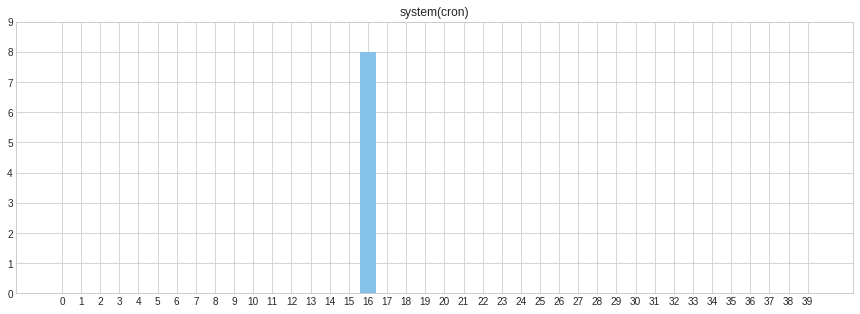

1.2489995996796797


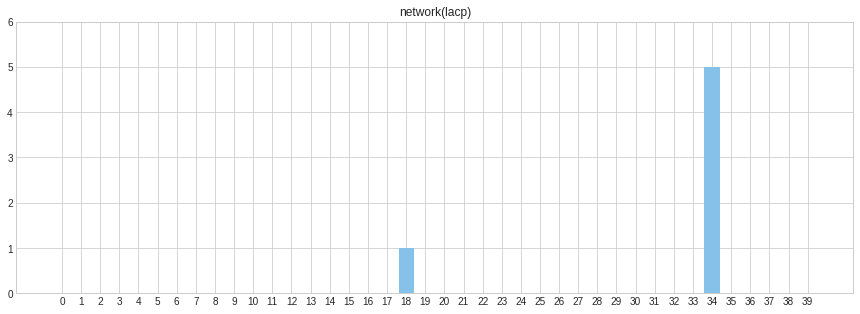

0.7921489758877429


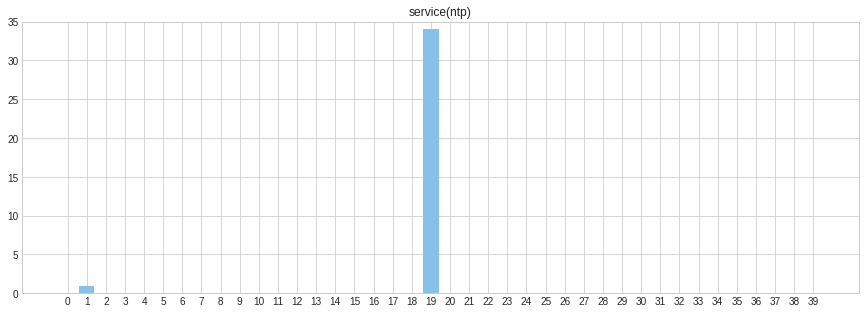

5.306540775307394


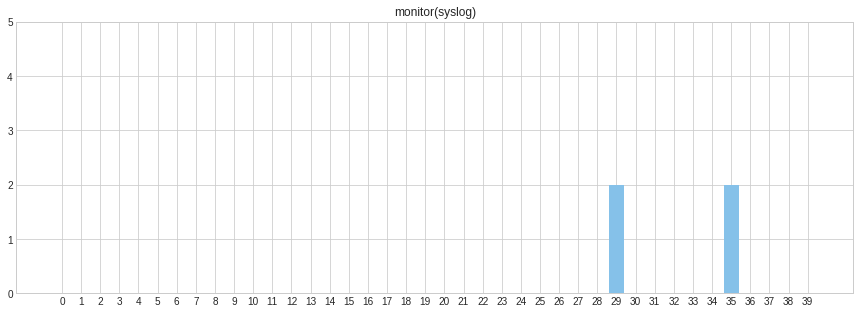

0.43588989435406733


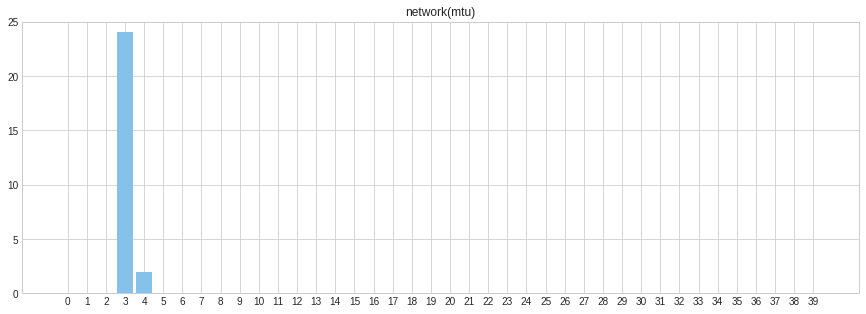

3.751999466950922


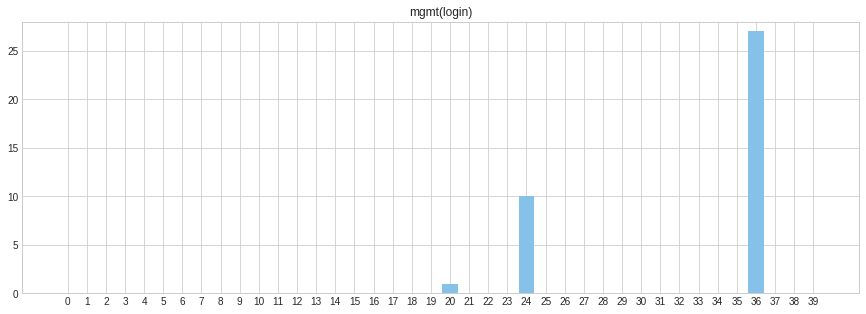

4.455053310567675


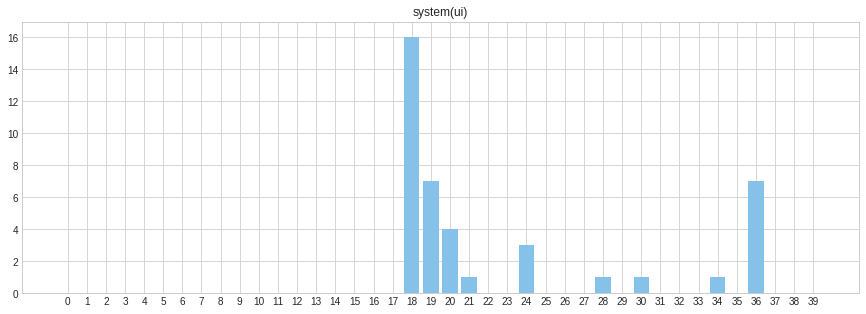

2.919653232834338


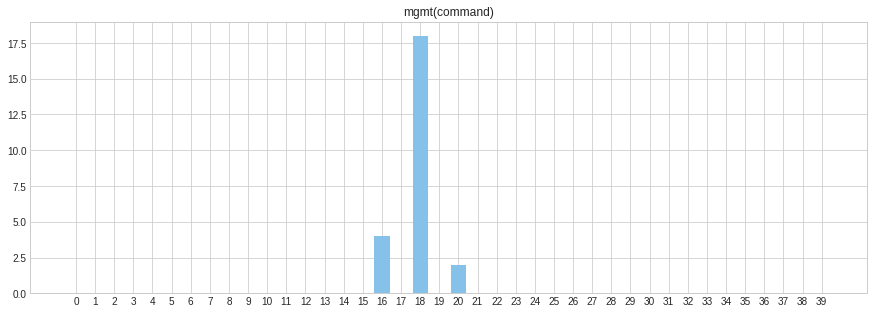

2.870540018881465


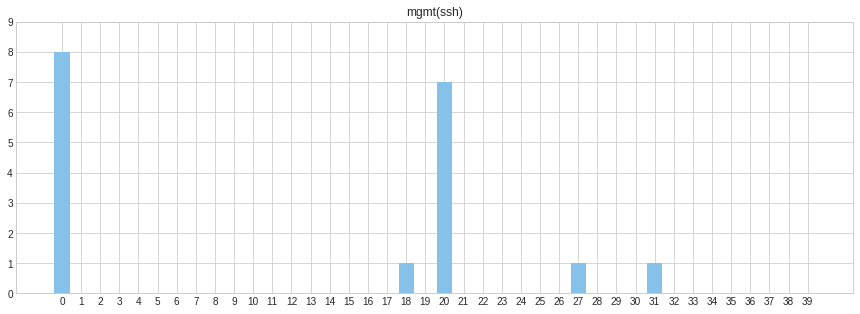

1.6424067705656842


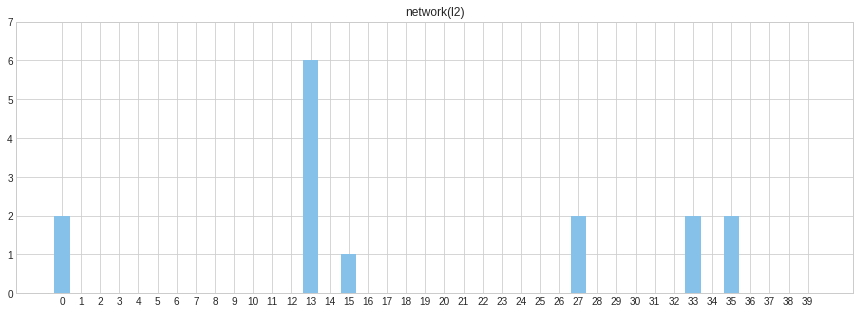

1.0882899429839459


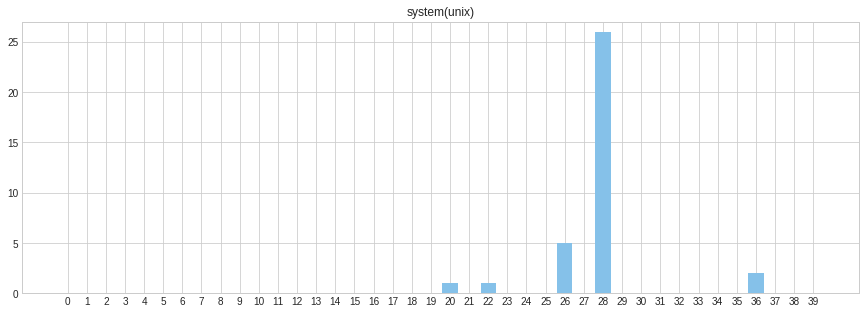

4.112101044478358


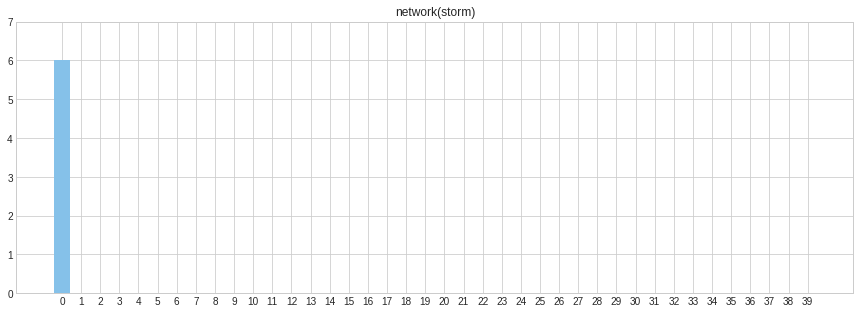

0.9367496997597597


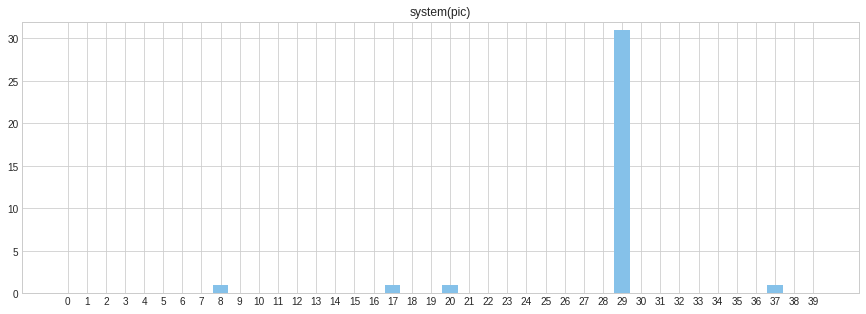

4.833153732295301


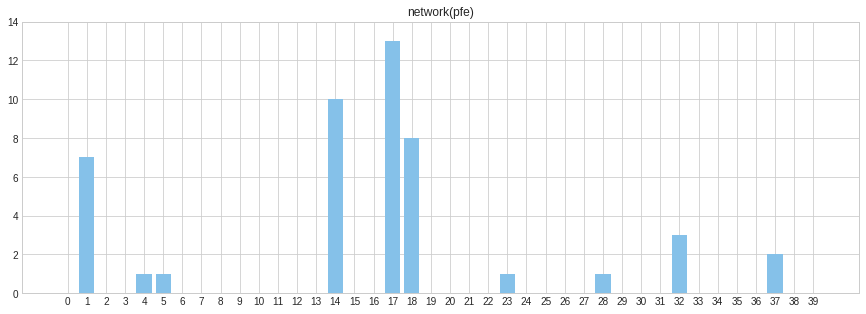

2.931616448309703


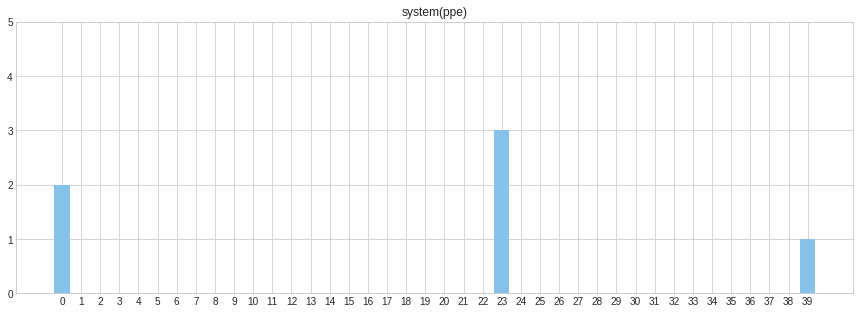

0.5722761571129799


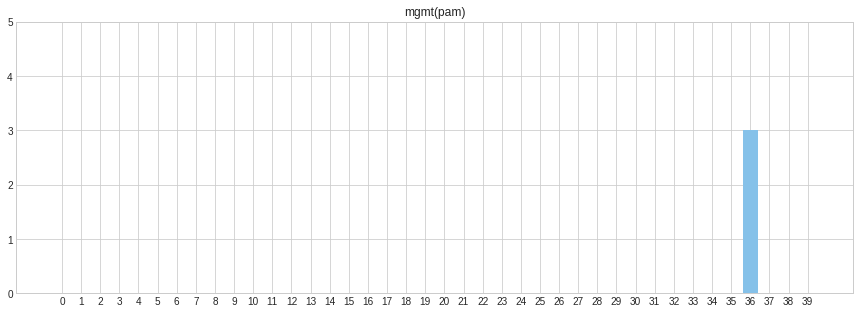

0.4683748498798799


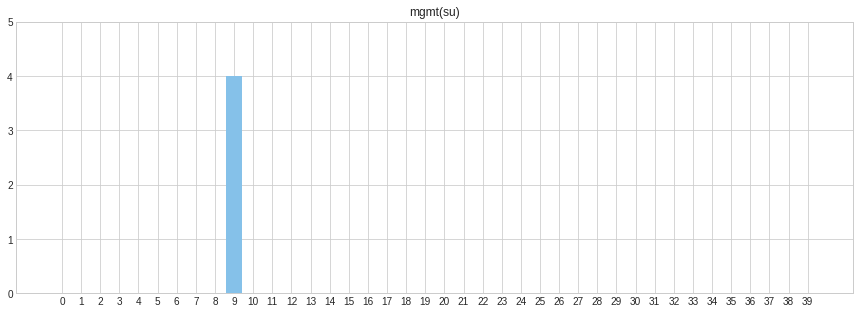

0.6244997998398398


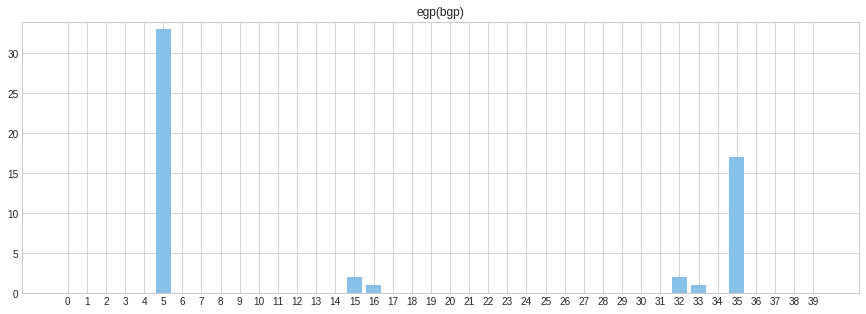

5.721887800367988


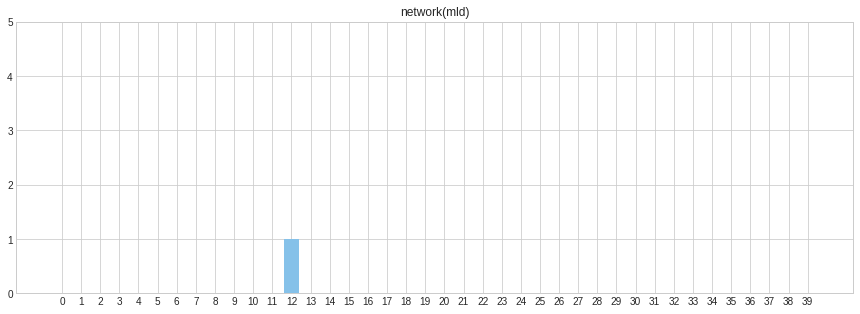

0.15612494995995996


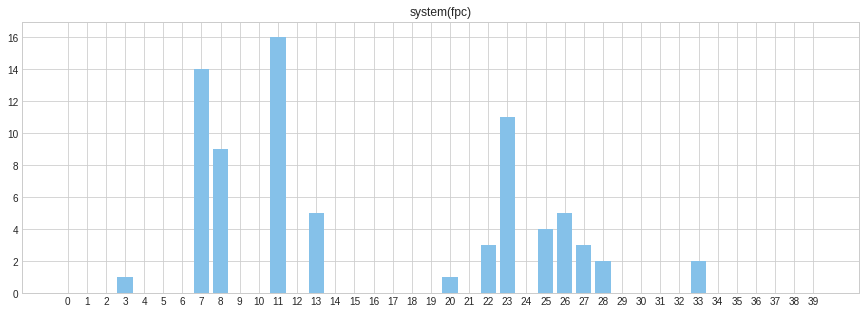

3.8845849199110067


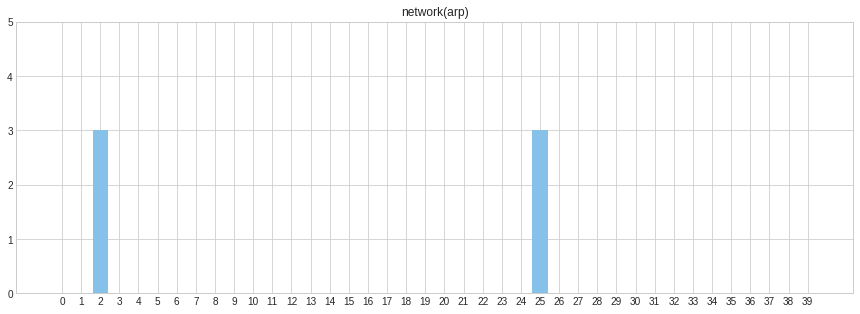

0.6538348415311012


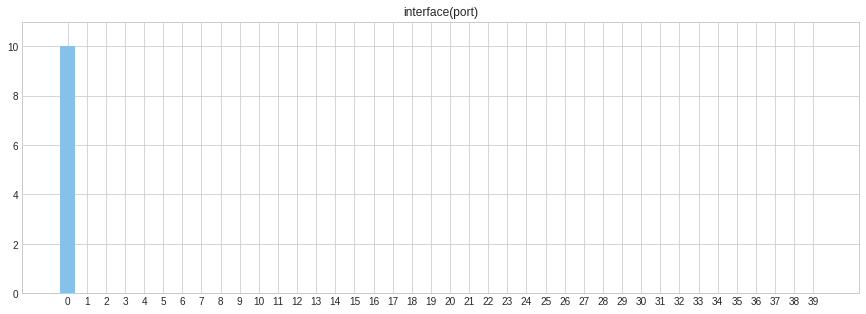

1.5612494995995996


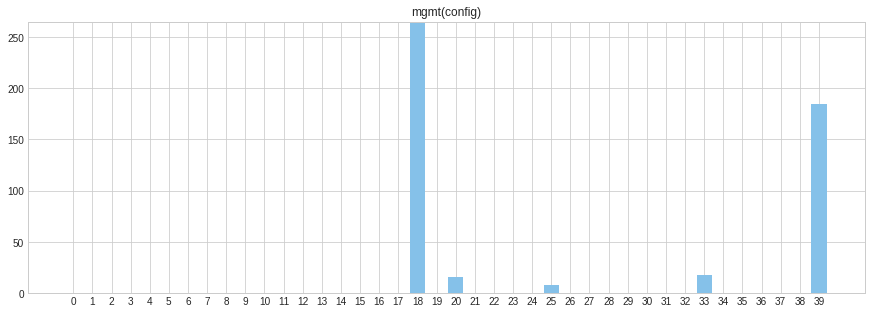

49.63314794570258


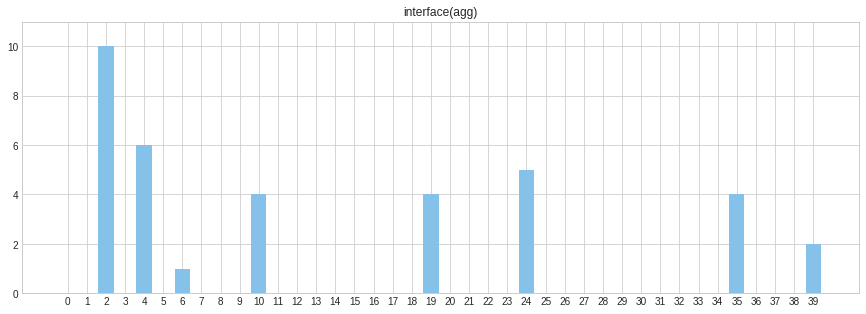

2.130727575266252


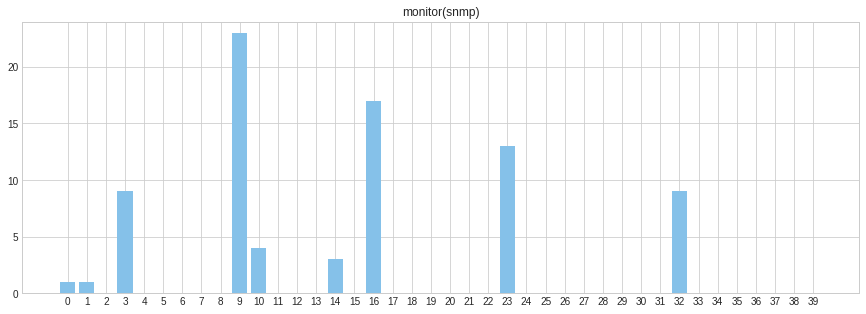

5.039841267341661


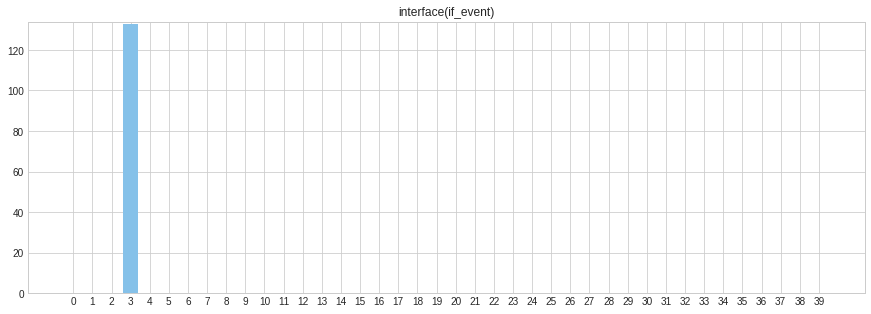

20.76461834467468


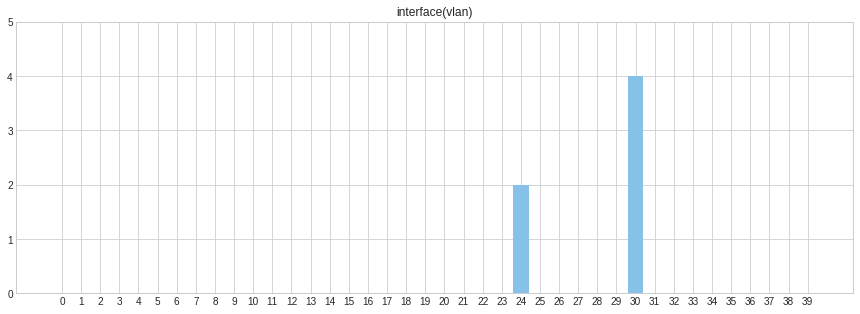

0.6910137480542627


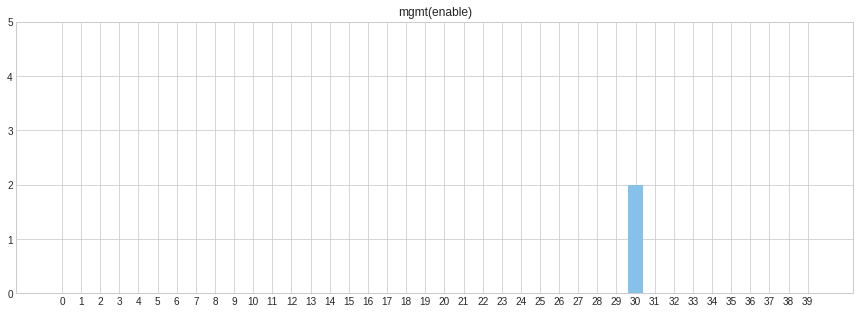

0.3122498999199199


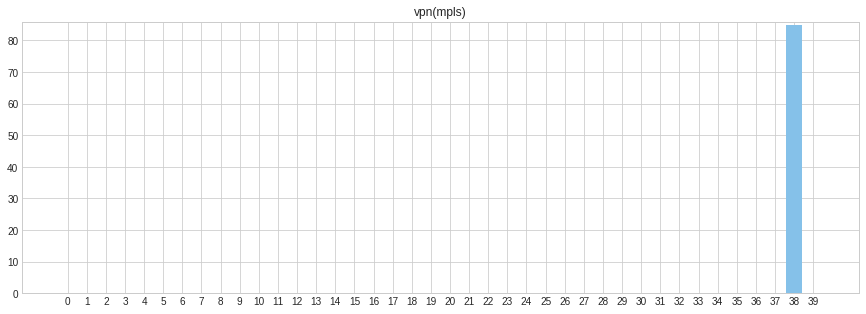

13.270620746596597


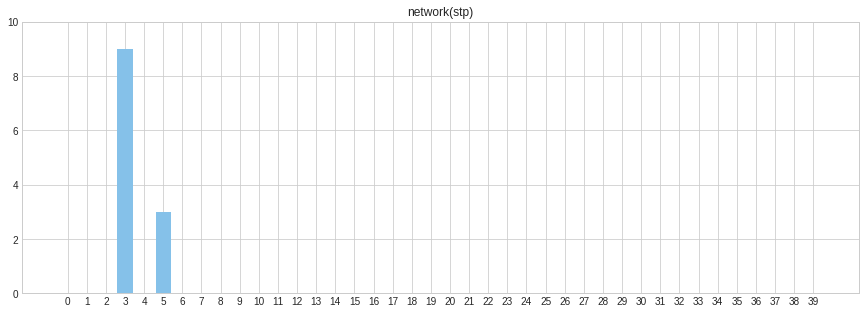

1.469693845669907


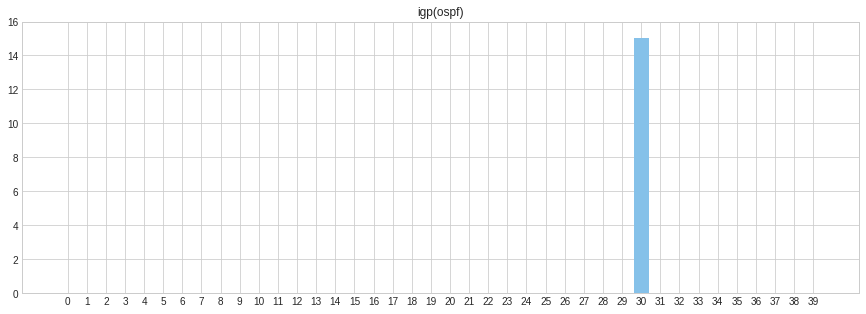

2.341874249399399


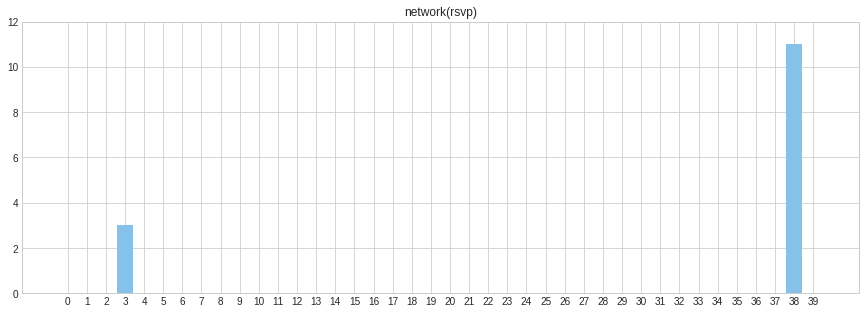

1.7684739183827394


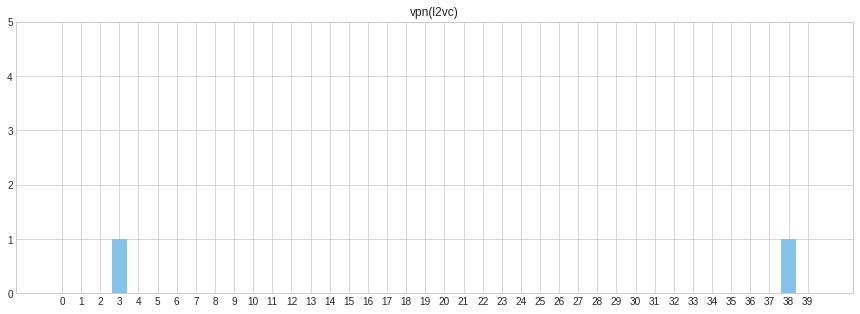

0.21794494717703367


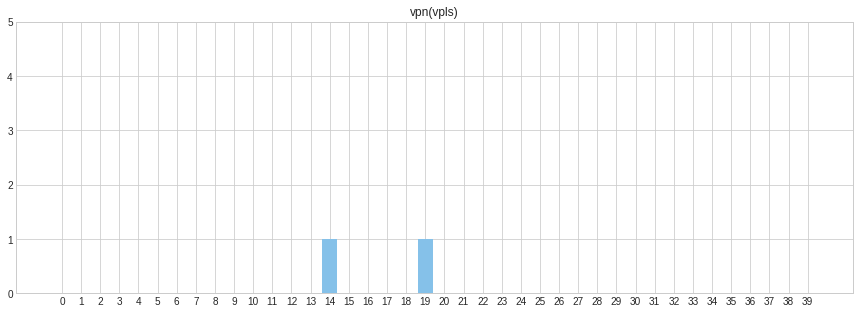

0.21794494717703364


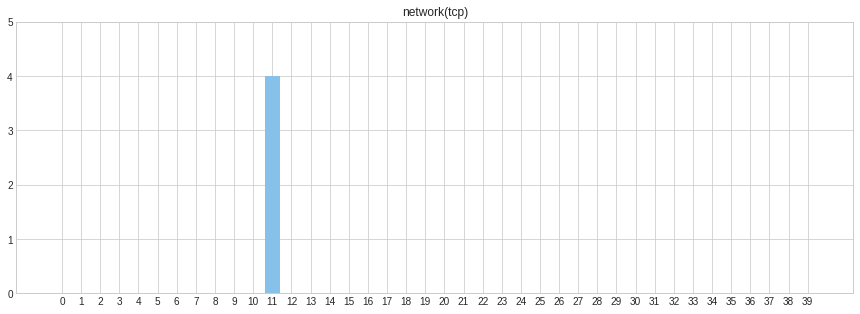

0.6244997998398398


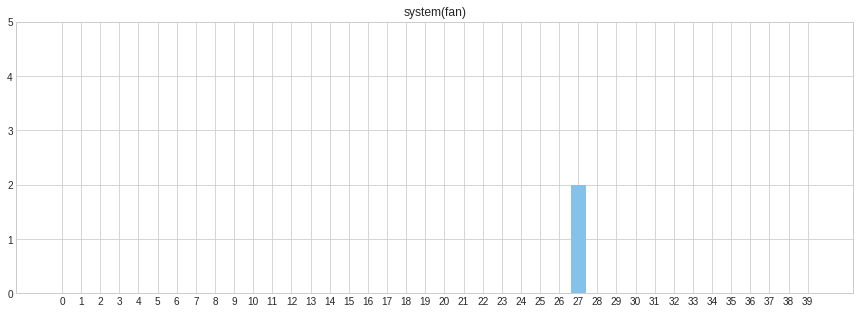

0.3122498999199199


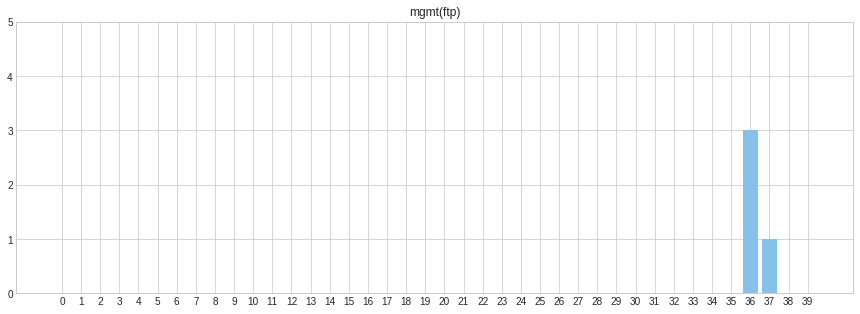

0.48989794855663554


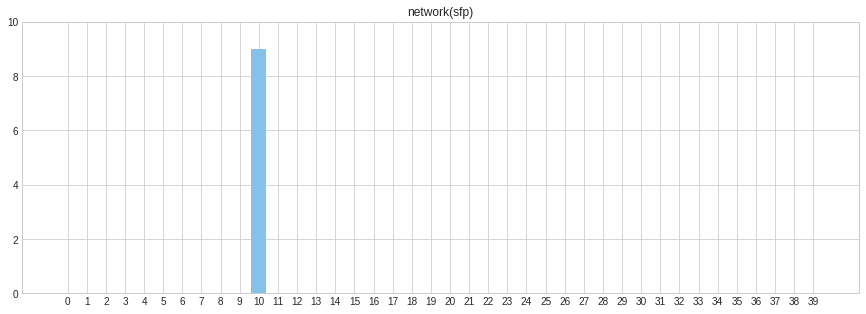

1.4051245496396394


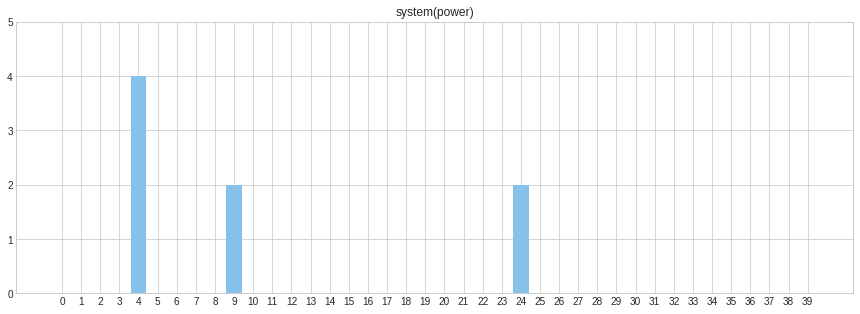

0.7483314773547882


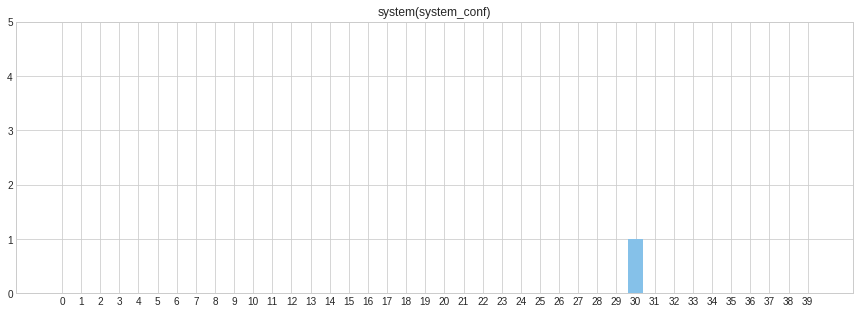

0.15612494995995996


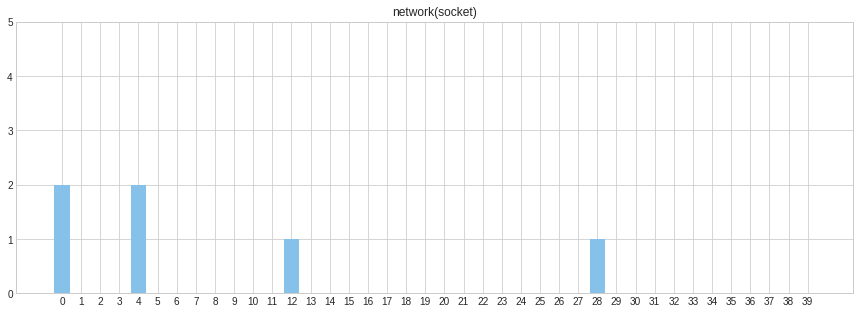

0.47696960070847283


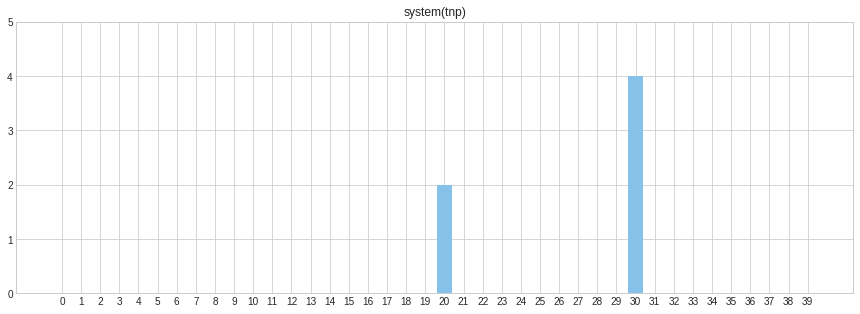

0.6910137480542627


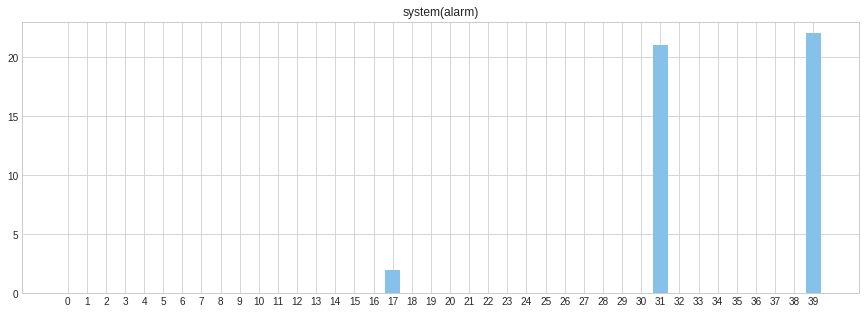

4.686083119194537


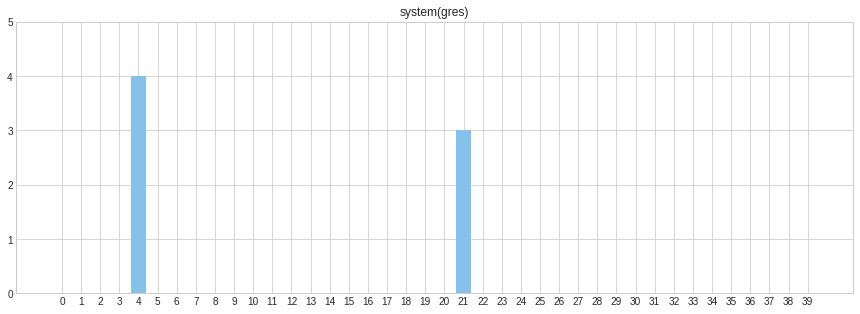

0.7709571972554637


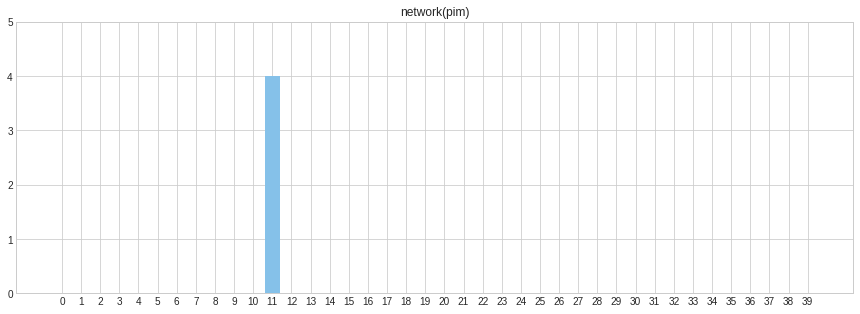

0.6244997998398398


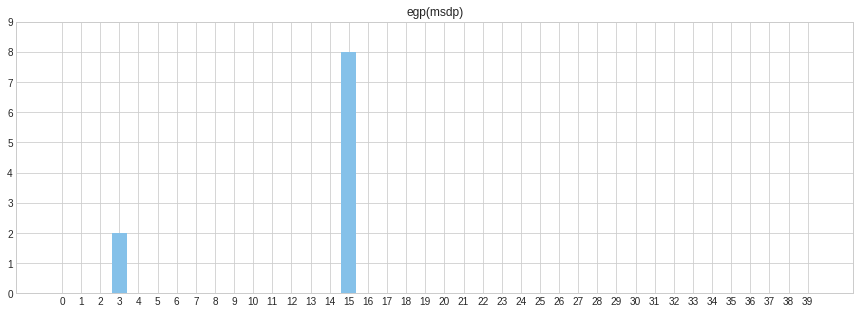

1.2796483892069728


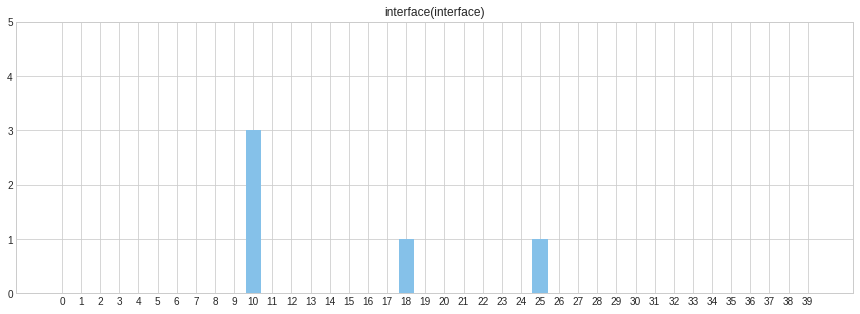

0.5092887196865841


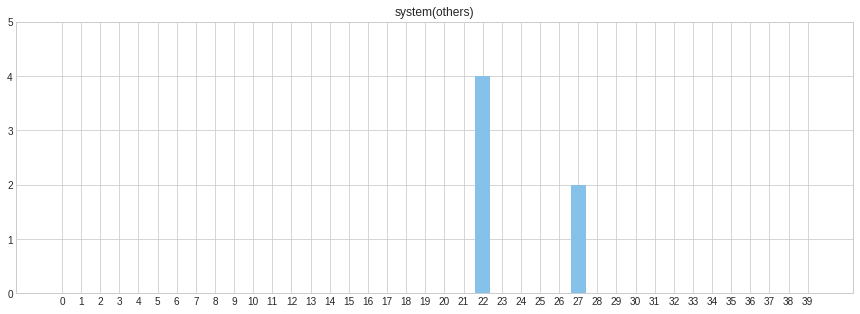

0.6910137480542627


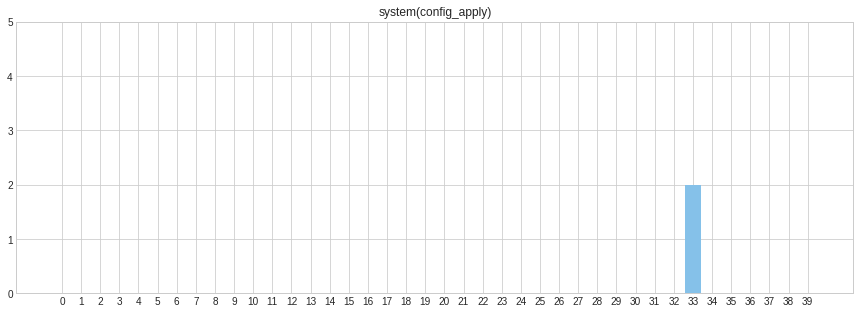

0.3122498999199199


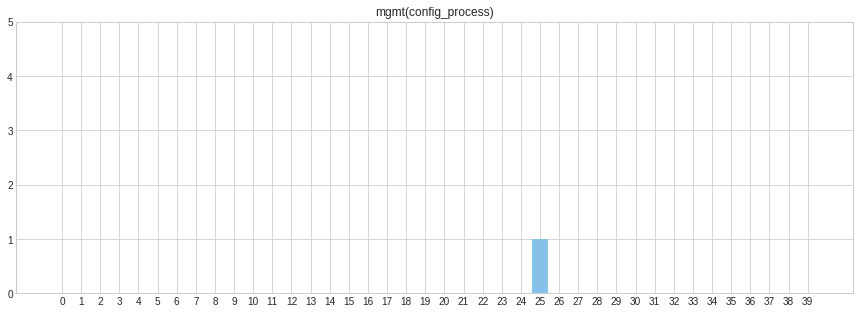

0.15612494995995996


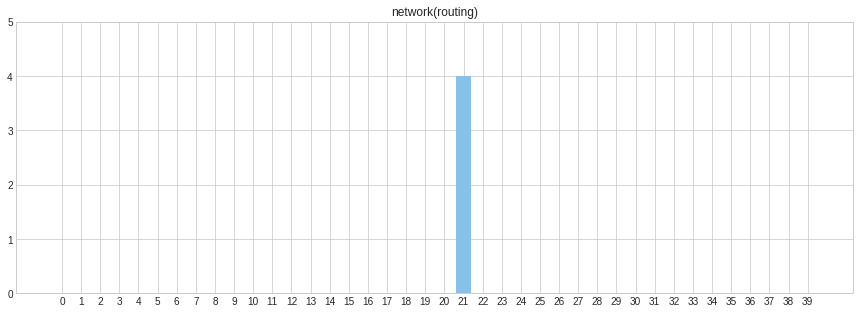

0.6244997998398398


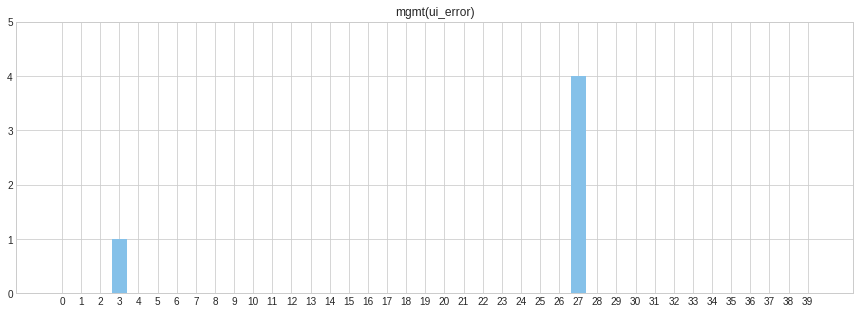

0.6398241946034864


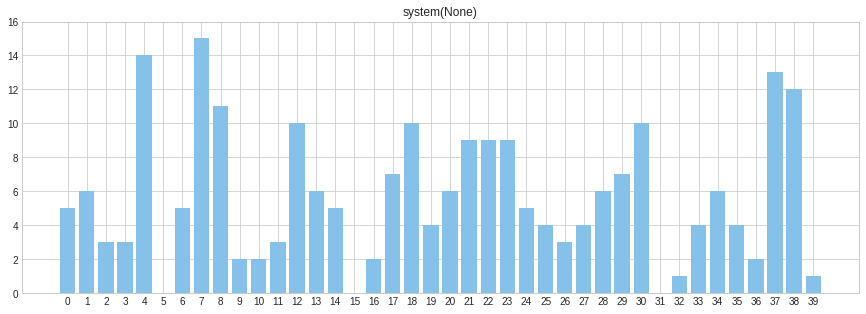

3.9064049969249224


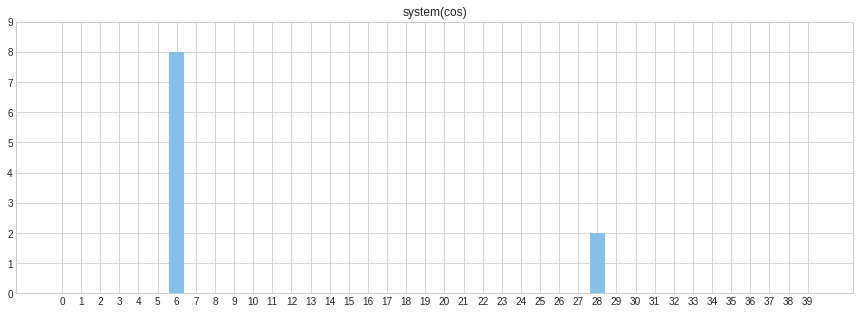

1.2796483892069728


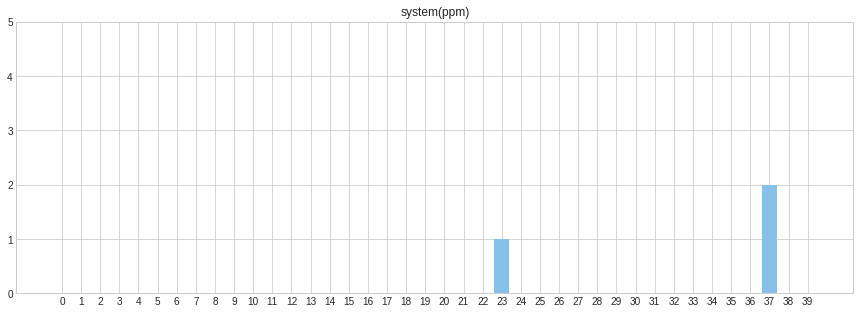

0.34550687402713137


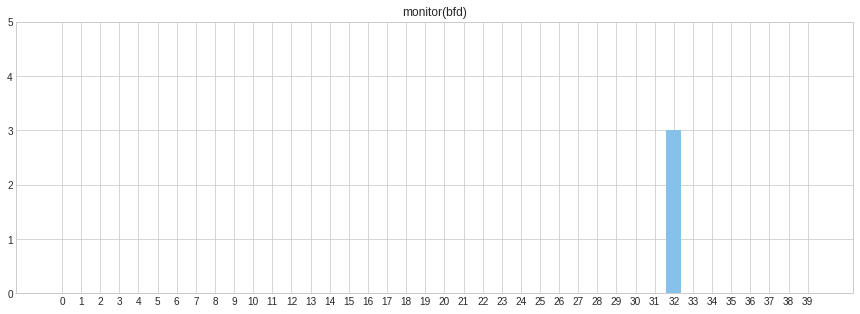

0.4683748498798799


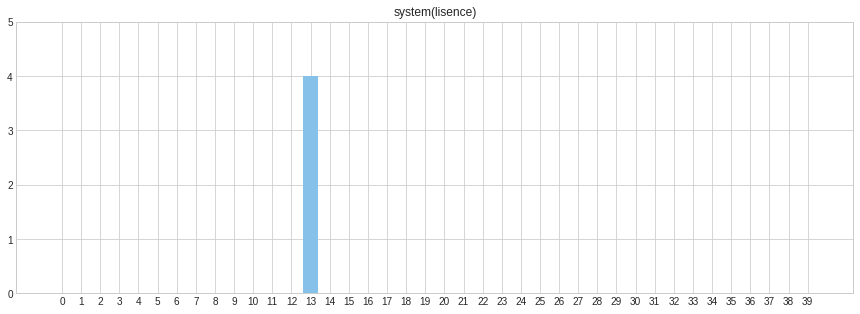

0.6244997998398398


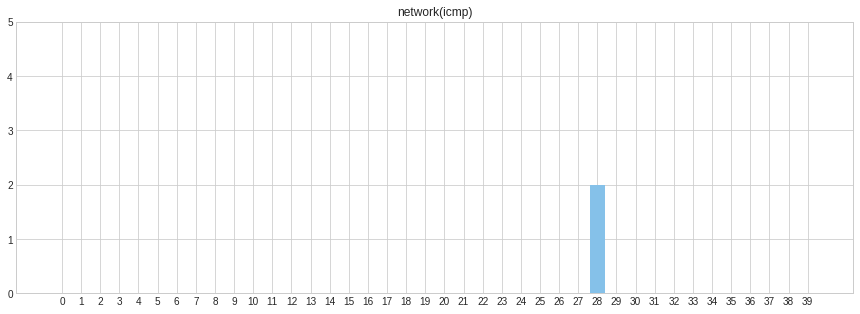

0.3122498999199199


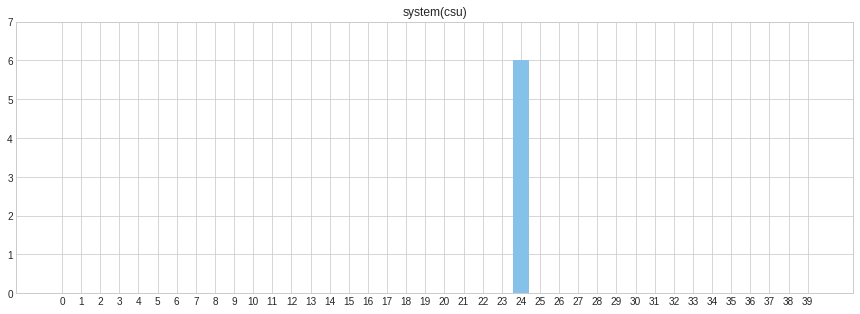

0.9367496997597597


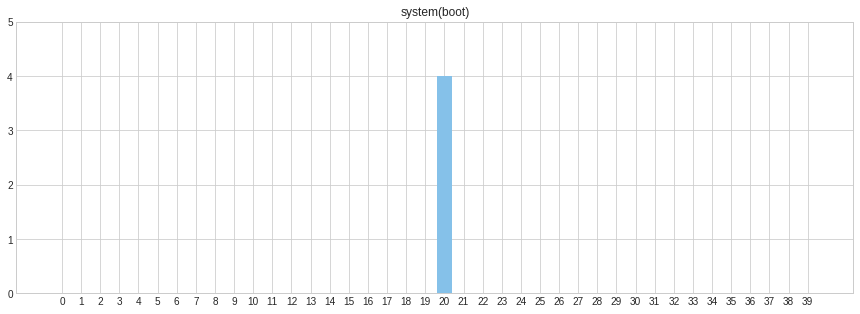

0.6244997998398398


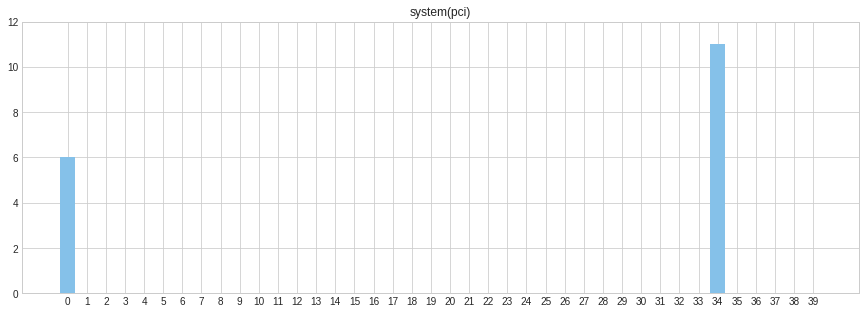

1.9350387593017353


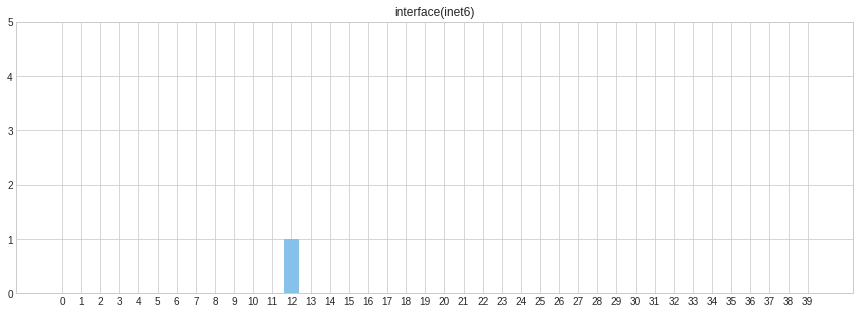

0.15612494995995996


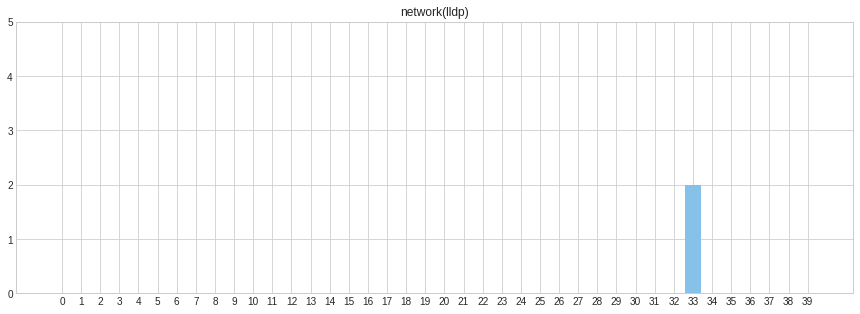

0.3122498999199199


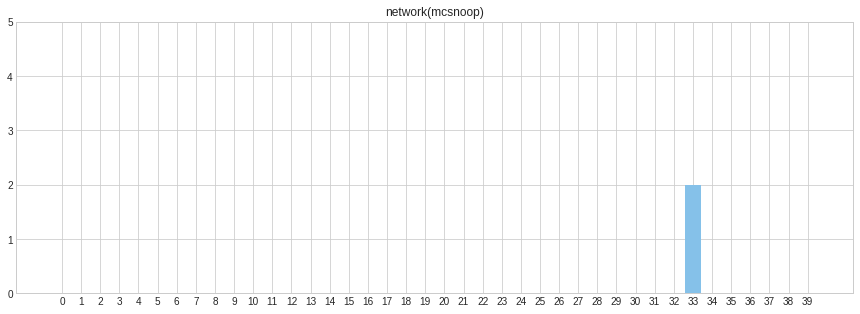

0.3122498999199199


In [22]:
## plot per category graphs
## x-axis: infered topic
## y-axis: cnt

plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
cvs = []

for cat, res in inf_per_cat.items():
    plt.figure(figsize=(15, 5))
    plt.title(cat)
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]
    plt.bar(np.arange(40), y, color="#85C1E9")
    plt.xticks(np.arange(40))
    minY = 5 if max(y) < 5 else max(y)+1
    plt.ylim(0, minY)
    plt.show()

    print(np.array(y).std())
    cvs.append((cat, np.array(y).std()/np.array(y).mean()))

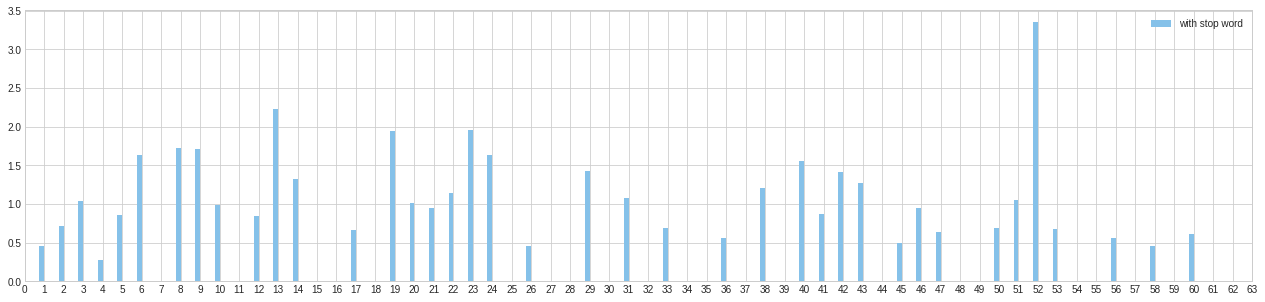

In [29]:
## plot per-category-entropy graph
## x-axis: labeled category
## y-axis: entropy

from scipy.stats import entropy
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
ent_results = []

for cat, res in inf_per_cat.items():
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]

    ent_results.append(entropy(y))
    
plt.figure(figsize=(22, 5))
plt.bar(np.arange(64)-0.25/2, ent_results, width=0.25, color="#85C1E9", label="with stop word")
plt.xticks(np.arange(64))
plt.xlim(0, 63)
plt.legend()
plt.show()

In [30]:
import pickle

In [31]:
with open("ent_result.dump", "wb") as f:
    pickle.dump(ent_results, f)

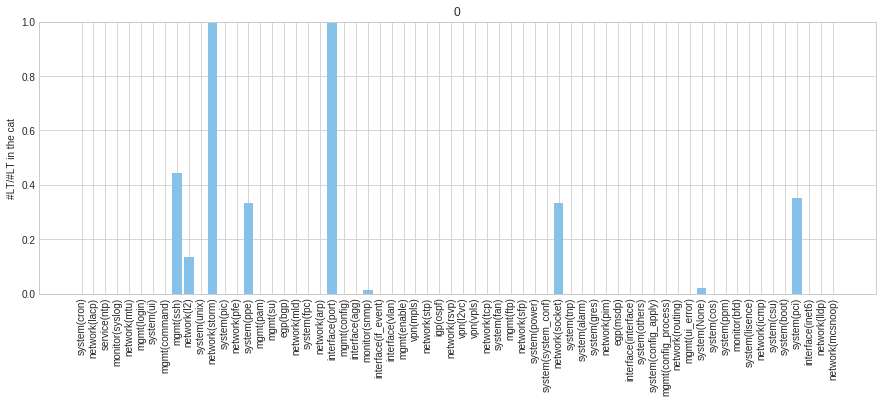

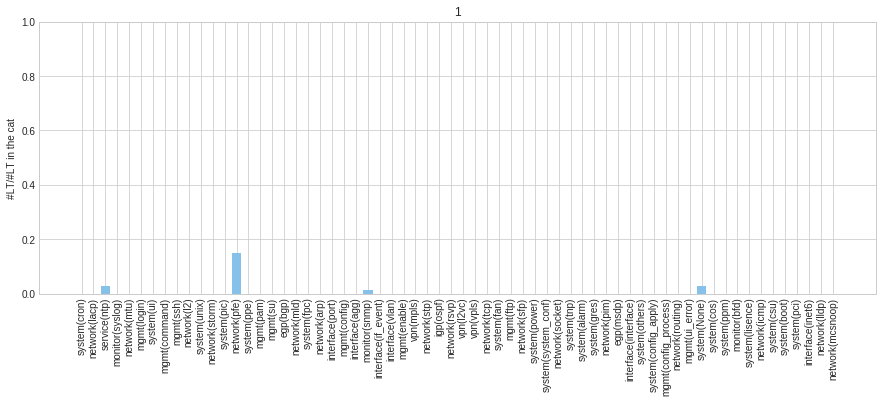

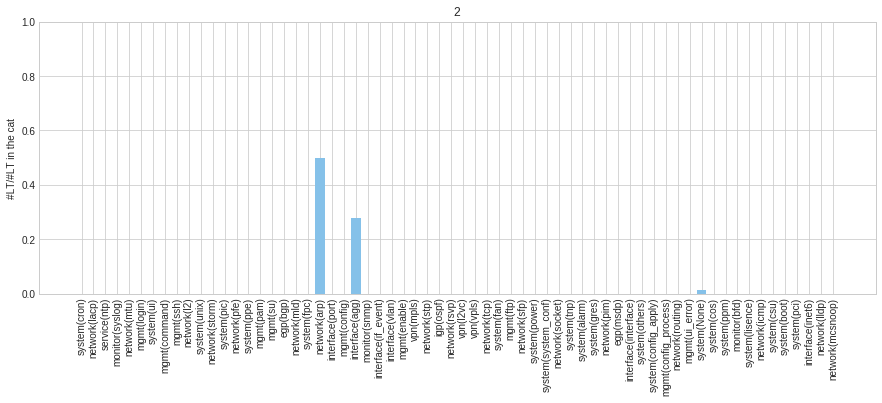

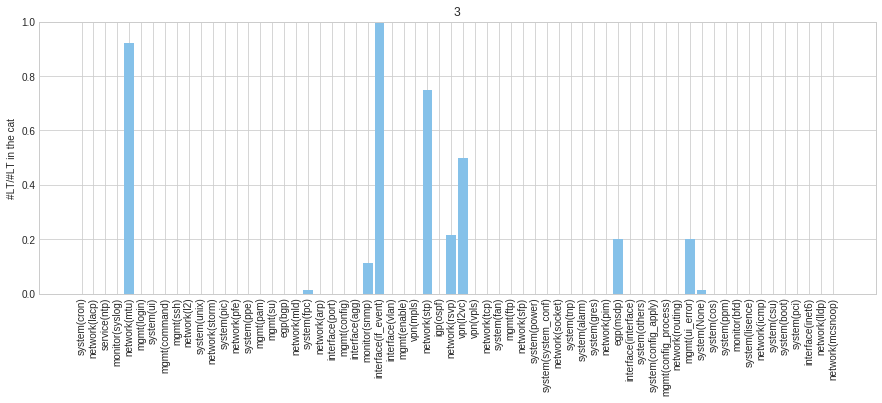

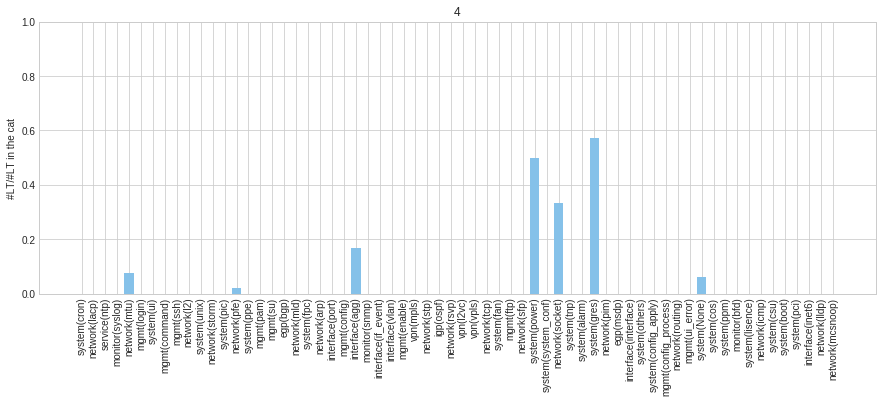

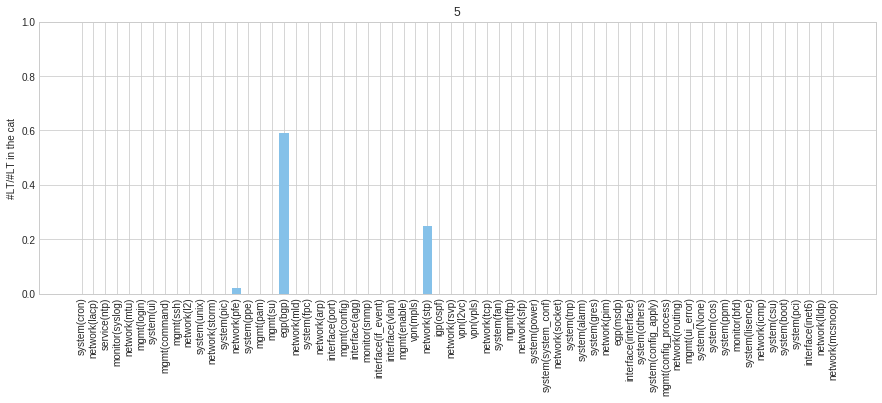

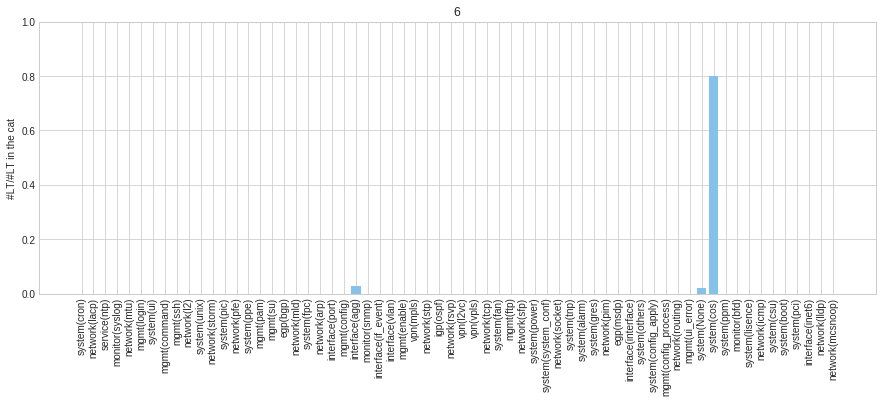

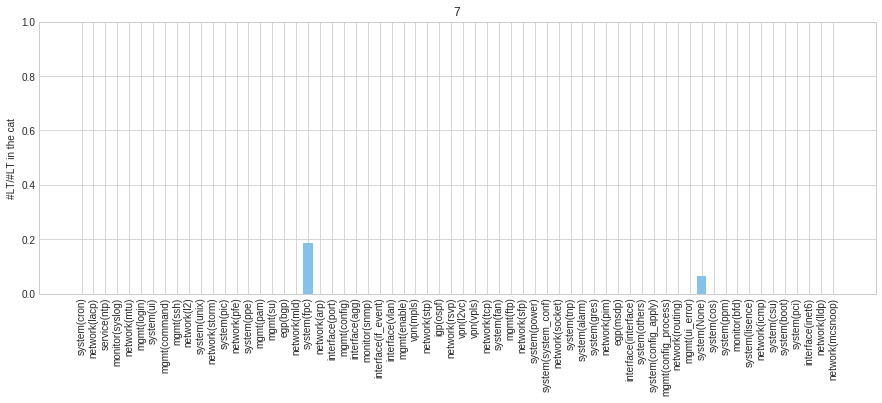

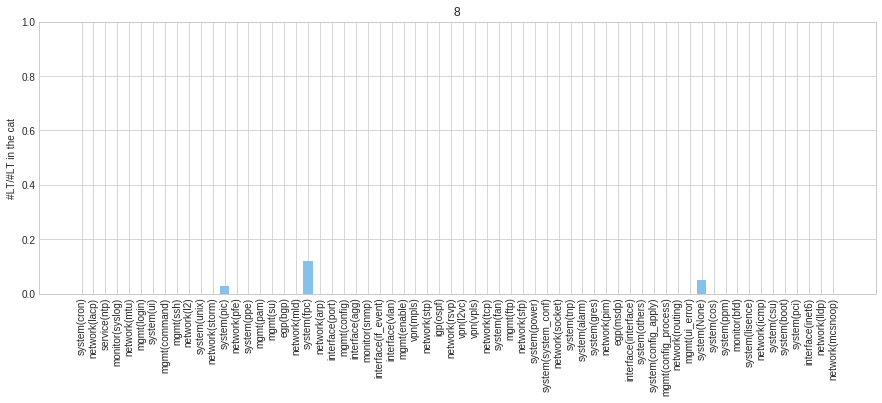

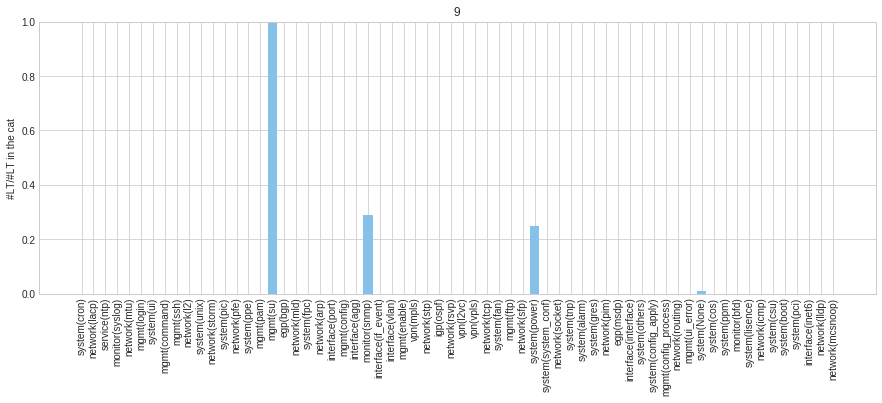

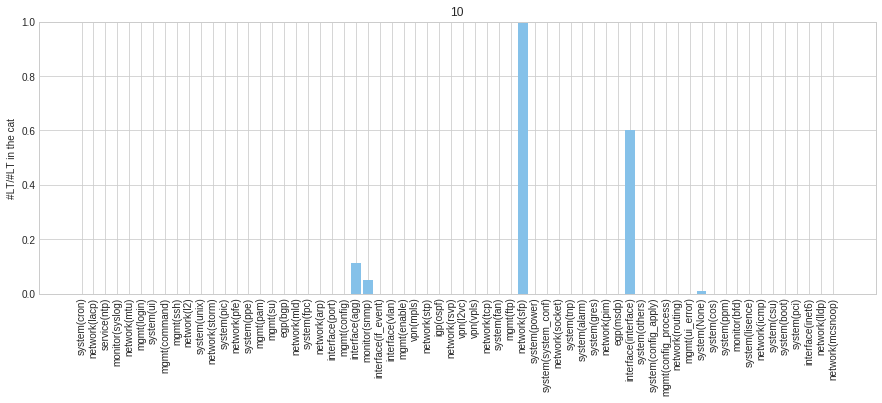

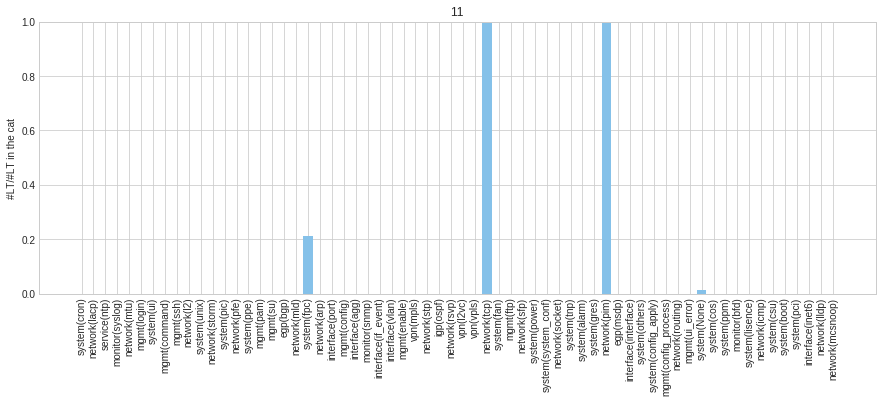

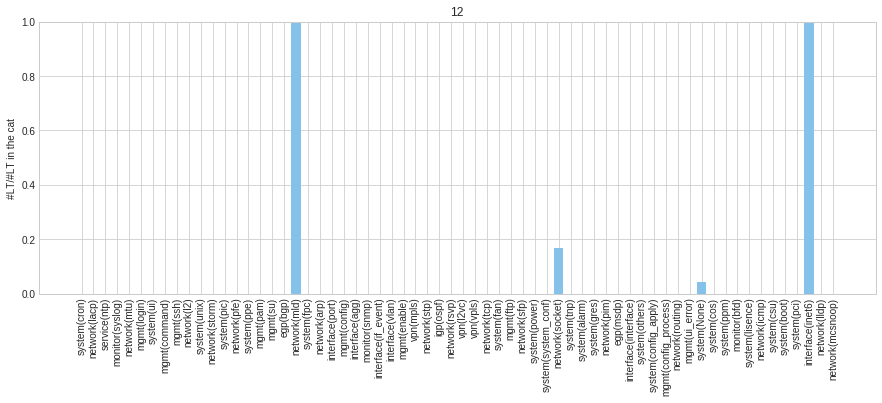

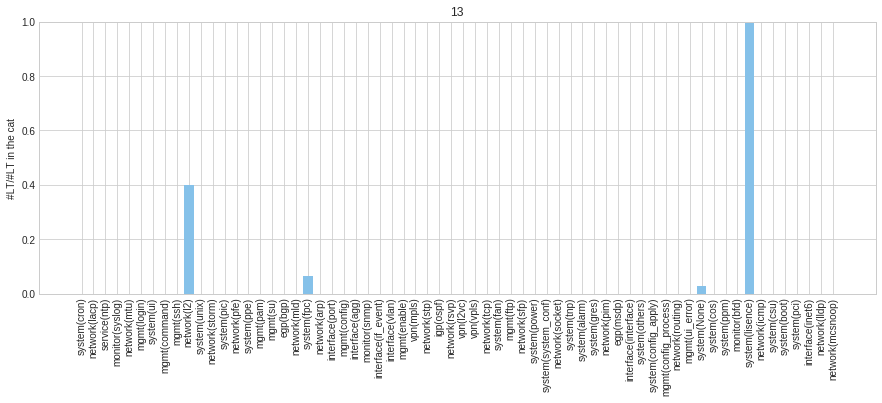

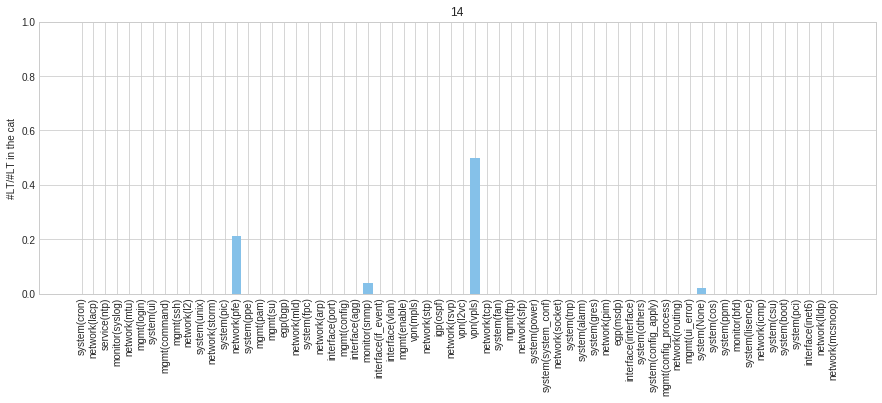

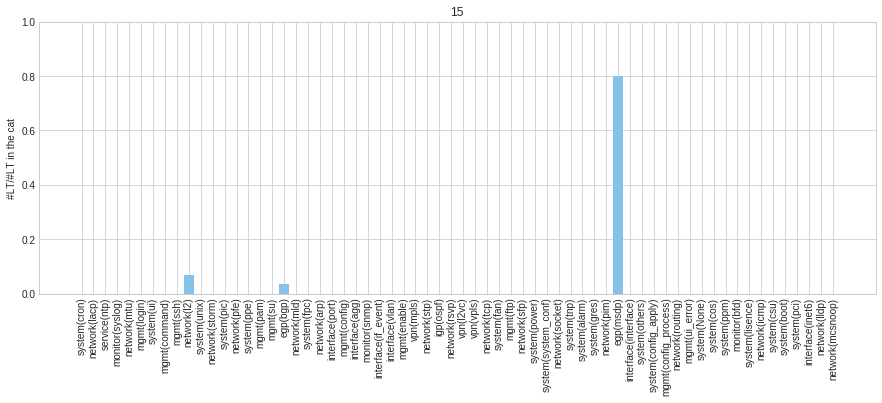

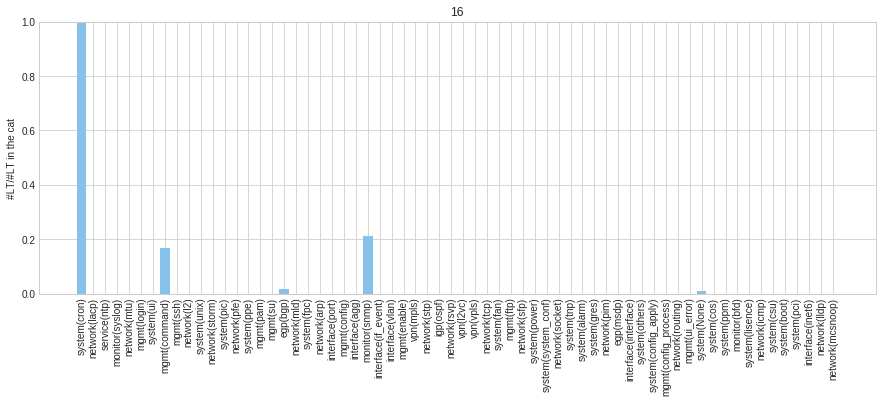

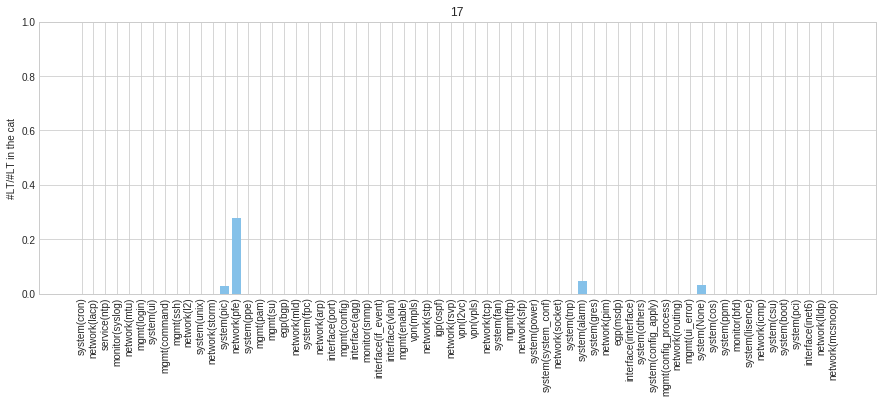

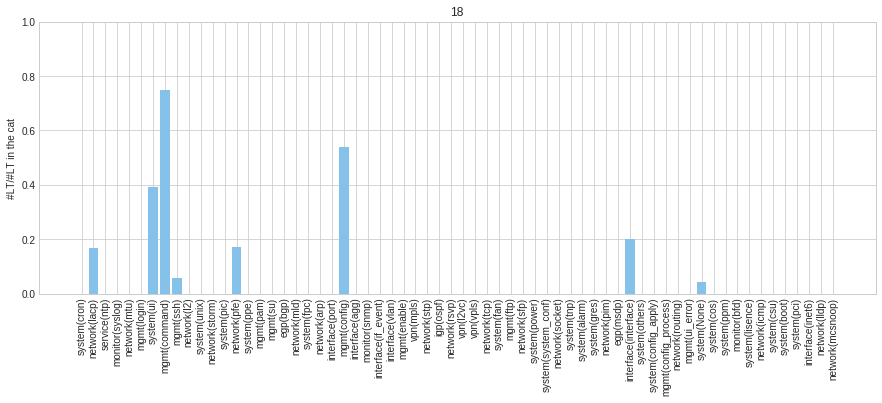

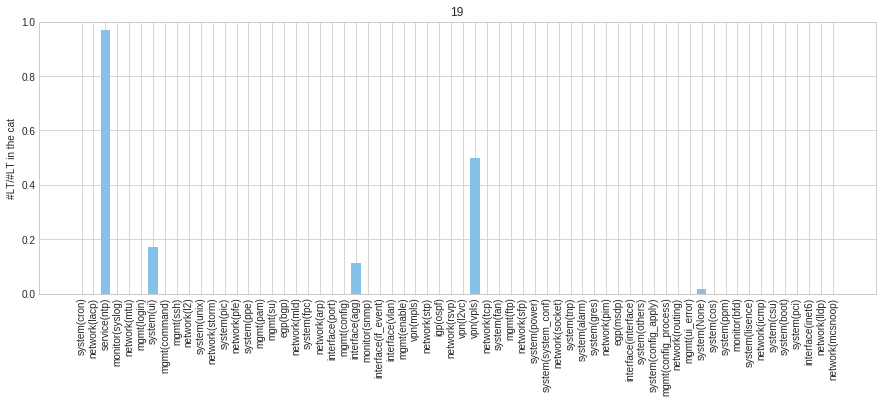

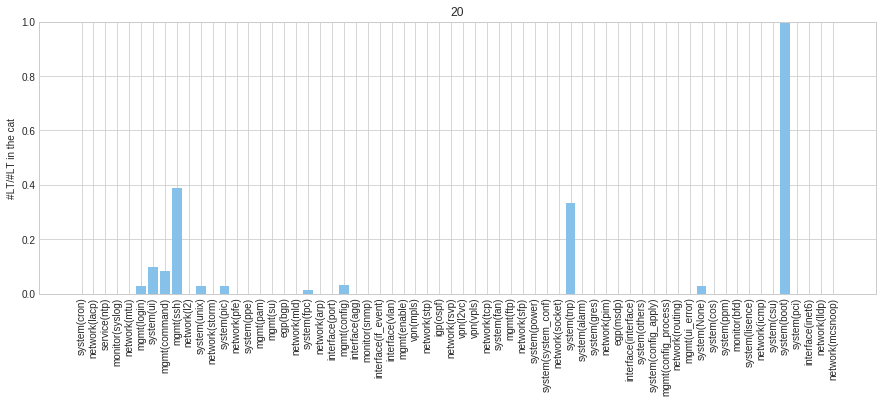

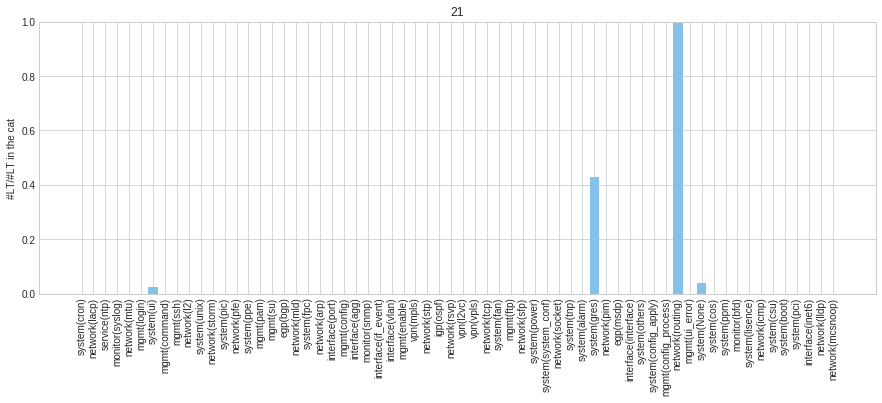

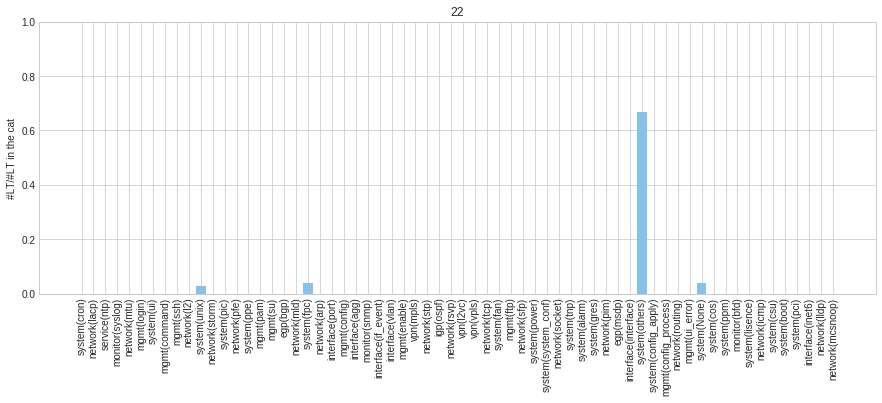

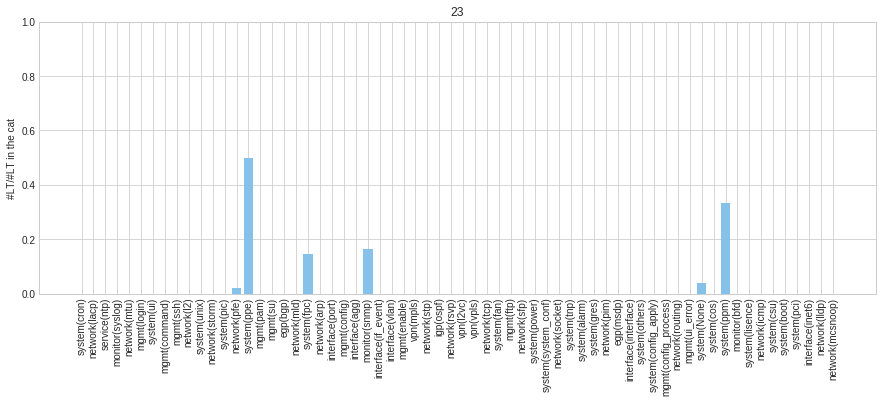

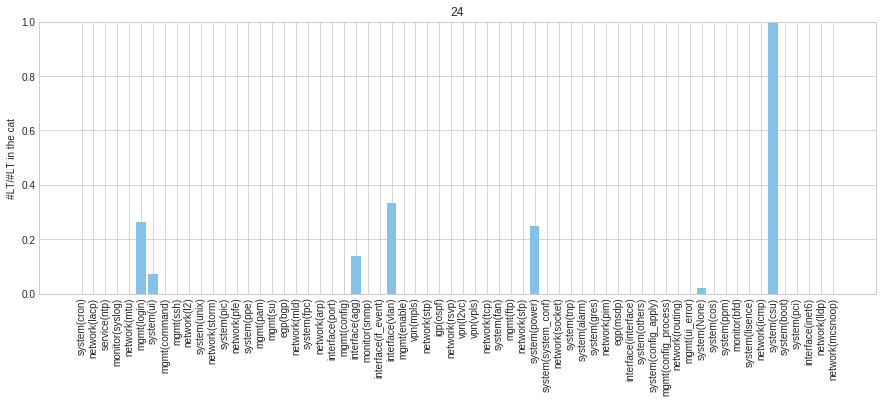

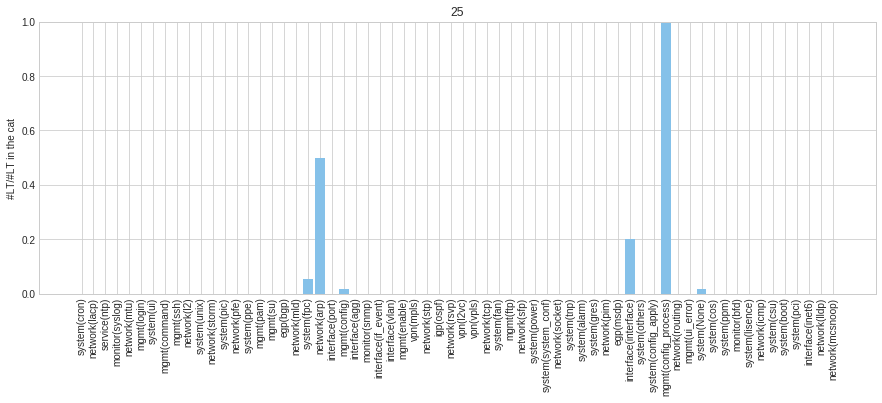

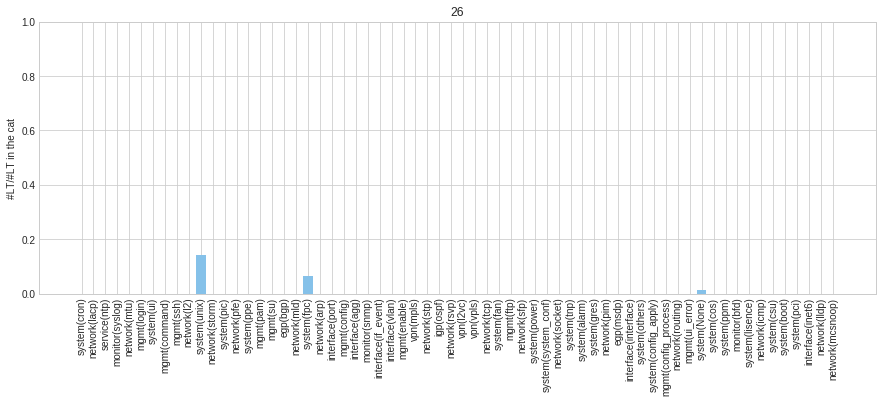

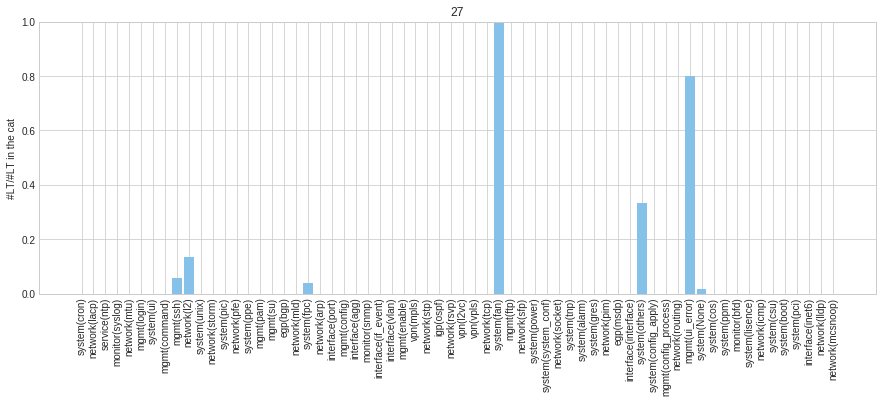

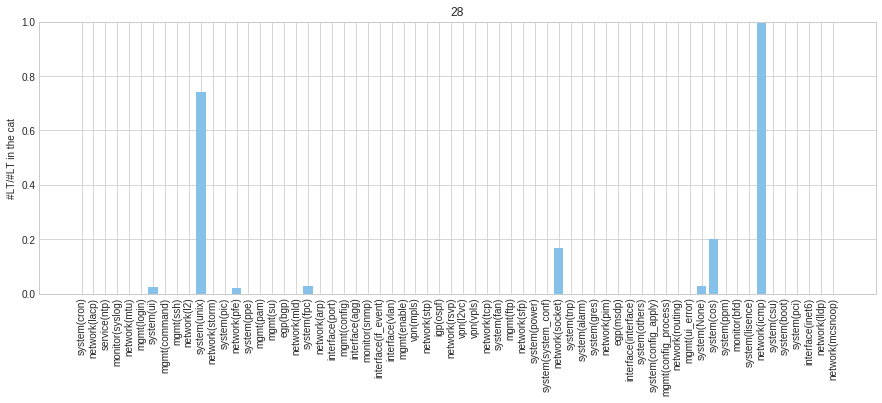

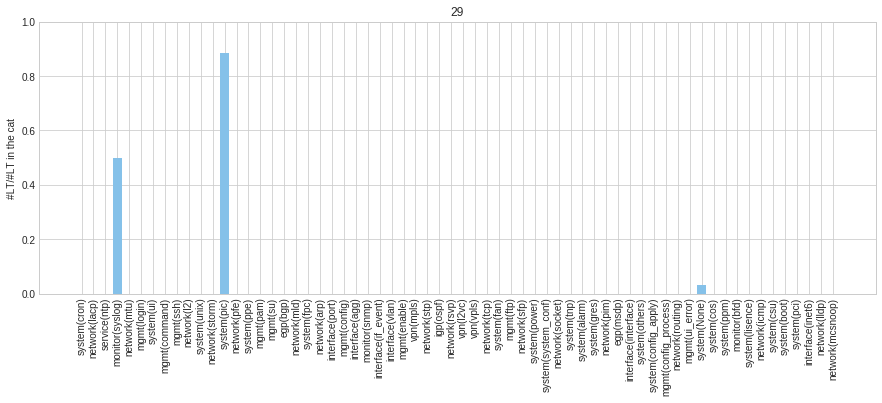

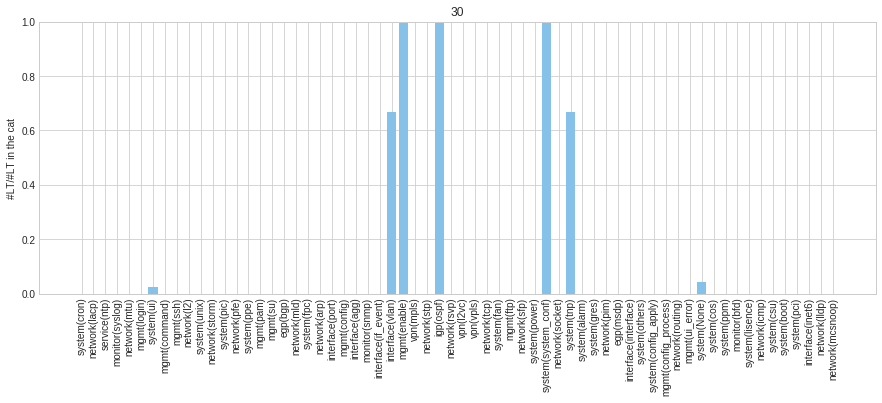

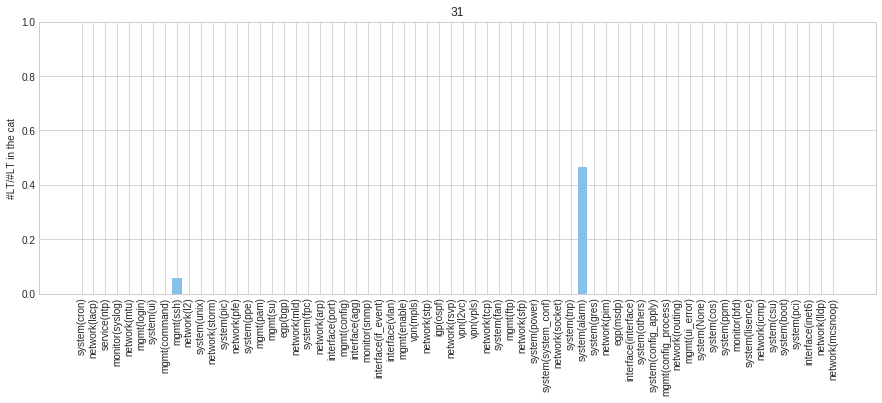

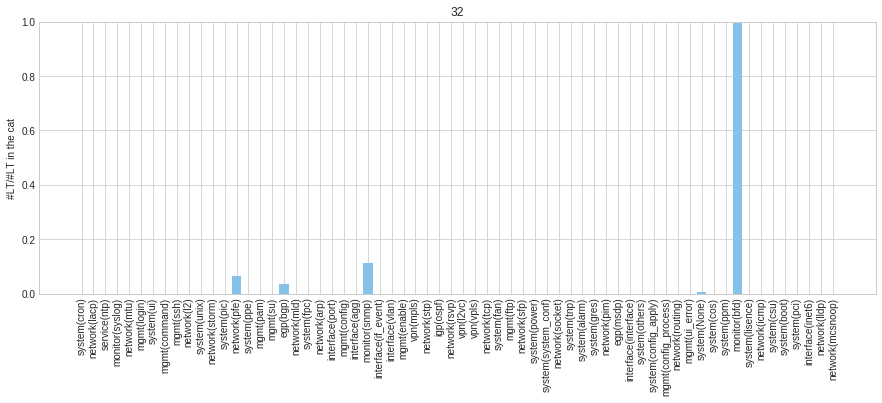

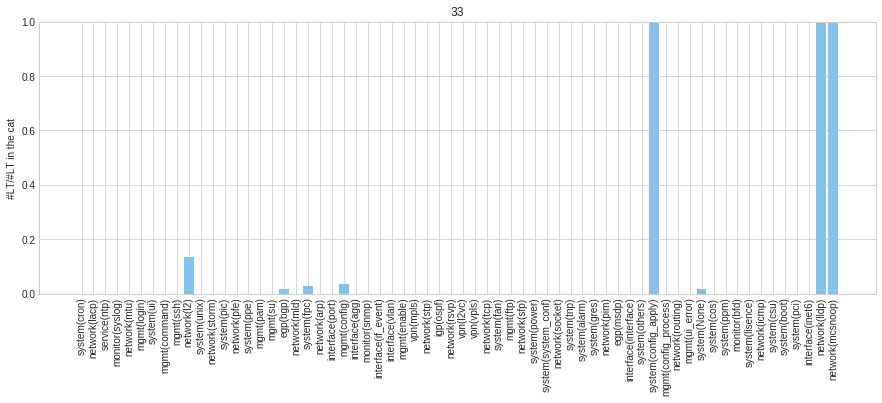

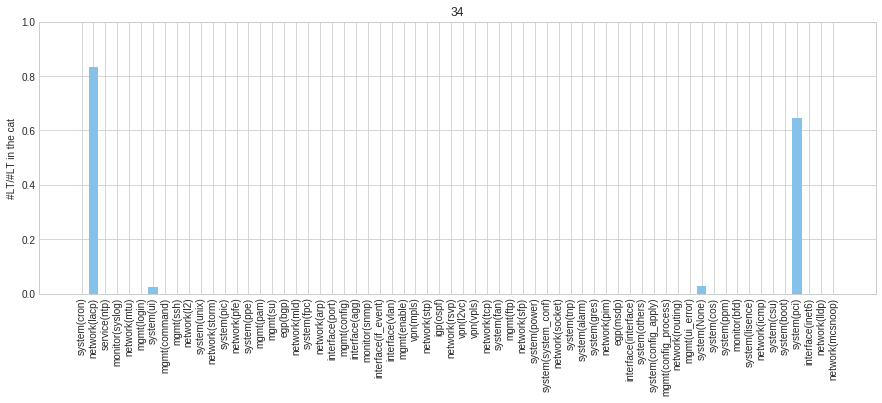

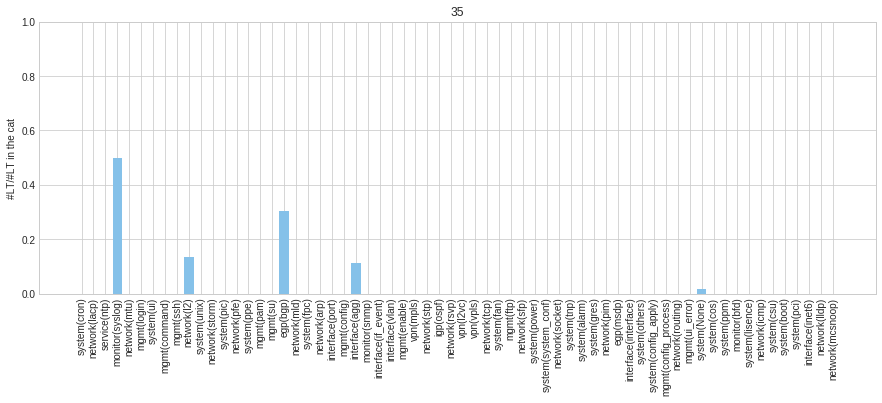

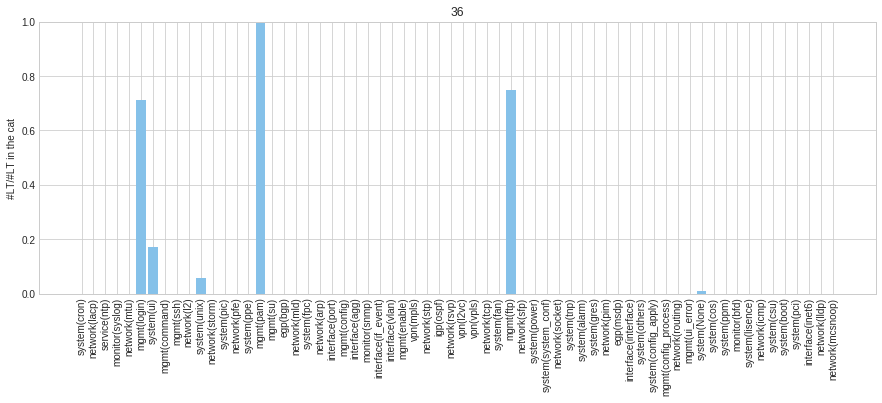

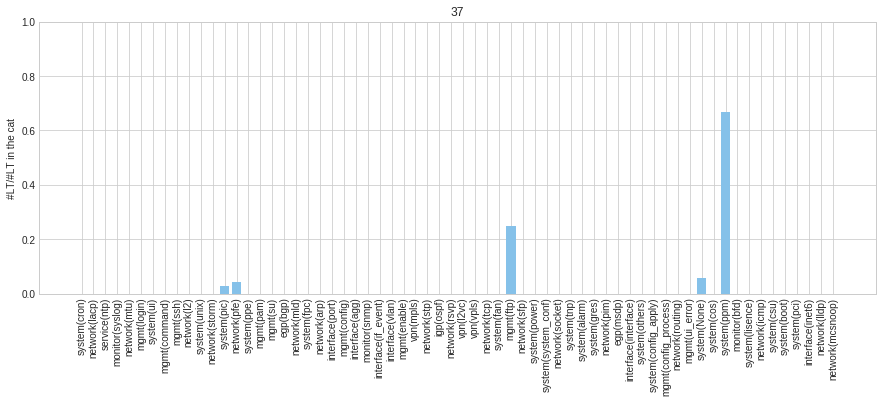

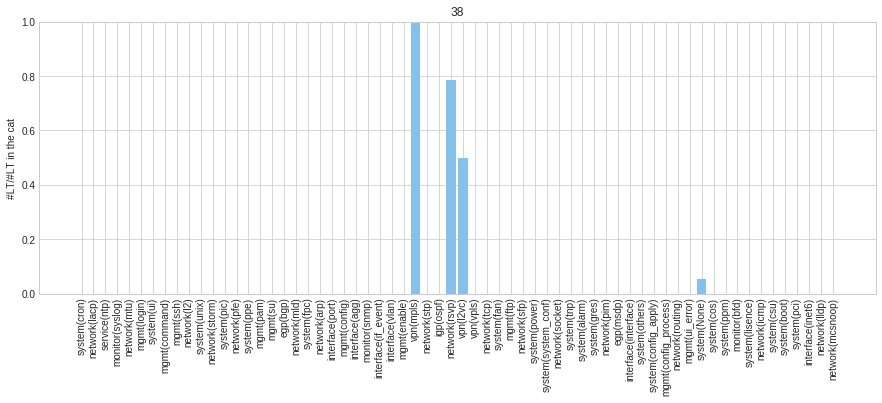

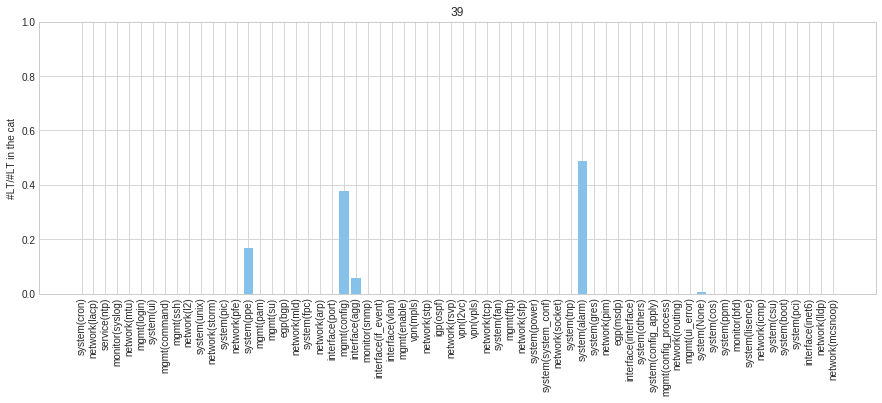

In [24]:
## 逆変換
## plot per topic graphs
## x-axis: labeled category
## y-axis: cnt

total_per_cat = np.array([len(lt_per_cat[i]) for i in inf_per_cat.keys()])

cat_per_inf = dict()
for i in range(40):
    cat_per_inf[i] = []

for cat, res in inf_per_cat.items():
    for r in res:
        cat_per_inf[r].append(cat)
    
for cat, res in cat_per_inf.items():
    plt.figure(figsize=(15, 5))
    plt.title(cat)
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in inf_per_cat.keys()]
    y = np.array(y) / total_per_cat
    plt.bar(np.arange(len(inf_per_cat)), y, color="#85C1E9")
    plt.xticks(np.arange(len(inf_per_cat)), inf_per_cat.keys(), rotation=90)
    plt.ylabel("#LT/#LT in the cat")
    plt.ylim(0, 1)
    plt.show()

### 集計結果

- gtのカテゴリごとに，どのトピックが振られたかを確認
    - カテゴリとトピックのそれらしい対応をつけて見た
    - 複数マージされるものと，対応づけられなかったものが存在
- 訓練じはUIの単語を含むものは除外したが，評価じは全て含めた
- gt通りにうまくいったものは存在

## VyOS

In [45]:
with open("./vyos_logs/tpl_all_uniq", "r") as f:
    raw_vyos = f.readlines()

In [46]:
def remove_error_words(split_words):
    for error_word in error_words:
        if error_word == split_words[-len(error_word):]:
            return split_words[:-len(error_word)] ## 前方の単語が抜かれてしまわないようにする
    return split_words

In [47]:
words_per_lt = []
for lt in raw_vyos:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    words_per_lt.append(split_words)

In [48]:
len(words_per_lt)

29266

In [49]:
## エラー文の抽出

error_words = []

for lt in raw_vyos[2599:2733]:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    
    split_words = [w for w in split_words][5:]
    error_words.append(split_words)

In [50]:
all_words = list(set([word for words in words_per_lt for word in words]))
vy_word2id = {w:i for i, w in enumerate(all_words)}
vy_id2word = {v:k for k,v in vy_word2id.items()}

corpus = []
tmp_corpus = []
for lt in raw_vyos:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    split_words = remove_error_words(split_words)
    tmp_corpus.append(split_words)

In [51]:
for i in range(18145,18279):
    tmp_corpus[i] = ['cant',
      'setsockopt',
      'ip',
      'add',
      'membership',
      'fd',
      'addr',
      'ifindex',
      'alldrouters']

for i in range(18279,18413):
    tmp_corpus[i] = ['cant',
      'setsockopt',
      'ip',
      'add',
      'membership',
      'fd',
      'addr',
      'ifindex',
      'allspfrouters']

In [52]:
uniq_corpus = list(set([tuple(i) for i in tmp_corpus]))
for split_words in uniq_corpus:
    lt_word_id_cnt = collections.Counter([vy_word2id[w] for w in split_words])
    corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])

In [53]:
# 単語のカウント
word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    print(vy_id2word[wid], cnt)
    word_cnt[vy_id2word[wid]] = cnt

cant 548
not 444
pid 414
to 397
failed 390
ospf 379
socket 355
file 333
ripng 307
is 290
type 290
lock 272
error 242
set 195
lsa 193
router 188
could 184
no 182
interface 169
on 164
for 163
create 160
/ 158
seq 157
route 150
bind 149
accept 147
closing 145
vty 143
recv 143
nonblocking 138
recvfrom 137
exiting 136
vtysh 136
solicitation 136
abr 135
continuing 135
fopen 135
in 129
address 110
of 106
area 102
network 94
too 94
packet 92
a 92
new 91
from 83
length 82
invalid 80
add 80
send 76
link 75
neighbor 73
by 69
message 68
state 68
the 67
zebra 64
with 63
cannot 63
out 62
received 62
id 60
unknown 59
has 58
as 57
update 57
opaque 56
open 55
connection 55
fd 54
already 53
apiserver 53
nexthop 52
attribute 52
protocol 51
lsatype 51
operation 50
process 50
ip 49
many 49
be 48
this 48
ipv6 47
refresh 46
rcvd 46
found 45
timer 45
metric 45
bad 44
device 44
announce 43
smux 43
nssa 43
level 42
start 42
read 41
ifindex 41
index 41
0x 39
isis 39
or 38
originate 38
prefix 37
multicast 36
mism

In [54]:
len(all_words)

2230

In [41]:
# LTレベルの共起
cor_df = pd.DataFrame(index=np.arange(len(vy_word2id)), columns=np.arange(len(vy_word2id)), dtype=int)
cor_df = cor_df.fillna(0)

for s in tqdm.tqdm(corpus):
    for a,b in itertools.combinations(s, 2):
        ida = int(a[0])
        idb = int(b[0])
        cor_df[ida][idb] += max(int(a[1]), int(b[1]))
        cor_df[idb][ida] += max(int(a[1]), int(b[1]))

cor_list = []
for a,b in tqdm.tqdm(itertools.combinations(np.arange(len(vy_word2id)), 2)):
    if cor_df[a][b] != 0 :
        cor_list.append([(a, b) , cor_df[a][b]])

100%|██████████| 3355/3355 [00:13<00:00, 250.55it/s]
2485335it [00:37, 66947.87it/s]


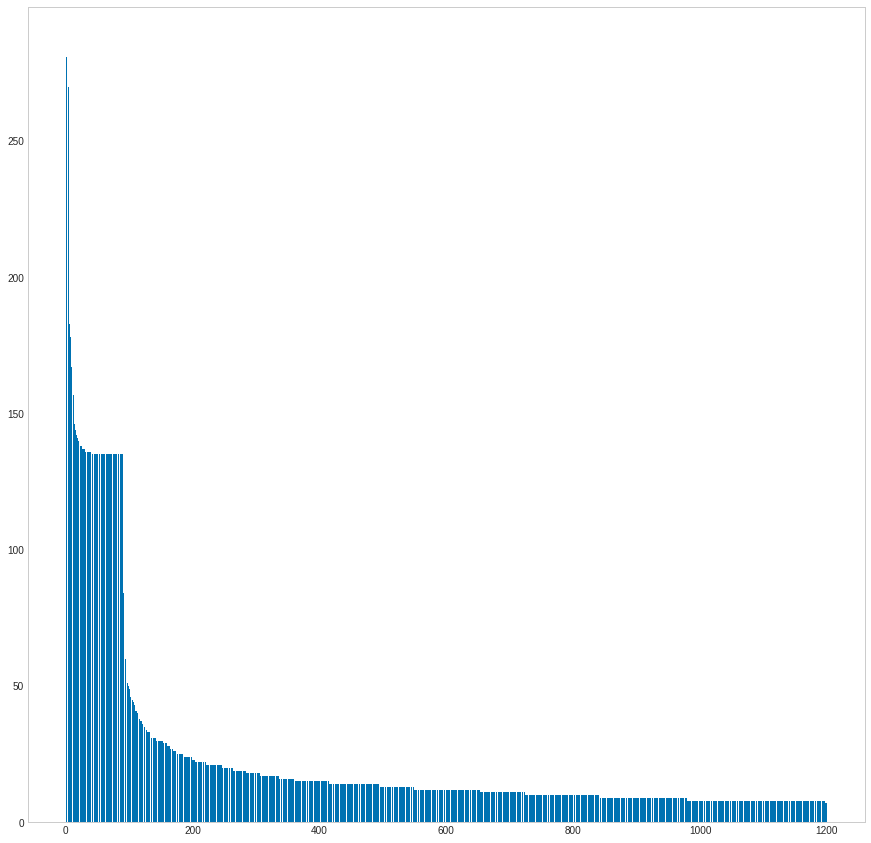

In [36]:
plot_data = [i[1] for i in sorted(cor_list, key=lambda x:x[1], reverse=True)][:1200]
plt.figure(figsize=(15, 15))
plt.bar(np.arange(len(plot_data)), plot_data)
plt.grid()
plt.show()

In [42]:
# stop_words = ["failed", "cant", "not", "to", "could", "cannot", "is", "a", "for", "fail"]
stop_words = ["failed", "is", "cant", "not", "error", "to", "the", "lengths", "arc", "on", "#i", "bound", "default"]

In [43]:
# G = nx.DiGraph()
G = nx.Graph()
nx.set_node_attributes

for i in sorted(cor_list, key=lambda x:x[1], reverse=True):
    if i[1] > 5: # 共起がn回以上
        a,b = i[0]
        
        if vy_id2word[a] in stop_words or vy_id2word[b] in stop_words:
            continue
            
        simpson = i[1]/min(word_cnt[vy_id2word[a]], word_cnt[vy_id2word[b]])
        jaccard = i[1]/(word_cnt[vy_id2word[a]] + word_cnt[vy_id2word[b]] - i[1])
        if simpson > 1.0 :
            simpson = 1.0
        if jaccard < 0. :
            jaccard = 1e-5
        
        if a == vy_word2id['zebra'] or b == vy_word2id['zebra']:
            print(simpson, jaccard, vy_id2word[a], vy_id2word[b], word_cnt[vy_id2word[a]], word_cnt[vy_id2word[b]], i)
        if simpson > 0.9:
            if a not in G.nodes:
                G.add_node(vy_id2word[a])

            if b not in G.nodes:
                G.add_node(vy_id2word[b])

            src = vy_id2word[a] if np.argmin([word_cnt[vy_id2word[a]], word_cnt[vy_id2word[b]]]) == 0 else vy_id2word[b]
            dst = vy_id2word[a] if src == vy_id2word[b] else vy_id2word[b]
            G.add_edge(src, dst) # weight=jaccard)

0.46875 0.1477832512315271 interface zebra 169 64 [(577, 740), 30]
0.296875 0.09743589743589744 zebra route 64 150 [(740, 1142), 19]
0.5142857142857142 0.2222222222222222 zebra delete 64 35 [(740, 876), 18]
0.28125 0.14285714285714285 zebra add 64 80 [(740, 1528), 18]
0.265625 0.08292682926829269 zebra / 64 158 [(740, 1196), 17]
0.28888888888888886 0.13541666666666666 zebra metric 64 45 [(740, 846), 13]
0.23076923076923078 0.11538461538461539 zebra nexthop 64 52 [(740, 1159), 12]
0.2391304347826087 0.1111111111111111 zebra rcvd 64 46 [(740, 1185), 11]
0.140625 0.05454545454545454 zebra address 64 110 [(740, 875), 9]
0.26666666666666666 0.09302325581395349 mtu zebra 30 64 [(560, 740), 8]
0.125 0.06060606060606061 zebra send 64 76 [(740, 1002), 8]
0.125 0.06451612903225806 zebra message 64 68 [(740, 1907), 8]
0.17073170731707318 0.07142857142857142 zebra index 64 41 [(740, 1072), 7]
0.1276595744680851 0.05714285714285714 zebra ipv6 64 47 [(740, 1039), 6]
0.2857142857142857 0.075949367088

In [44]:
json_data = nx.node_link_data(G)
f = open("./d3/vyos_nx_normal.json", "w")
json.dump(json_data, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
f.close()

/home/otomo/.pyenv/versions/3.6.1/lib/python3.6/site-packages/networkx/drawing/layout.py:426: RuntimeWarning: invalid value encountered in less
  length = np.where(length < 0.01, 0.1, length)
/home/otomo/.pyenv/versions/3.6.1/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


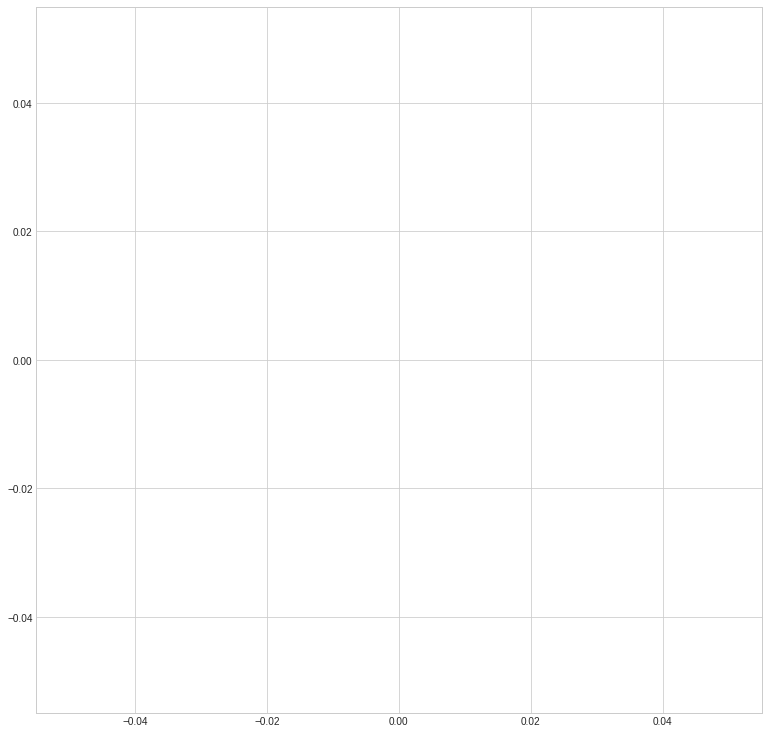

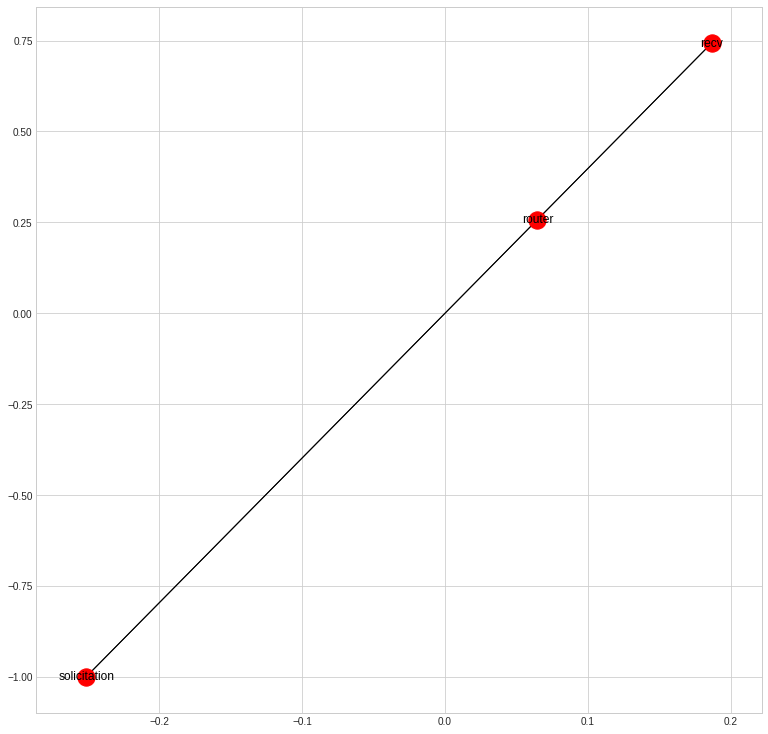

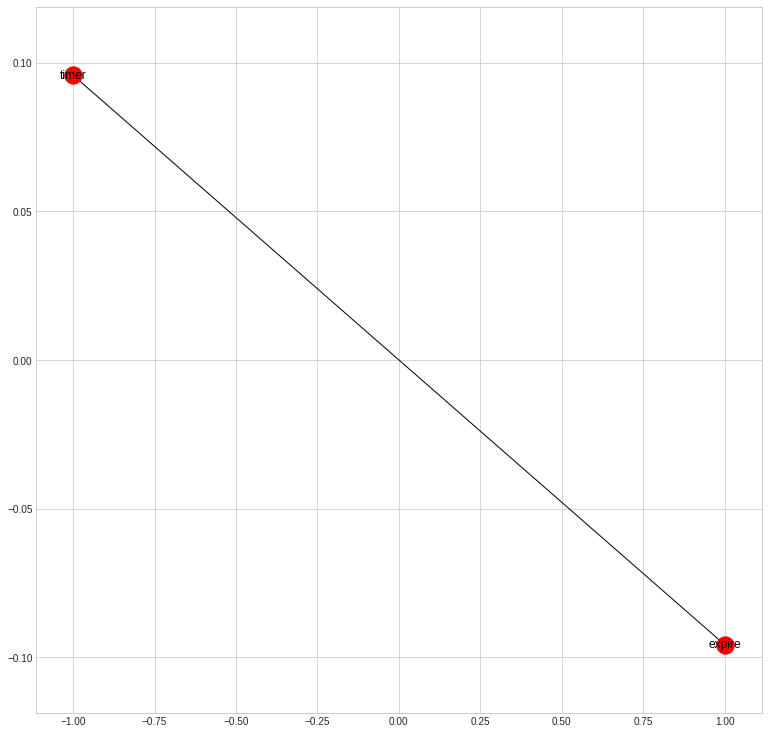

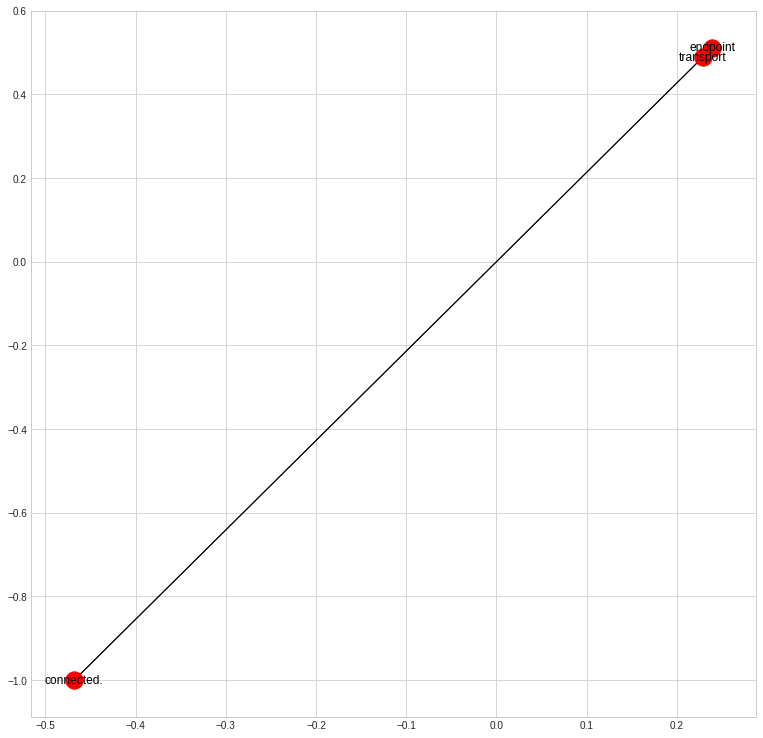

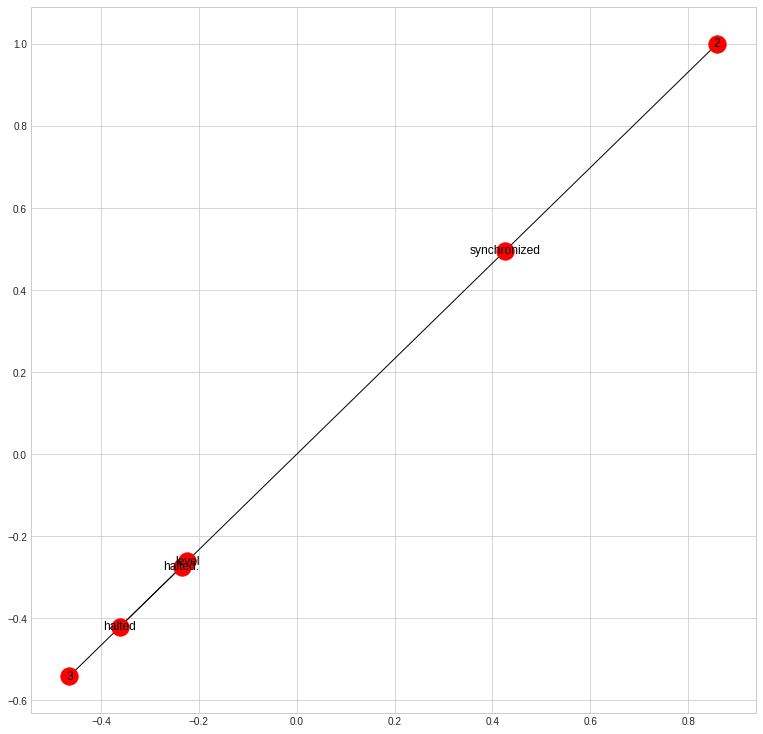

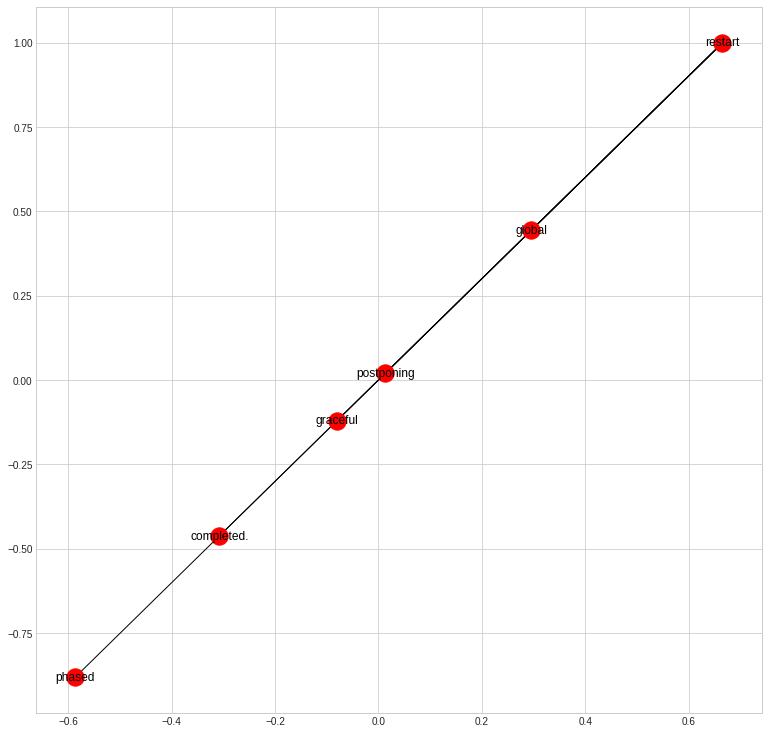

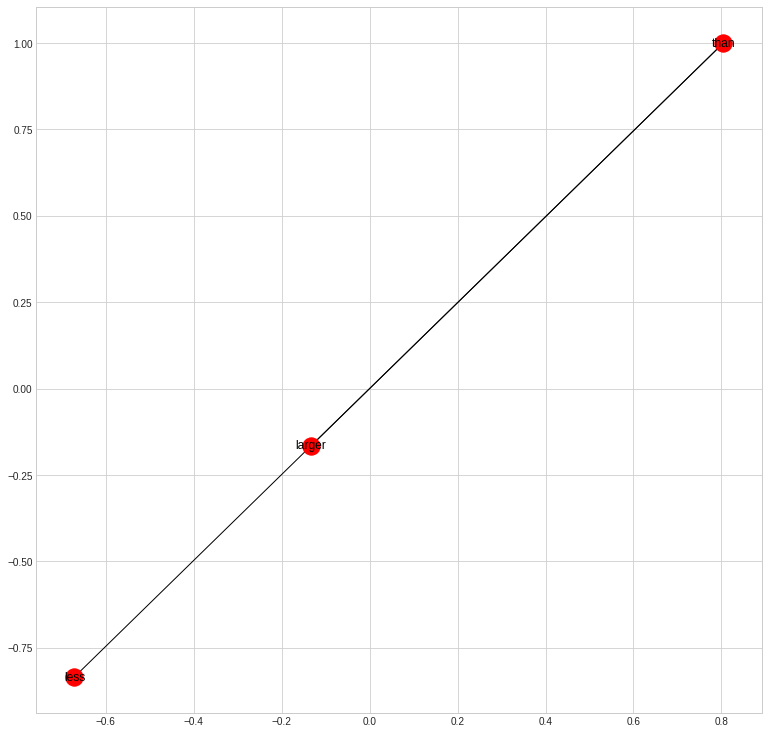

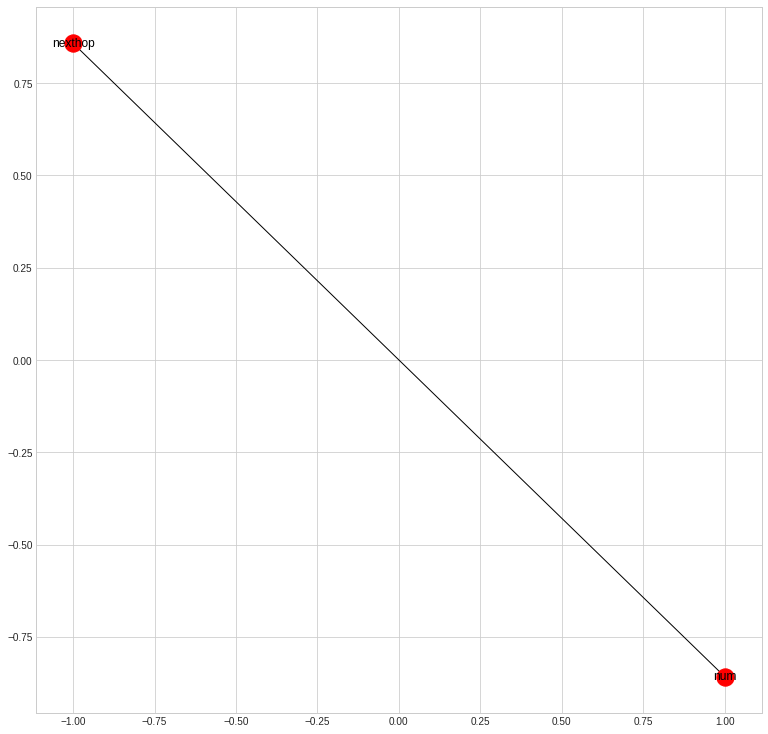

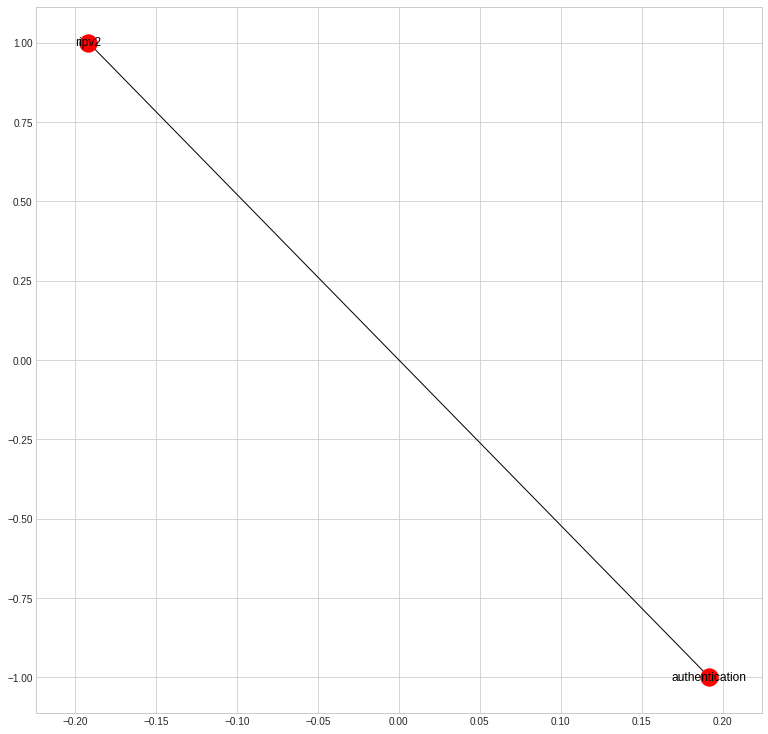

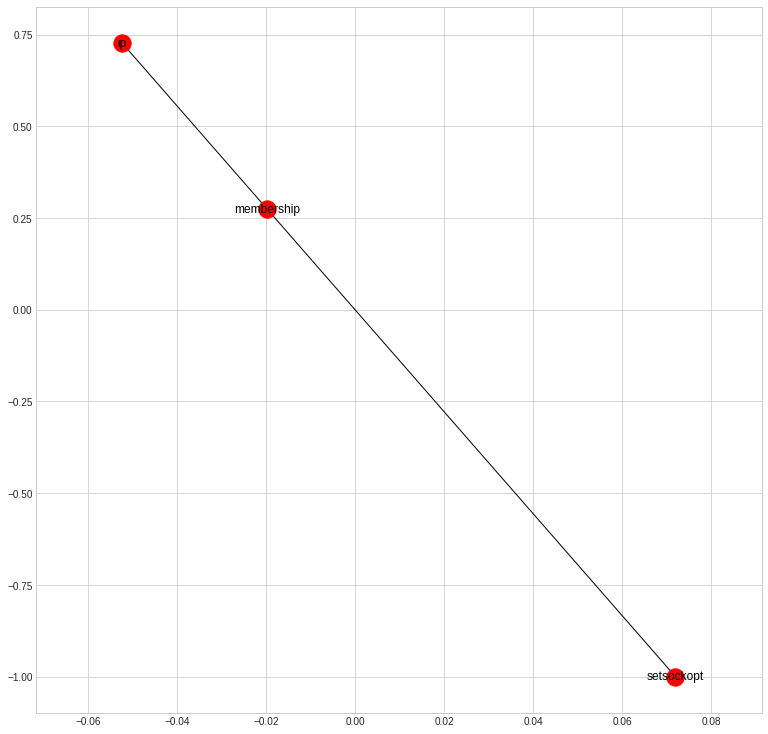

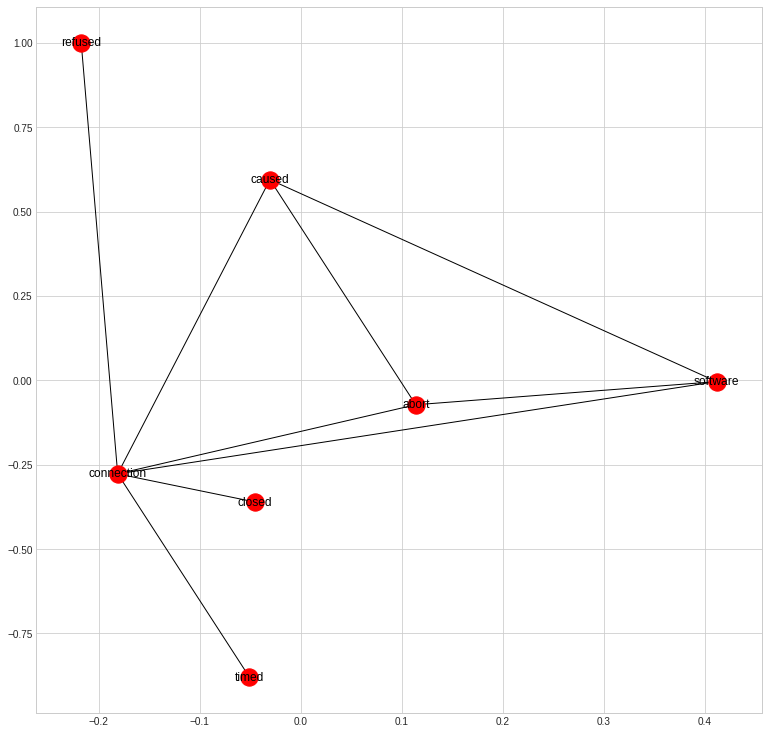

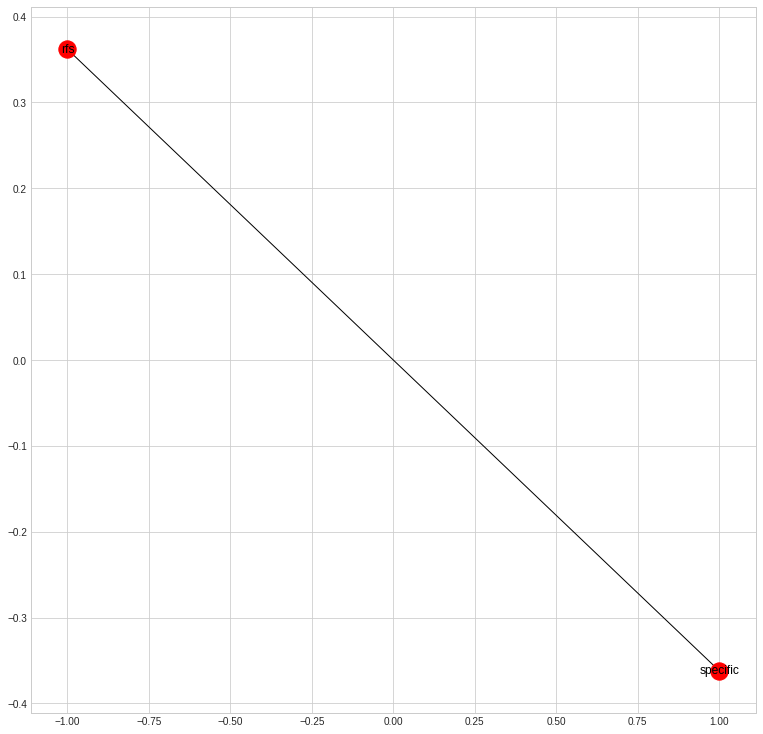

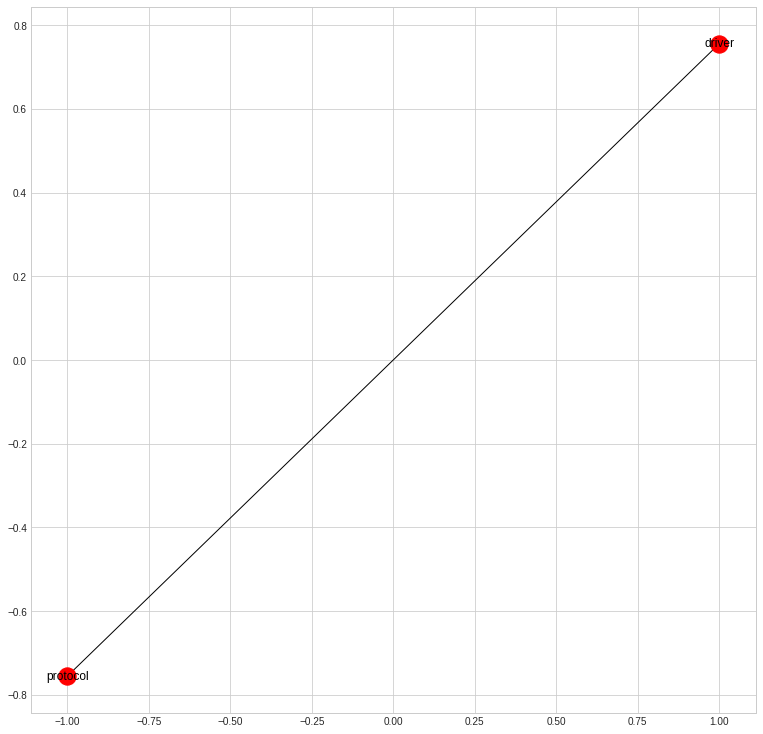

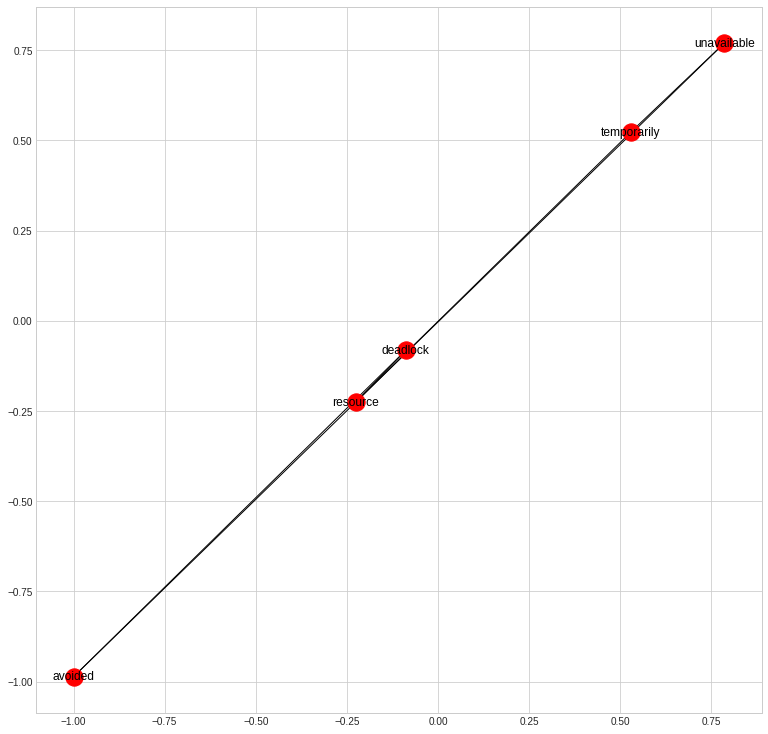

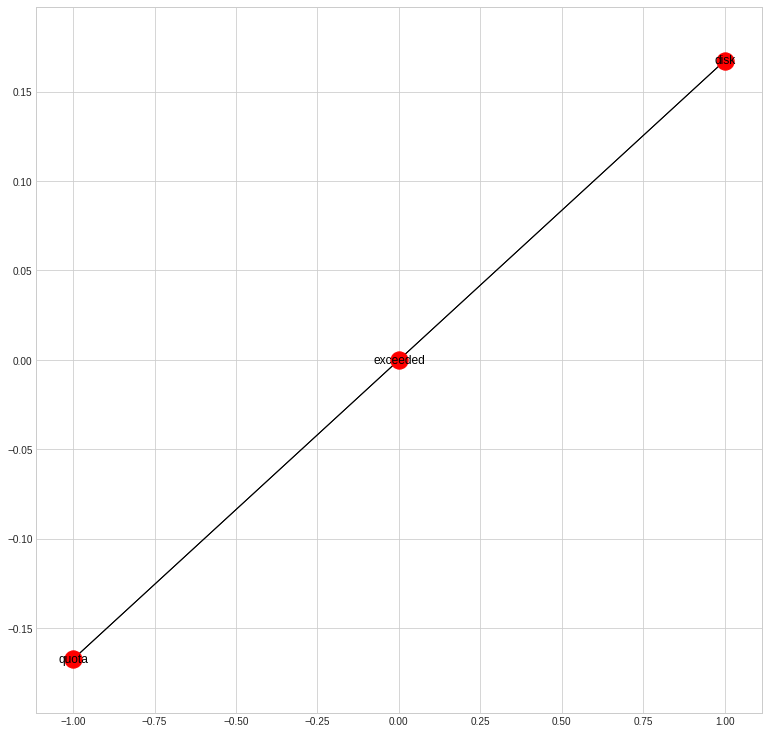

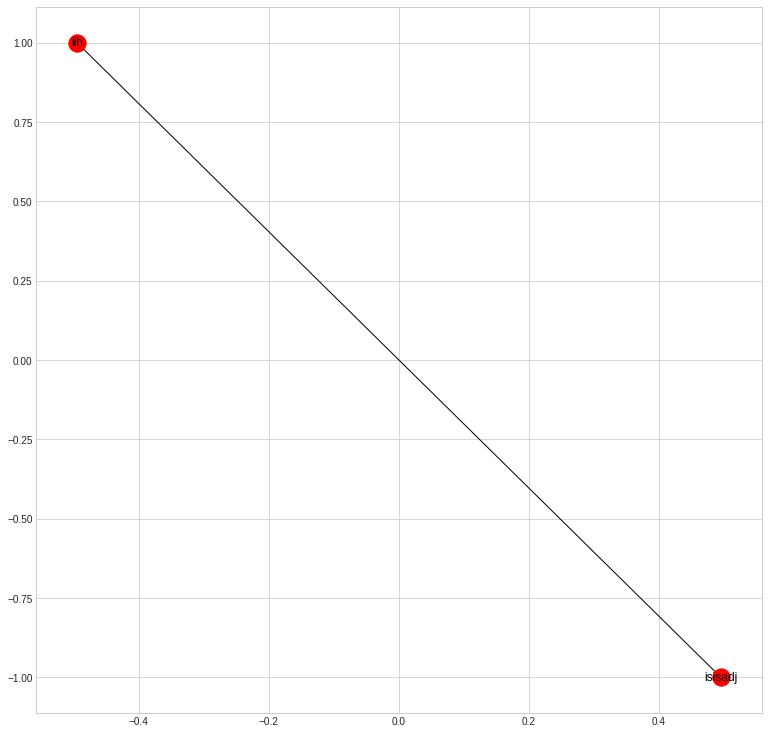

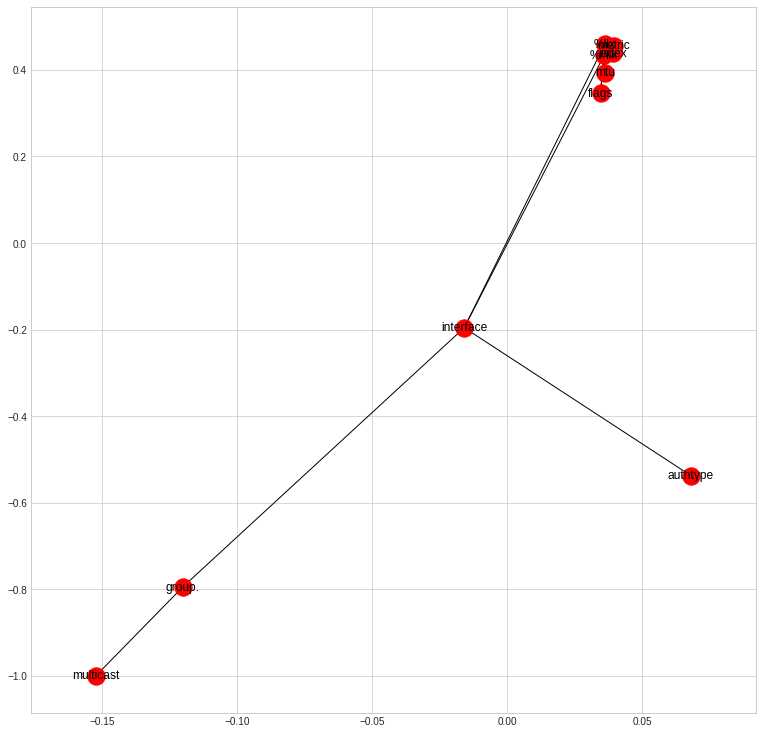

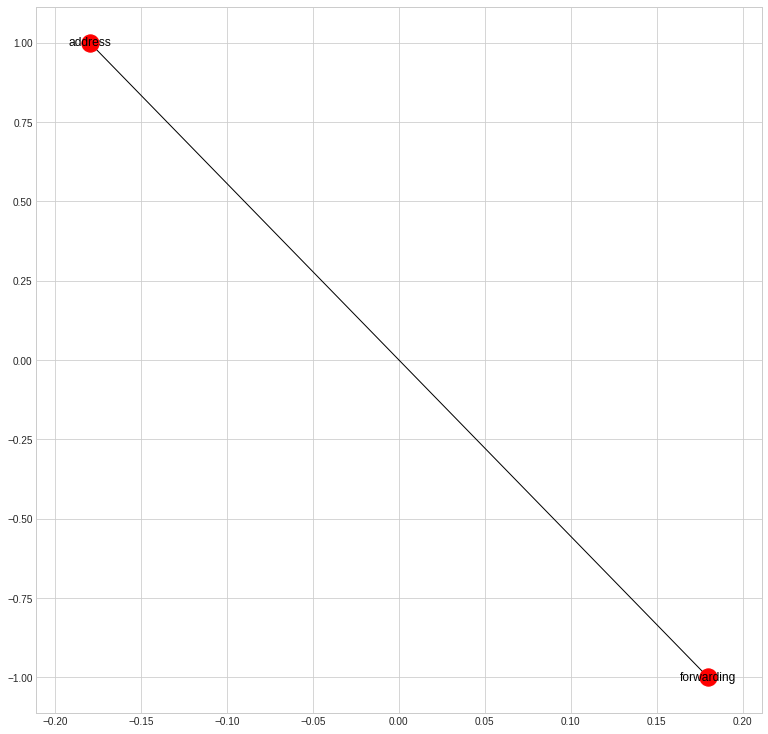

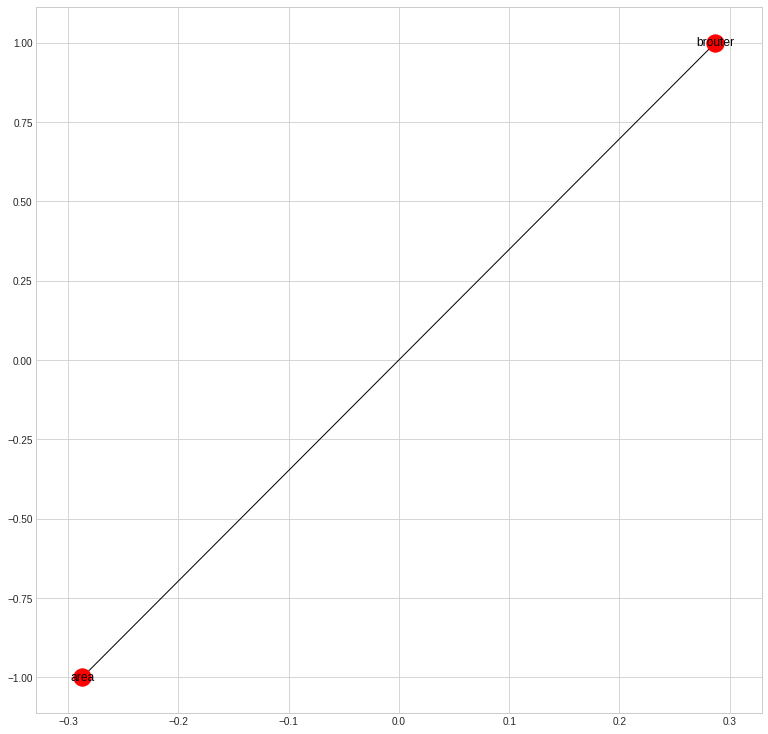

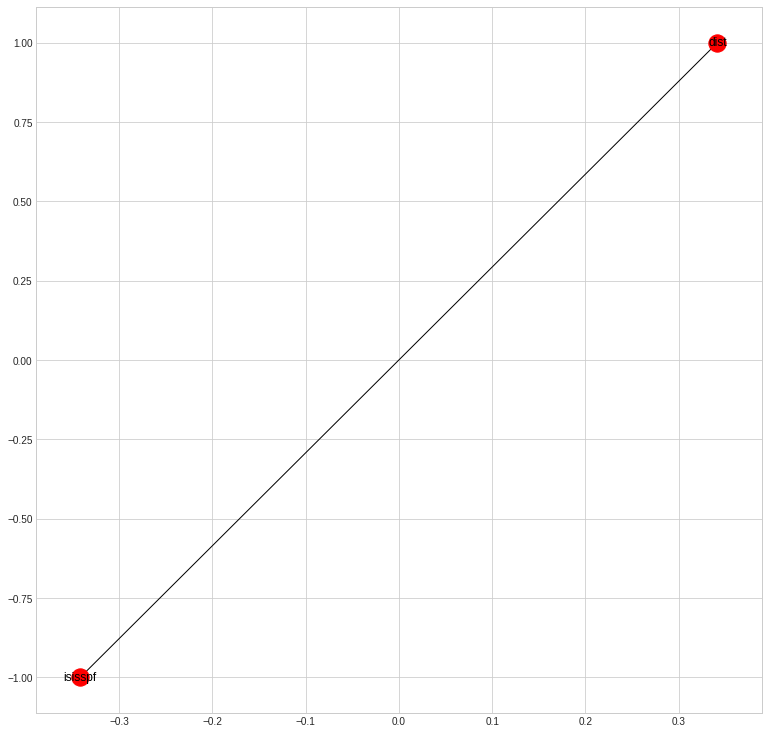

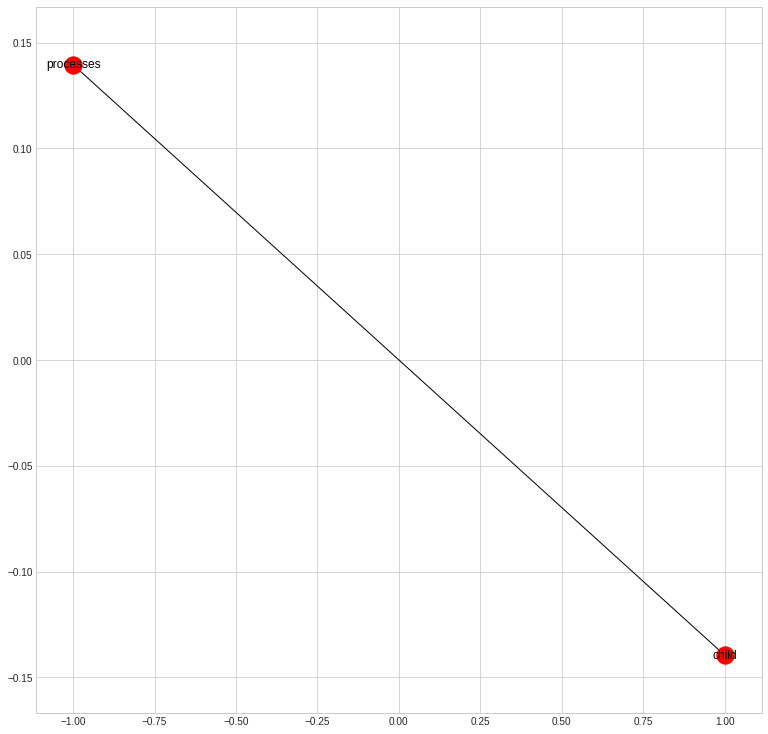

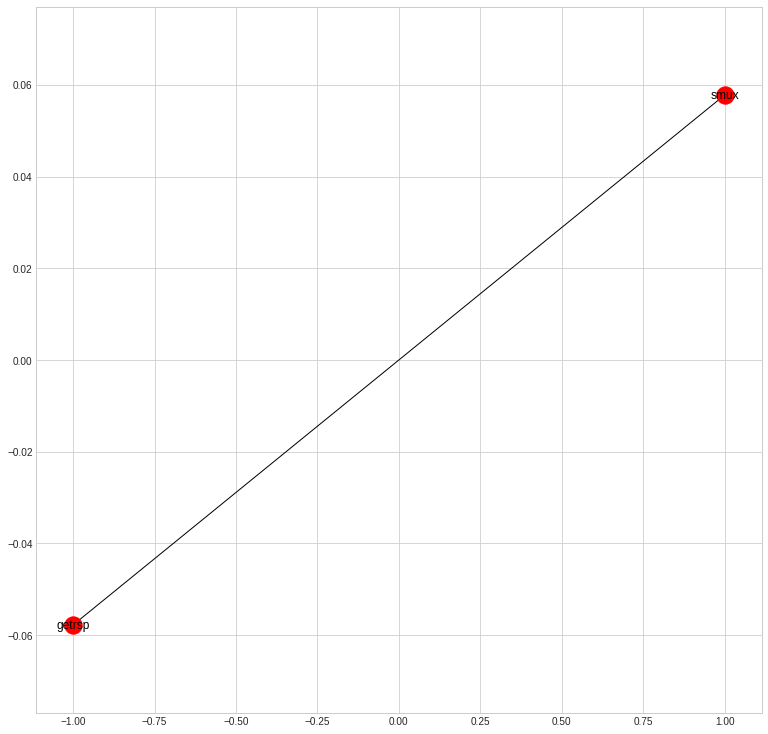

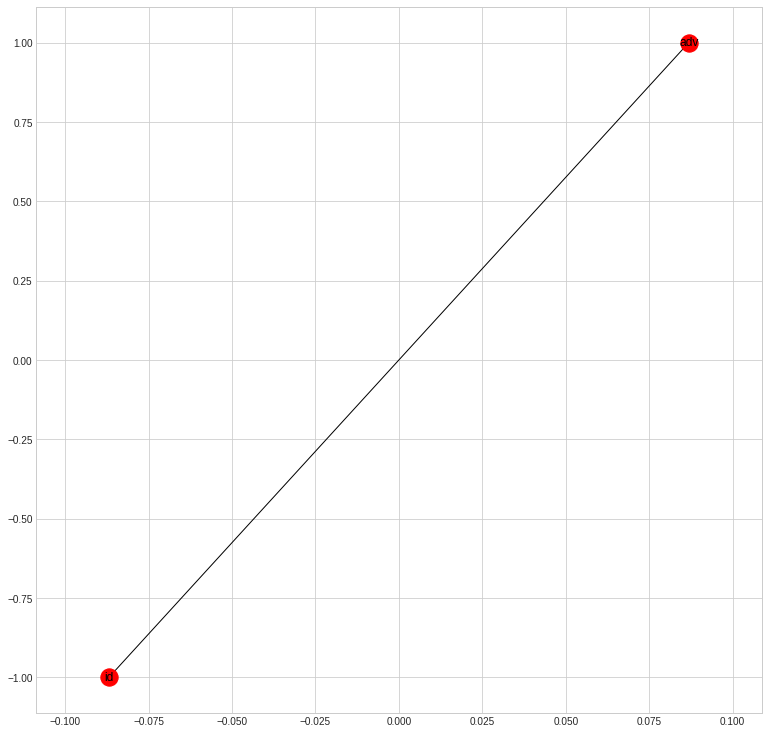

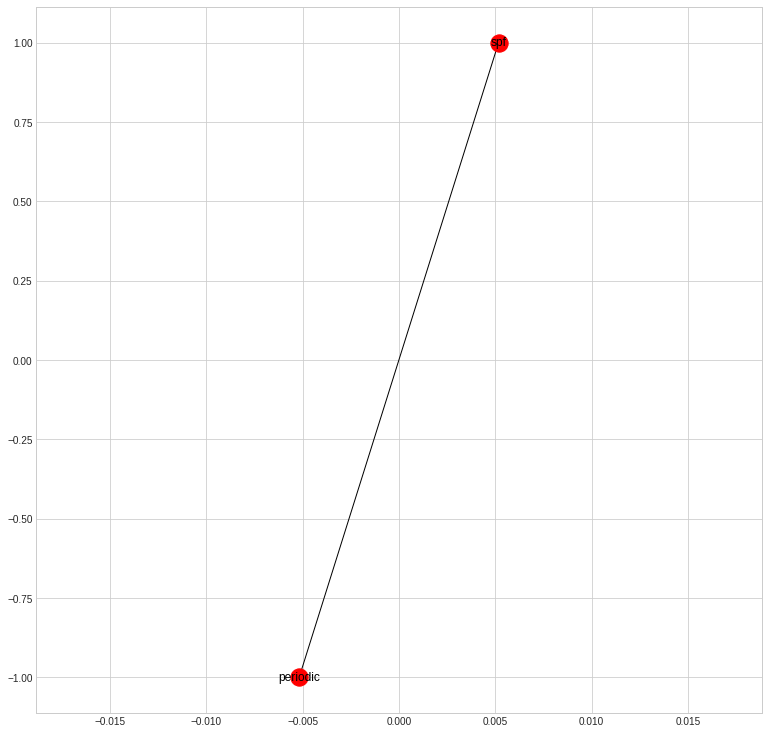

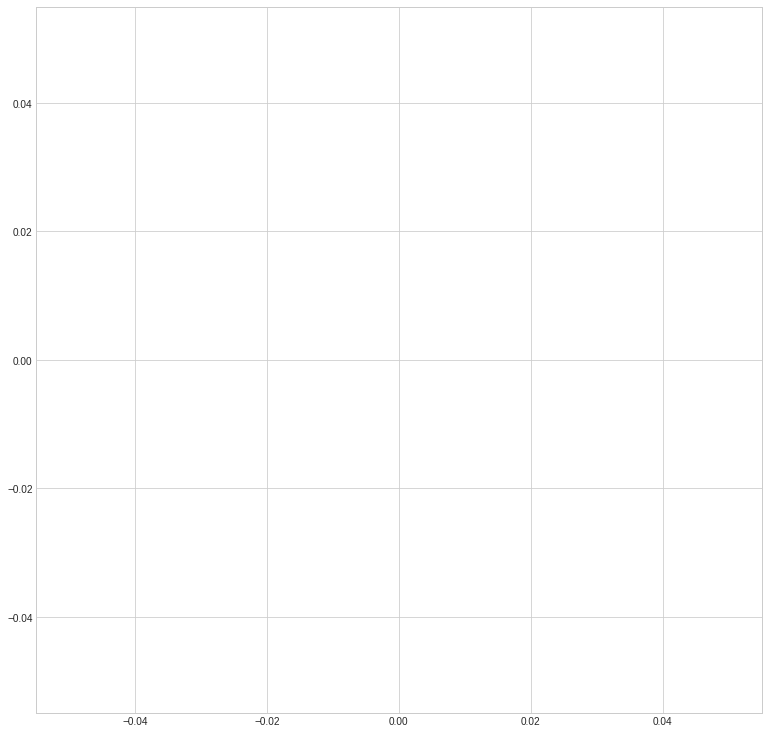

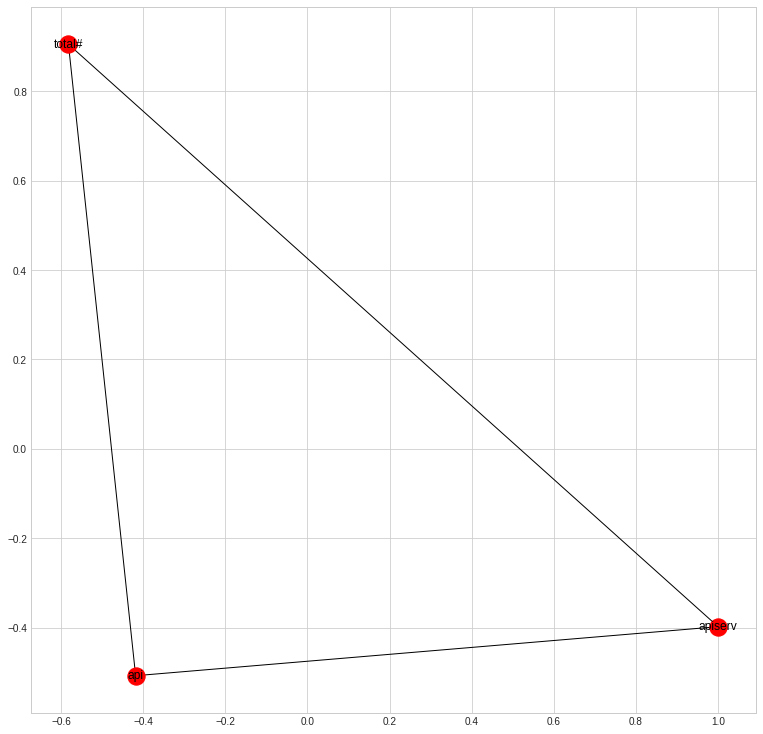

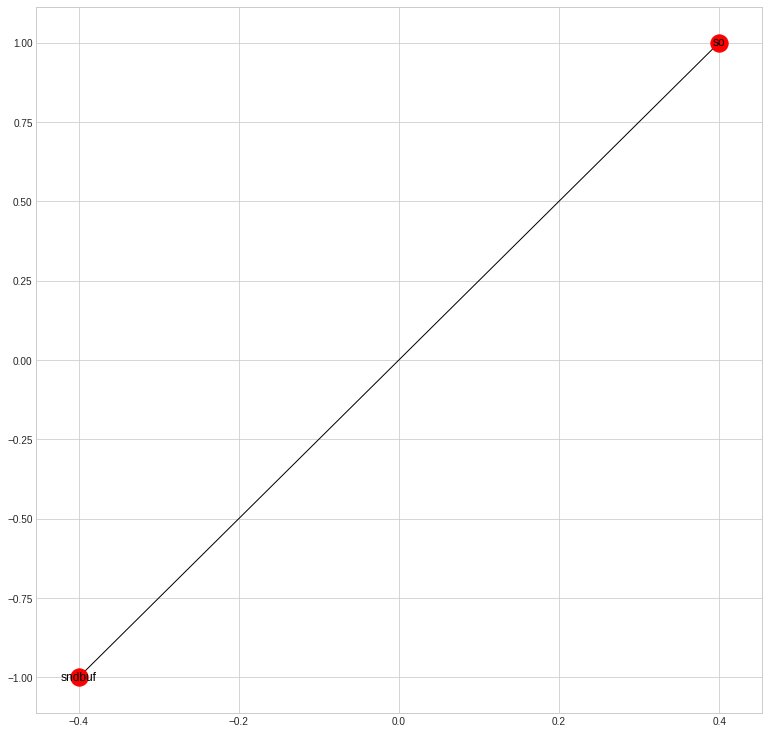

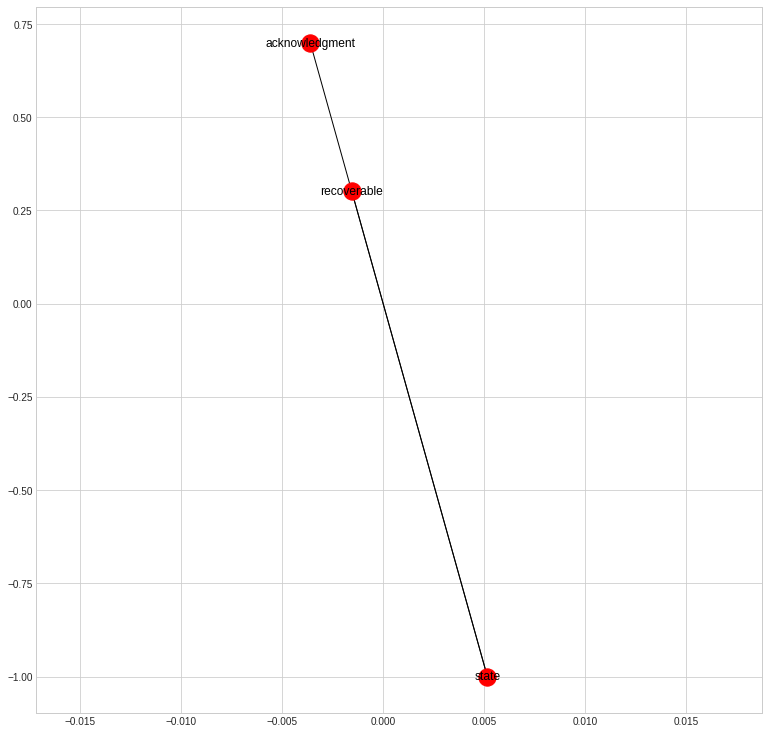

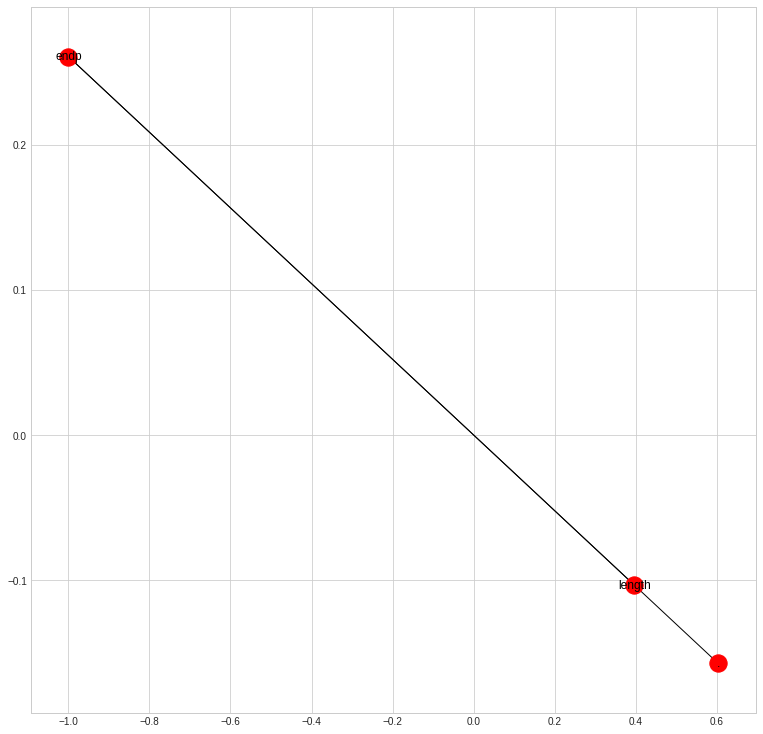

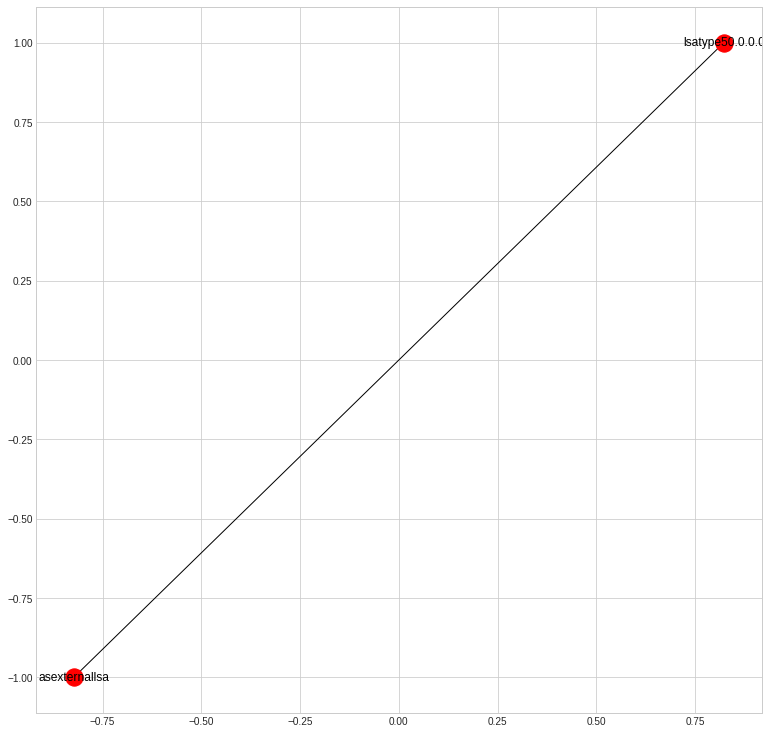

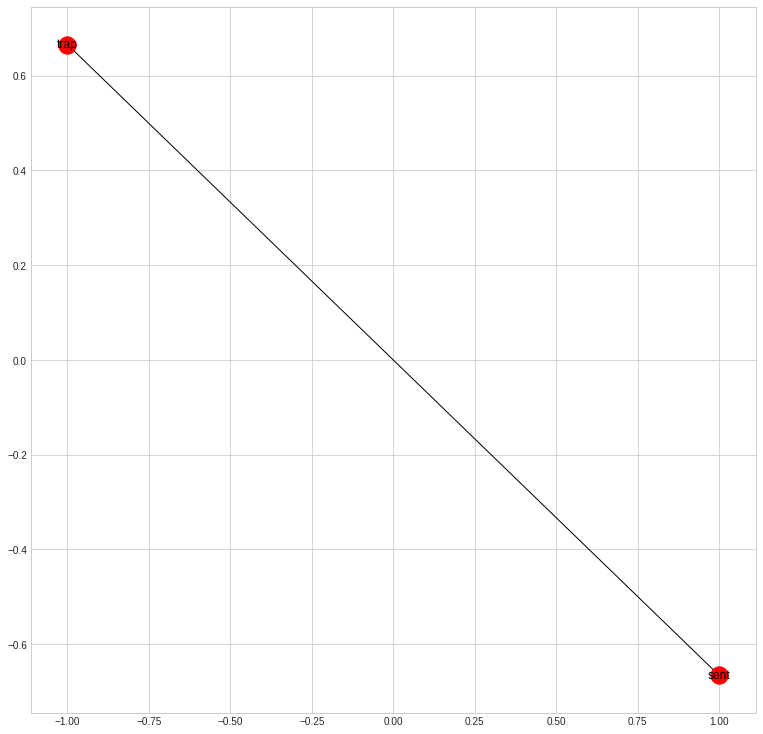

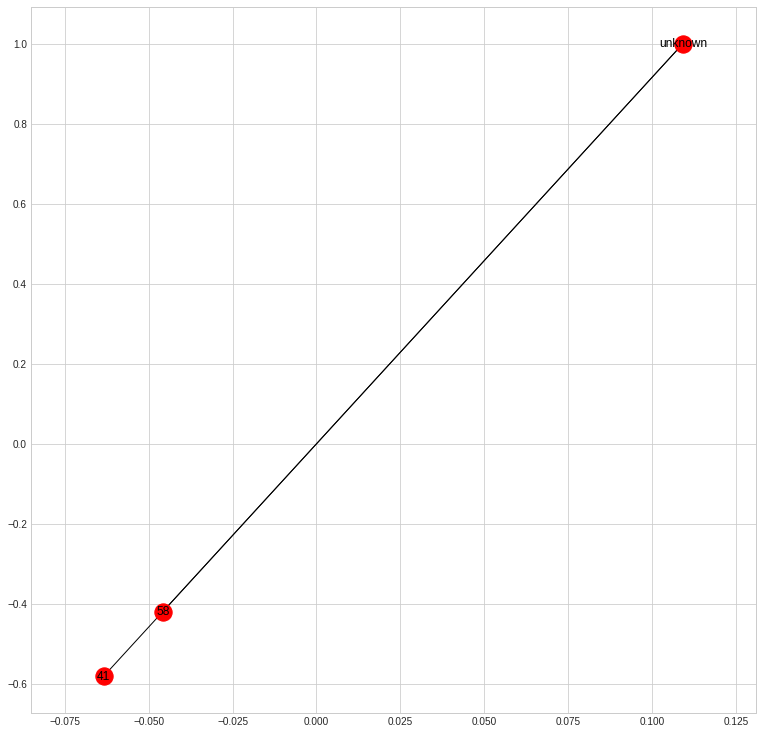

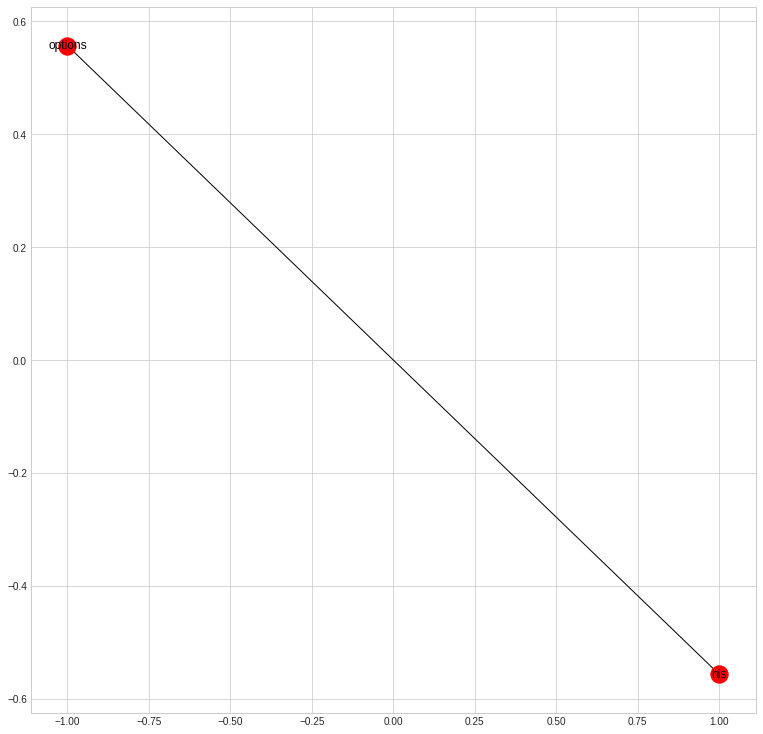

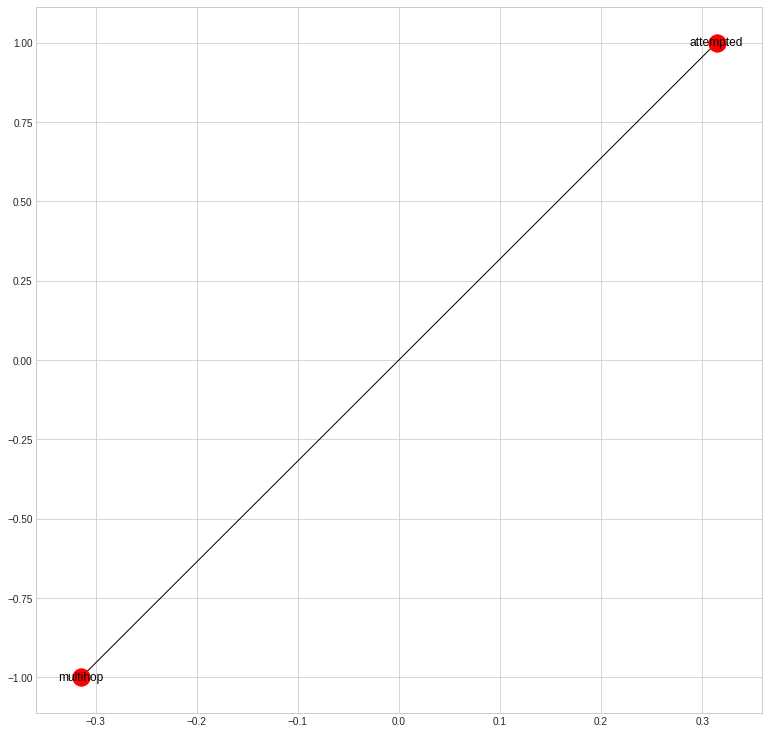

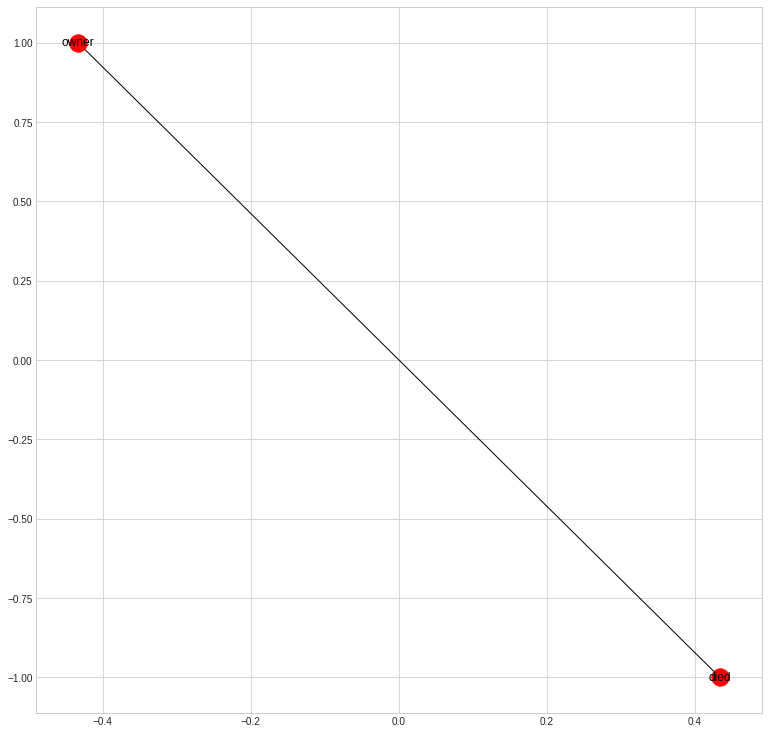

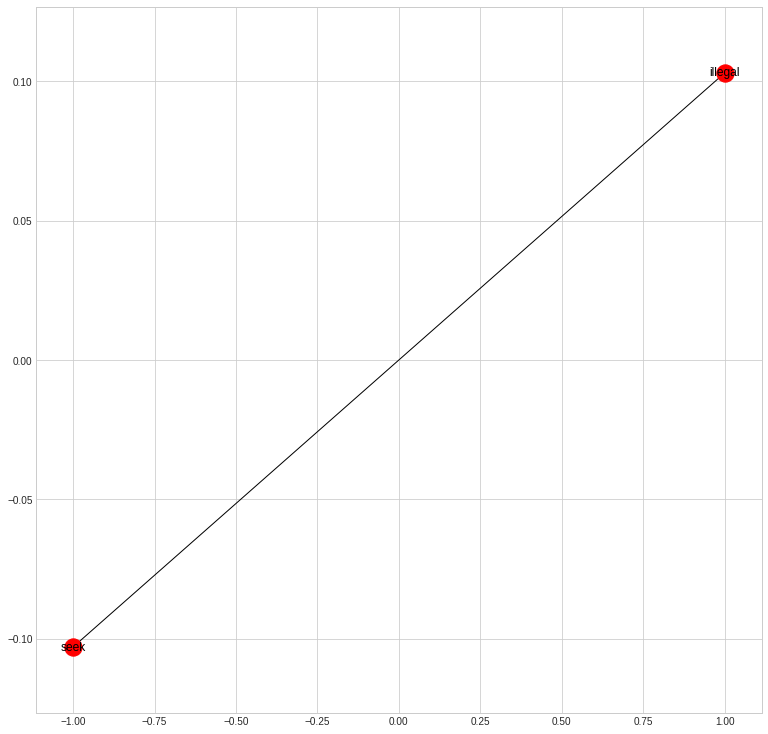

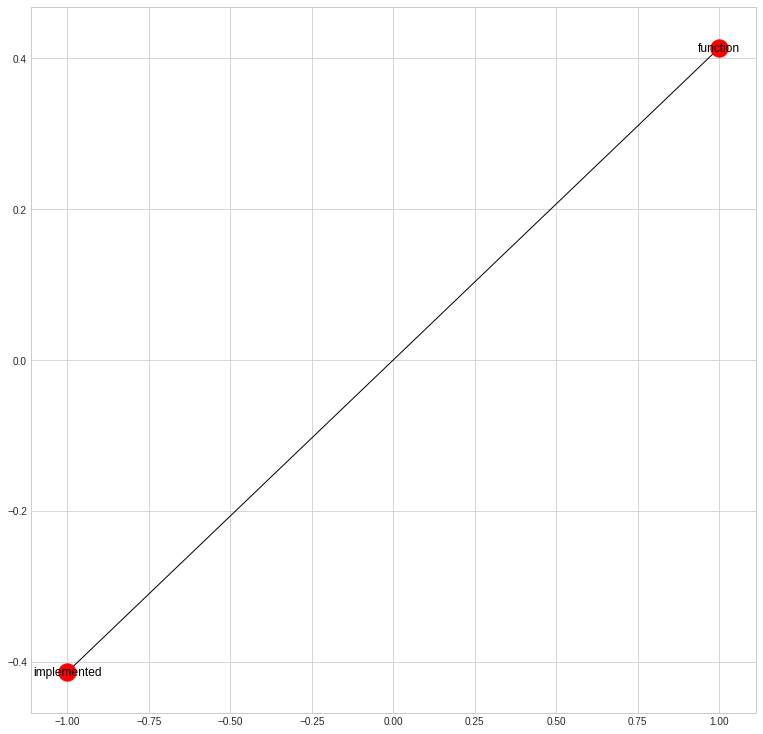

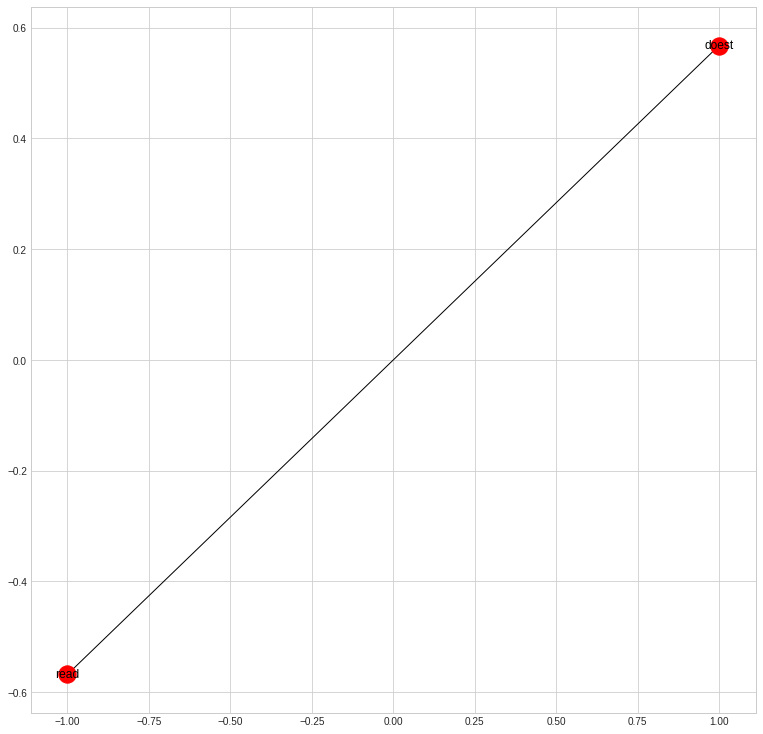

In [104]:
for i, nodes in enumerate(list(nx.connected_components(G))):
    H = G.copy()
    H.remove_nodes_from(G.nodes - nodes)
    plt.figure(figsize=(13, 13))
    pos = nx.spring_layout(H, k=0.001)
    nx.draw_networkx(H, pos=pos)
    plt.show()
    
    json_data = nx.node_link_data(H)
    f = open("./d3/vyos_nx_{}.json".format(i), "w")
    json.dump(json_data, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    f.close()

In [ ]:
pos = nx.spring_layout(G, k=0.0001)

plt.figure(figsize=(13, 13))
nx.draw_networkx(G, pos=pos)
plt.show()

# VyOS + JUNOS

- 混ぜてみる．
- 分離するのかどうか

In [11]:
def remove_symbols(value):
    return value.replace('-', '').replace('+', '').replace("'",'').replace('>','').replace('<','').replace('=','').replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('**', '').replace(':', '').replace(',', '').replace("_", " ")

def string_to_corpus(lt, max_len=None):
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    if max_len != None:
        split_words = split_words[:max_len] # 前方のみ残す

    return split_words

def remove_error_words(split_words):
    for error_word in error_words:
        if error_word == split_words[-len(error_word):]:
            return split_words[:-len(error_word)] ## 前方の単語が抜かれてしまわないようにする
    return split_words

In [12]:
## JUNOS vocab

with open("./lt.json", "r") as f:
    raw_lt = json.load(f)
    
lt_per_cat = {}
for ltid, value in raw_lt.items():
    if value['cat'] not in lt_per_cat:
        lt_per_cat[value['cat']] = [value['lt']]
    else:
        lt_per_cat[value['cat']].append(value['lt'])
        
words_per_cat = dict()
for cat, lts in lt_per_cat.items():
    corpus = []
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
        split_words = [t.lower() for t in split_words if t != '']
        corpus.extend(split_words)
    words_per_cat[cat] = corpus
    
junos_all_words = list(set([word for cat, words in words_per_cat.items() for word in words]))
junos_word2id = {w:i for i, w in enumerate(junos_all_words)}
junos_id2word = {v:k for k,v in junos_word2id.items()}

In [13]:
## VyOS vocab

with open("./vyos_logs/tpl_all_uniq", "r") as f:
    raw_vyos = f.readlines()

words_per_lt = []
for lt in raw_vyos:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    words_per_lt.append(split_words)
    
## エラー文の抽出
error_words = []

for lt in raw_vyos[2599:2733]:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    
    split_words = [w for w in split_words][5:]
    error_words.append(split_words)
    
vy_all_words = list(set([word for words in words_per_lt for word in words]))
vy_word2id = {w:i for i, w in enumerate(vy_all_words)}
vy_id2word = {v:k for k,v in vy_word2id.items()}

In [14]:
## merge word dict

all_words = list(set(junos_all_words + vy_all_words))
word2id = {w:i for i, w in enumerate(all_words)}
id2word = {v:k for k,v in word2id.items()}

In [15]:
## generate JUNOS corpus

corpus = []
for cat, lts in lt_per_cat.items():
    for lt in lts:
        words = [remove_symbols(t) for t in lt.split()]
        split_words = []
        for w in words:
            if len(w.split()) > 1: # さらに分割できる場合
                split_words.extend(w.split())
            else:
                split_words.append(w)
        split_words = [t.lower() for t in split_words if t != '']
        split_words = split_words[:10] # 前方のみ残す
        lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
        corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])
        
# 単語のカウント
word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    word_cnt[id2word[wid]] = cnt
    

STOP_WORDS = [word2id[i] for i in ['and', 'of', 'from', 'to', 'in', 'on', 'is', 'for', 'or']]
    
tmp = []
eval_corpus = []
eval_corpus_ltids = []

for ltid, i in enumerate(corpus):
    if word2id['ui'] not in [j[0] for j in i]: # uiを弾く(550番)
        i = [j for j in i if j[0] not in STOP_WORDS]
        tmp.append(tuple(sorted(i)))
        eval_corpus.append(i)
        eval_corpus_ltids.append(ltid)
    
set_corpus = list(set(tmp))

In [16]:
## generate VyOS corpus

vy_corpus = []
vy_tmp_corpus = []
for lt in raw_vyos:
    words = [remove_symbols(t) for t in lt.split()]
    split_words = []
    for w in words:
        if len(w.split()) > 1: # さらに分割できる場合
            split_words.extend(w.split())
        else:
            split_words.append(w)
    split_words = [t.lower() for t in split_words if t != '']
    split_words = remove_error_words(split_words)
    vy_tmp_corpus.append(split_words)
    
for i in range(18145,18279):
    vy_tmp_corpus[i] = ['cant',
      'setsockopt',
      'ip',
      'add',
      'membership',
      'fd',
      'addr',
      'ifindex',
      'alldrouters']

for i in range(18279,18413):
    vy_tmp_corpus[i] = ['cant',
      'setsockopt',
      'ip',
      'add',
      'membership',
      'fd',
      'addr',
      'ifindex',
      'allspfrouters']
    
uniq_corpus = list(set([tuple(i) for i in vy_tmp_corpus]))
for split_words in uniq_corpus:
    lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
    vy_corpus.append([(tid, cnt) for tid, cnt in lt_word_id_cnt.items()])
    
# 単語のカウント
vy_word_cnt = {}
for wid, cnt in sorted(collections.Counter([c[0] for s in vy_corpus for c in s]).items(), key= lambda x: x[1])[::-1]:
    vy_word_cnt[id2word[wid]] = cnt
    
stop_words = ["failed", "is", "cant", "not", "error", "to", "on", "of", "by", "for", "a", "from", "the", "with", "\\n", 'or', 'in']
    
## stop word 除去
vy_eval_corpus = []
for c in vy_corpus:
    vy_eval_corpus.append([cc for cc in c if id2word[cc[0]] not in stop_words])

In [31]:
error_words

[['.lib', 'section', 'in', 'a.out', 'corrupted'],
 ['accessing', 'a', 'corrupted', 'shared', 'library'],
 ['address', 'already', 'in', 'use'],
 ['address', 'family', 'not', 'supported', 'by', 'protocol'],
 ['advertise', 'error'],
 ['argument', 'list', 'too', 'long'],
 ['attempting', 'to', 'link', 'in', 'too', 'many', 'shared', 'libraries'],
 ['bad', 'address'],
 ['bad', 'file', 'descriptor'],
 ['bad', 'font', 'file', 'format'],
 ['bad', 'message'],
 ['block', 'device', 'required'],
 ['broken', 'pipe'],
 ['can', 'not', 'access', 'a', 'needed', 'shared', 'library'],
 ['cannot', 'allocate', 'memory'],
 ['cannot', 'assign', 'requested', 'address'],
 ['cannot', 'exec', 'a', 'shared', 'library', 'directly'],
 ['cannot', 'send', 'after', 'transport', 'endpoint', 'shutdown'],
 ['channel', 'number', 'out', 'of', 'range'],
 ['communication', 'error', 'on', 'send'],
 ['connection', 'refused'],
 ['connection', 'reset', 'by', 'peer'],
 ['connection', 'timed', 'out'],
 ['destination', 'address', 're

In [30]:
for i in uniq_corpus:
    print(" ".join(i))

lsatype no associated lsdb!
smux connection closed
vtysh accept could not set vty socket to nonblocking link has been severed closing
vtysh accept could not set vty socket to nonblocking memory page has hardware error closing
cant fopen pid lock file invalid argument continuing
panic !! lsdbcount real
undersized b trailing # lsa header
vtysh accept could not set vty socket to nonblocking broken pipe closing
ospf intra add stub start
error not a xenix named type file type seq pid
lsarefresh ospf refresher register lsa setting refresh list on lsa slod
link data
smux get message parse len %zd
message zebra interface address add / on
opaquelsa now get operational!
vtysh accept could not set vty socket to nonblocking file name too long closing
ripng recvfrom failed key has been revoked.
isisspf area does not share level
ospf abr announce network start
as4 capability has incorrect data length
local interface ip addresses
could not raise privs
vtysh accept could not set vty socket to nonblock

In [17]:
merged_corpus = vy_eval_corpus + set_corpus

In [18]:
lda = gensim.models.ldamodel.LdaModel(
                                      corpus=merged_corpus,
                                      chunksize=5,
                                      num_topics=40, 
                                      id2word=id2word, 
                                      minimum_probability=1e-8, 
                                      #gamma_threshold=1e-5,
                                      #eval_every=10,
                                      iterations=100,
#                                       alpha='auto', 
#                                       eta='auto', 
                                      decay=1.0,
                                      passes=1,
                                      per_word_topics=True)

In [25]:
inf_topic_words = {}
for topic in range(lda.num_topics):
    print(topic, [id2word[i[0]] for i in lda.get_topic_terms(topic)])
    inf_topic_words[topic] = [id2word[i[0]] for i in lda.get_topic_terms(topic)]

0 ['event', 'neighbor', 'mcsn', 'updown', 'connect', 'pointtopoint', 'than', 's', 'packetdd', 'exchange']
1 ['area', 'lsp', 'level', 'circuit', 'l', 'at', 'isisspf', 'isisupd', 'routerlsa', 'looking']
2 ['process', 'status', 'change', 'rt', 'with', 'warning', 'skipping', 'isissnp', 'exited', 'jspec']
3 ['socket', 'set', 'could', 'accept', 'closing', 'vty', 'nonblocking', 'vtysh', 'broadcast', 'cannot']
4 ['already', 'spf', 'calculation', 'enabled', 'running', 'scheduled', 'there', 'listen', 'periodic', 'summarylsa']
5 ['no', 'route', 'nexthop', 'delete', 'found', 'lsatype', 'originate', 'changed', 'entry', 'available']
6 ['index', 'refresh', 'request', 'list', 'register', 'instance', 'code', 'asexternallsa', 'setting', 'lsarefresh']
7 ['rpd', 'bgp', 'rcvd', 'mismatch', 'due', 'stp', 'errors', 'msdp', 'receive', 'isisadj']
8 ['recv', 'solicitation', '2', 'dropped', 'supported.', 'child', '3', 'requested', 'specific', 'pdu']
9 ['send', 'endpoint', 'transport', 'discard', 'after', 'an', '

In [20]:
## show results

inf_per_cat = {}
for cat,lts in lt_per_cat.items():
    print(cat)
    inf_per_cat[cat] = []
    for lt in lts:
        c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=7)]).items())
        topic_dist, word_topic, word_topic_dist = lda[c]
        inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
        inf_per_cat[cat].append(inf_topic)
        print("\t", inf_topic, ",", lt)

system(cron)
	 14 , /usr/sbin/cron[**]: (root) CMD (newsyslog)
	 14 , /usr/sbin/cron[**]: (**) CMD (adjkerntz -a)
	 14 , /usr/sbin/cron[**]: (**) CMD (/usr/sbin/check-support -l)
	 14 , ** /usr/sbin/cron[**]: (**) CMD (newsyslog)
	 14 , ** /usr/sbin/cron[**]: (**) CMD (adjkerntz -a)
	 14 , ** /usr/sbin/cron[**]: (**) CMD (/usr/sbin/check-support -l)
	 14 , /usr/sbin/cron[**]: (root) CMD ( /usr/libexec/atrun)
	 14 , /usr/sbin/cron[**]: (*system*) RELOAD (/etc/crontab)
network(lacp)
	 36 , mib2d[**]: lacp info not found for ifl:**
	 39 , mib2d[**]: cleared lacp info not found for ifl:**
	 39 , ifinfo: lacp info not found for ifl:**
	 39 , ifinfo: cleared lacp info not found for ifl:**
	 39 , /kernel: KERN_LACP_INTF_STATE_CHANGE: lacp_update_state_userspace: new state is ** cifd **
	 39 , lacpd[**]: LACPD_TIMEOUT: **: lacp current while timer expired current Receive State: CURRENT
service(ntp)
	 2 , xntpd[**]: NTP Server Unreachable
	 38 , xntpd[**]: kernel time sync enabled **
	 38 , xnt

	 25 , ** mgd[**]: UI_LOGIN_EVENT: User '**' login, class '**' **[**], ssh-connection '', client-mode 'junoscript'
	 8 , ** mgd[**]: UI_CHILD_START: Starting child '**'
	 8 , ** mgd[**]: UI_CHILD_STATUS: Cleanup child '**', PID **, status **
	 25 , ** mgd[**]: UI_DBASE_LOGIN_EVENT: User '**' entering configuration mode
	 26 , ** mgd[**]: UI_DBASE_LOGOUT_EVENT: User '**' exiting configuration mode
	 25 , ** mgd[**]: UI_LOGIN_EVENT: User '**' login, class '**' [**], ssh-connection '', client-mode 'cli'
	 26 , mgd[**]: mgd UI_AUTH_EVENT: Authenticated user '**' at permission level '**'
	 25 , mgd[**]: mgd UI_LOGIN_EVENT: User '**' login, class '**' [**], ssh-connection '', client-mode 'cli'
	 26 , mgd[**]: mgd UI_CHILD_START: Starting child '**'
	 26 , mgd[**]: mgd UI_CHILD_STATUS: Cleanup child '**', PID **, status **
	 26 , mgd[**]: mgd UI_LOGOUT_EVENT: User '**' logout
	 25 , mgd[**]: mgd UI_LOGIN_EVENT: User '**' login, class '**' [**], ssh-connection '** ** ** **', client-mode 'cli'


	 26 , cmtfpc_restart_normal: connected to pfe_man after ** retries
	 15 , cmsfpc_restart_normal: Connected to pfe_man after ** retries
	 12 , /kernel: pfe_send_failed(index **, type **), err=**
	 22 , pfed: device getnext failed: Invalid argument
	 28 , Host Loopback:HOST LOOPBACK WEDGE DETECTED IN PFE **
	 28 , Host Loopback:Clearing Host Loopback Wedge on PFE **
	 36 , pfed: ifl getnext failed: Invalid argument
	 24 , ** PFE[**]Aliveness Turning Destination ** off
	 24 , fpc11 PFE[**]Aliveness Turning Destination ** off
	 24 , fpc1 PFE[**]Aliveness Turning Destination ** off
	 36 , ** PFEMAN: Session manager active
	 38 , ** PFEMAN: pfeman_start_service_bulkget
	 26 , ** cmtfpc_restart_normal: connected to pfe_man after ** retries
	 15 , ** CMT: PFE ASIC initialization complete
	 38 , ** PFEMAN: NPC sent Resync request to Master
	 38 , ** PFEMAN: received Resync complete.
	 15 , ** cmtfpc_npc_online_vector: Estd peering with pfe_man after ** retries (** each)
	 24 , ** PFE[**]Aliven

	 34 , [**]: EVT ** ** ** PORT ** ** **:** Error detected on the port.
	 27 , [**]: EVT ** ** ** PORT ** ** **:** Many failures occurred in receiving frames to the targeted port due to the port troubles. Execute the Line tests to check the port condition.
	 28 , [**]: EVT ** ** ** PORT MGMT ** ** **:** Port up.
	 30 , [**]: EVT ** ** ** PORT MGMT ** ** **:** Error detected on the port.
	 27 , [**]: EVT ** ** ** PORT ** ** **:** Many failures occurred in sending frames to the targeted port due to the port troubles. Execute the Line tests to check the port condition.
	 27 , ** [**]: EVT ** ** ** PORT ** ** **:** Port enabled administratively.
	 28 , ** [**]: EVT ** ** ** PORT ** ** **:** Port up.
mgmt(config)
	 16 , mgd[**]: UI_COMMIT: User '**' requested 'commit' operation (comment: none)
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' deactivate: [interfaces ** unit **]
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' activate: [interfaces ** unit **]
	 38 , rpd[**]: Synchronized commit pro

	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [routing-options static route ** preference]
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [routing-options aggregate route **]
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [routing-options static route **]
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [policy-options policy-statement ** term ** from community **]
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [policy-options policy-statement ** term ** then] <unconfigured> -> "**"
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [policy-options policy-statement ** term ** from ** ** orlonger next] <unconfigured> -> "**"
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' set: [policy-options policy-statement ** term ** from prefix-list **]
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [policy-options policy-statement ** term ** then metric] <**> -> "**"
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** family ** unicast prefix-limit maximum] 

	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** neighbor ** multihop ttl] <unconfigured> -> "**"
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** neighbor ** hold-time] <unconfigured> -> "**"
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** neighbor ** hold-time] "** -> "**"
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [protocols bgp group ** neighbor ** local-address] "** -> "**"
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [protocols igmp interface **]
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [protocols pim interface **]
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [logical-systems ** interfaces ** unit **] <unconfigured> -> "**"
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [logical-systems ** interfaces ** unit **] "**
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [system syslog file messages match] <unconfigured> -> "!(.*PCI INFO: **:**:**:** Correctable Counts.*)"
	 26 , mg

	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [logical-systems ** protocols mpls interface **]
	 26 , mgd[**]: UI_CFG_AUDIT_OTHER: User '**' delete: [forwarding-options **]
	 3 , mgd[**]: UI_CFG_AUDIT_SET: User '**' set: [interfaces ** framing] <unconfigured> -> "**"
interface(agg)
	 34 , dcd[**]: ** : Warning: aggregated-ether-options link-speed no kernel value! default to **
	 34 , dcd[**]: ** : aggregated-ether-options link-speed set to kernel value of **
	 12 , /kernel: ae_link_op: link ** (lidx=**) detached from bundle **
	 12 , /kernel: ** leaves **
	 12 , /kernel: bundle **: bundle IFL state changed to **
	 12 , **: rpd[**]: Received MC_AE_OPTIONS TLV for intf device **; mc_ae_id **, status **
	 12 , mcsn[**]: Received MC_AE_OPTIONS TLV for intf device **; mc_ae_id **, status **
	 12 , /kernel: ae_link_op: link ** (lidx=**) attached to bundle **
	 12 , /kernel: ** joins **
	 12 , rpd[**]: Received MC_AE_OPTIONS TLV for intf device **; mc_ae_id **, status **
	 26 , [**]: 

	 39 , rpd[**]: EVENT <Add Bandwidth> index ** <Up Broadcast Multicast>
	 6 , rpd[**]: EVENT <Add> ** index ** <Up Broadcast Multicast>
	 30 , rpd[**]: EVENT <Add Bandwidth MTU Encapsulation> index ** <Broadcast Multicast>
	 30 , rpd[**]: EVENT <Add Bandwidth MTU Encapsulation> index ** <Broadcast Multicast> address #** **
	 39 , rpd[**]: EVENT <Add Bandwidth MTU> index ** <Broadcast Multicast>
	 0 , **: rpd[**]: EVENT <UpDown MTU> index ** <Up Broadcast Multicast>
	 0 , mcsn[**]: EVENT <UpDown MTU> index ** <Up Broadcast Multicast>
	 0 , mcsn[**]: EVENT <UpDown MTU> index ** <Up Broadcast Multicast> address #** **
	 0 , rpd[**]: EVENT <UpDown MTU> index ** <Up Broadcast Multicast>
	 6 , **: rpd[**]: EVENT Add ** index ** <Broadcast Multicast>
	 6 , rpd[**]: EVENT <Add> ** index ** <Broadcast Multicast> address #** **
	 6 , rpd[**]: EVENT <Flags> ** index ** <Broadcast Multicast> address #** **
	 6 , rpd[**]: EVENT Add ** index ** ** -> ** <Broadcast Multicast>
	 30 , **: rpd[**]: EVEN

	 7 , rpd[**]: RPD_OSPF_NBRDOWN: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to InActiveTimer (event reason: neighbor was inactive and declared dead)
	 7 , **:rpd[**]: RPD_OSPF_NBRUP: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 2WayRcvd (event reason: initial DBD packet was received)
	 7 , rpd[**]: RPD_OSPF_NBRUP: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 2WayRcvd (event reason: initial DBD packet was received)
	 7 , rpd[**]: RPD_OSPF_NBRDOWN: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 1WayRcvd (event reason: neighbor is in one-way mode)
	 7 , **:rpd[**]: RPD_OSPF_NBRDOWN: OSPF neighbor ** (realm ** ** area **) state changed from ** to ** due to 1WayRcvd (event reason: neighbor is in one-way mode)
network(rsvp)
	 7 , **:rpd[**]: RPD_RSVP_NBRDOWN: RSVP neighbor ** down on interface **, triggered by IGP neighbor down event
	 7 , **:rpd[**]: RPD_RSVP_NBRUP: RSVP neighbor

	 30 , cmtfpc_max6657_init: OK
	 14 , CMLC: Attempt **, proto(**) address **
	 34 , v_queue_create(qsize: **, max_buckets: **, default_max_tokens: **)
	 3 , v_queue_create: allocate vq, size: **
	 25 , v_queue_create: allocate vq_tb_list, size: **
	 25 , v_queue_create: allocate vq_entry_pool, size: **
	 38 , Initiated pfeman_service_thread
	 31 , Svc Thread: Create TCP(**) socket
	 37 , CLKSYNC: Established connection to Master, **
	 37 , CLKSYNC: master RE connection made
	 19 , L2ALM: Established connection to Master, **
	 27 , L2ALM master RE connection made
	 15 , MPC: Reset reason (**): Power on
	 30 , cmtfpc_create_asic_pio_handles entered, hostname (**)
	 30 , Creating trinity I2C dev for ** ** li=** i2=**
	 12 , Version ** by builder on ** ** UTC
	 4 , On-board NVRAM contains diagnostic information.
	 15 , SNTPD: Initial time of day set.
	 19 , QX ** is absent.
	 34 , CMT: cmtfpc_asic_init_pfe ** init (mah=**) called
	 21 , Calling **
	 2 , Aser: succesfully register Aser jspe

	 12 , /kernel: pmap_helper loaded (interface version **, syscall **)
	 15 , chas[**]: update_mb_pic_port_map: debug: pic slot = **, port = **, port_status = **
	 15 , chas[**]: cm_pic_port_map_info: Port Map Info for **:** sent
	 15 , chas[**]: XCVR: Freeing itable entry for xcvr index: ** port: **
	 15 , chas[**]: ifcm_ifd_remove_vector: ifd ** is_vcp ** peer **
	 15 , chas[**]: XCVR: Inserted itable entry at xcvr index: ** port: **
	 15 , chas[**]: IFCM: no handler for command subtype **
	 34 , chas[**]: All lion cubs not detected
	 36 , chas[**]: TASK_SCHED_SLIP: ** sec scheduler slip, user: ** sec ** usec, system: ** sec, ** usec
	 6 , chas[**]: ** errno:**, device:**
	 32 , chas[**]: CM_TSUNAMI (**): Failed to ** uplink sfp_link = **
	 26 , mgd[**]: /usr/libexec/ui/package -X **
	 26 , mgd[**]: /usr/libexec/ui/package -X validate **
	 26 , mgd[**]: /usr/libexec/ui/package -X update -no-validate **
	 12 , chas[**]: TASK_SIGNAL_TERMINATE: termination signal no- ** received
	 12 , c

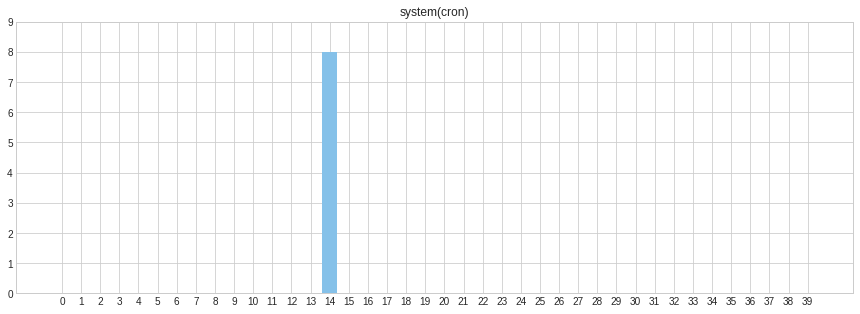

1.2489995996796797


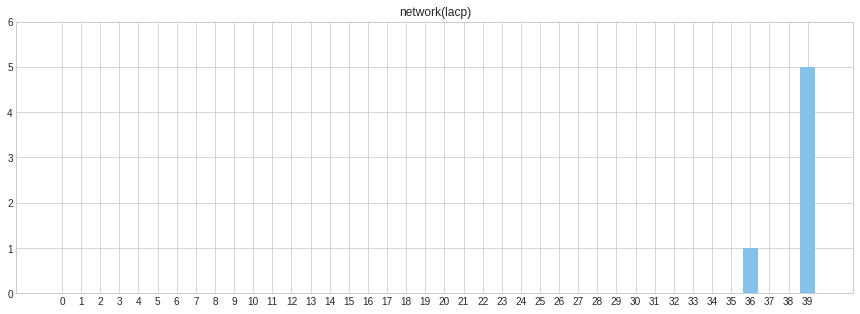

0.7921489758877429


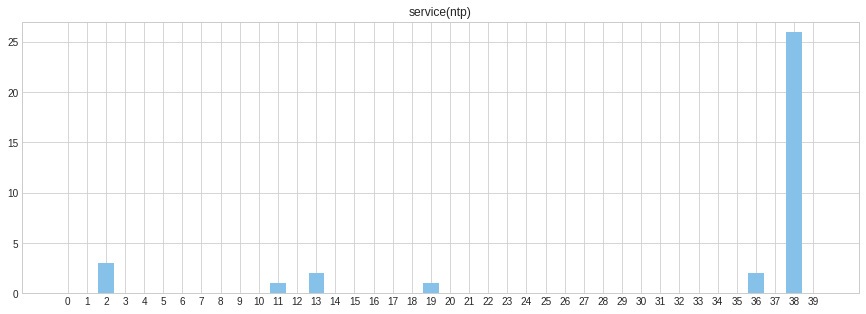

4.075460096725276


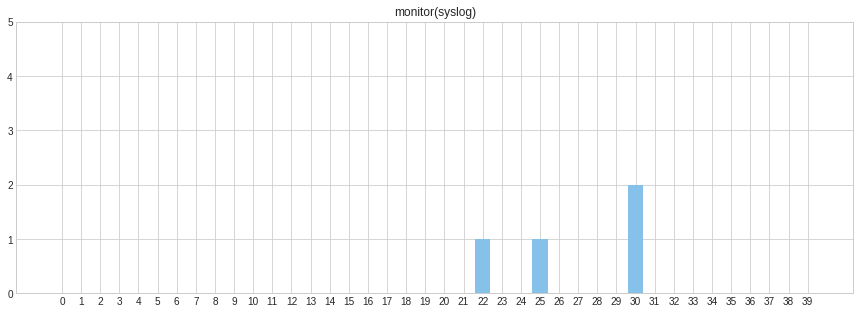

0.37416573867739406


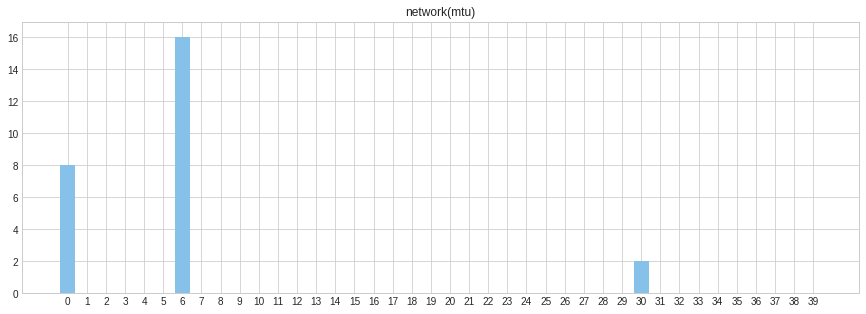

2.770830200499482


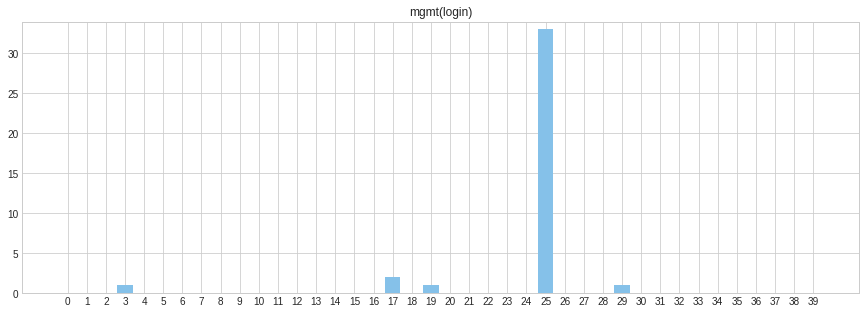

5.1475722433007185


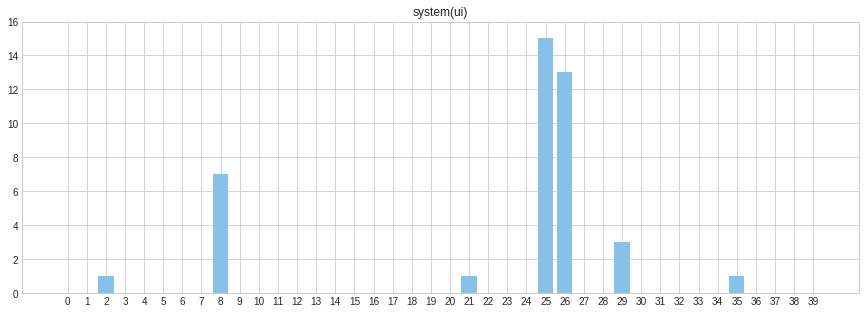

3.213156547695739


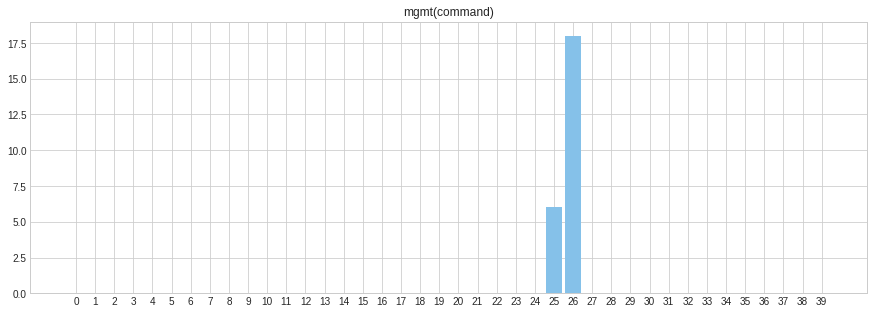

2.9393876913398134


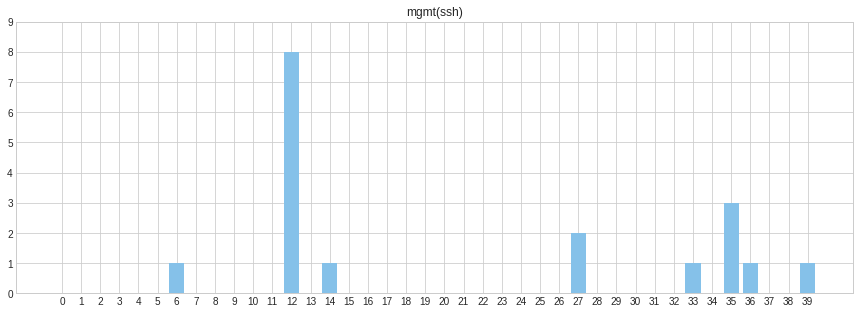

1.3592277219068187


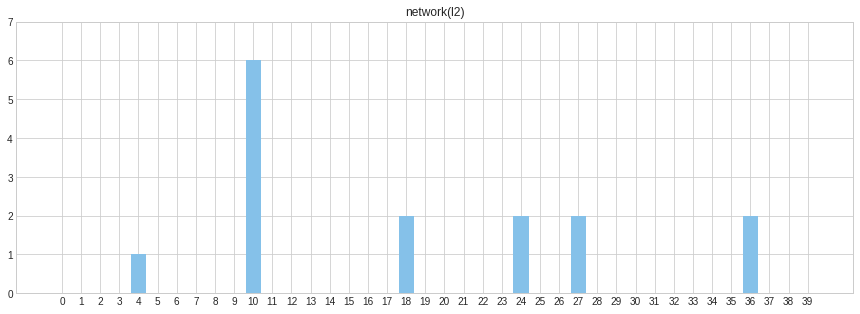

1.0882899429839459


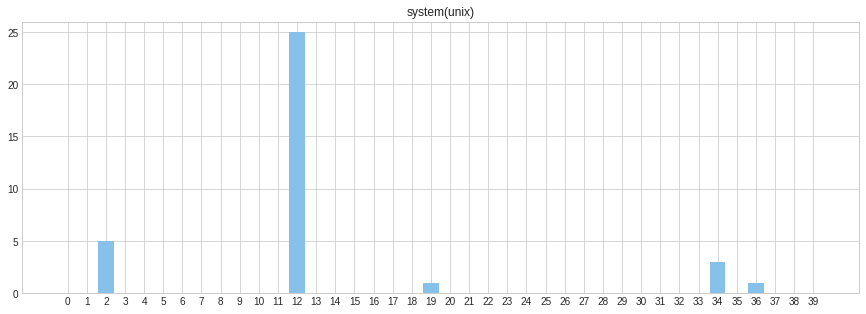

3.9698079298626023


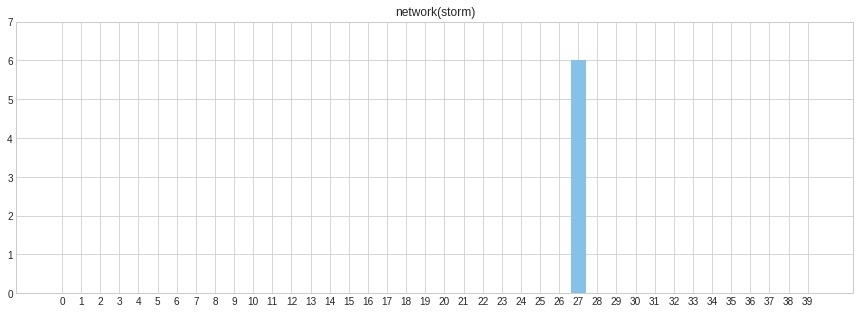

0.9367496997597597


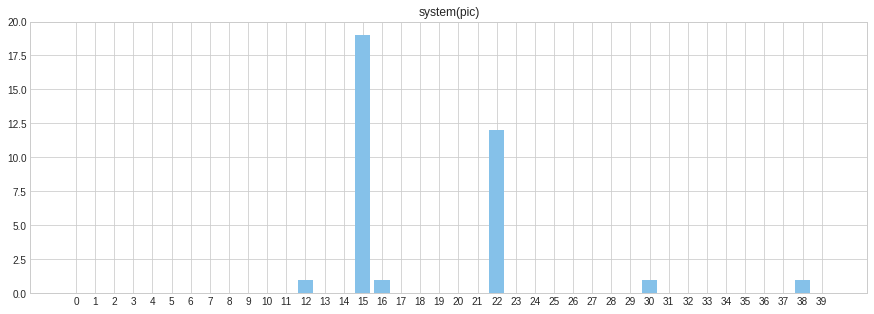

3.458232930269446


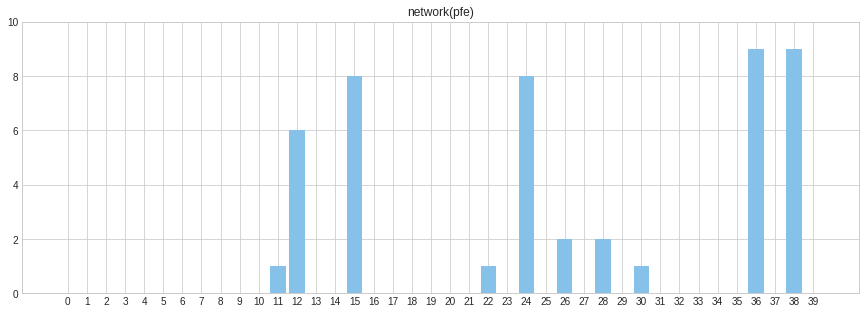

2.6541241493193195


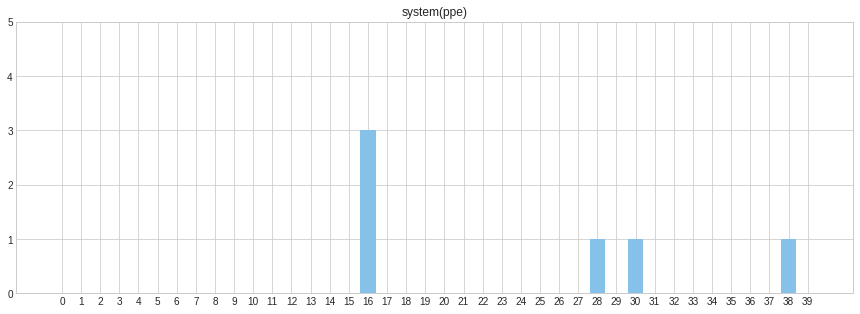

0.5267826876426369


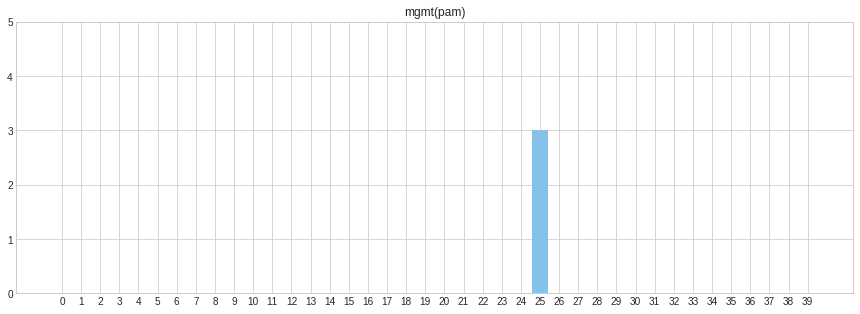

0.4683748498798799


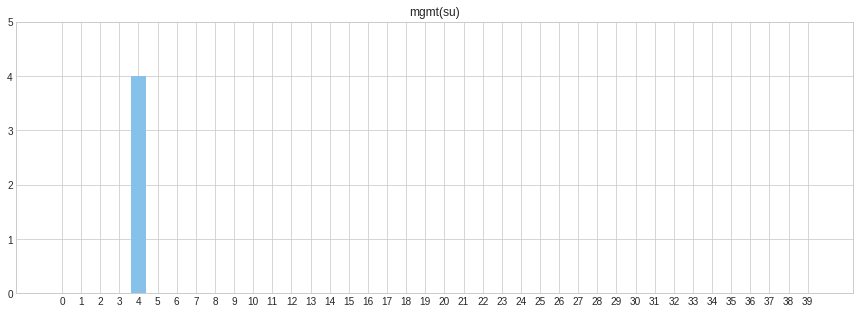

0.6244997998398398


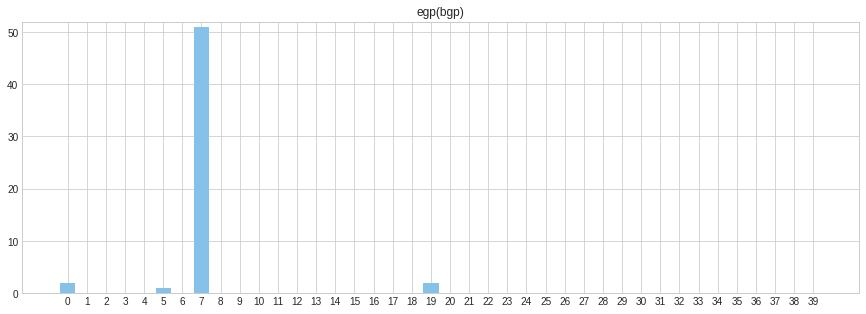

7.9555012412795225


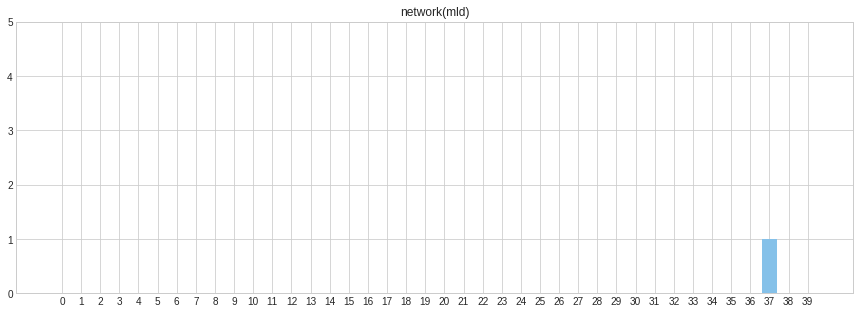

0.15612494995995996


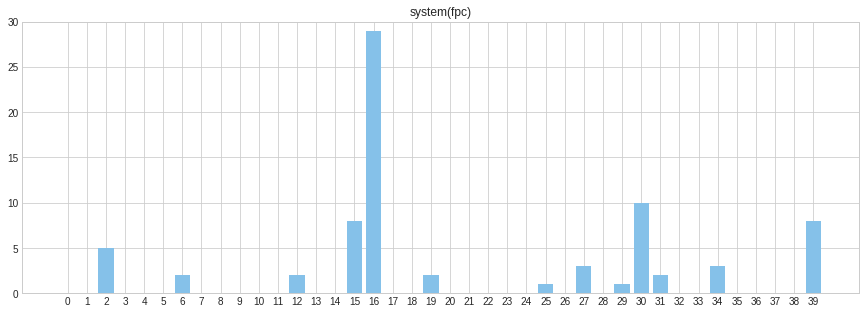

4.963869458396343


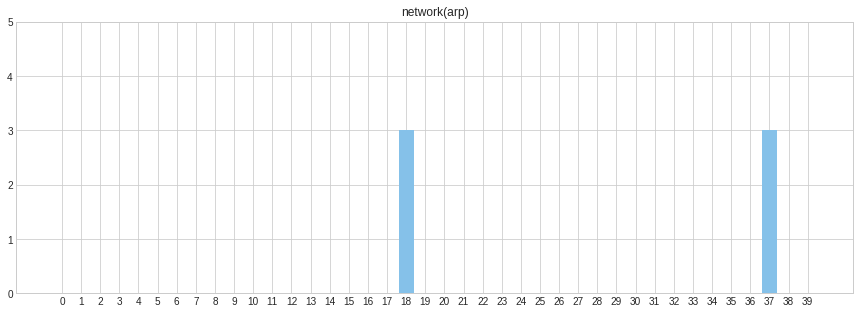

0.653834841531101


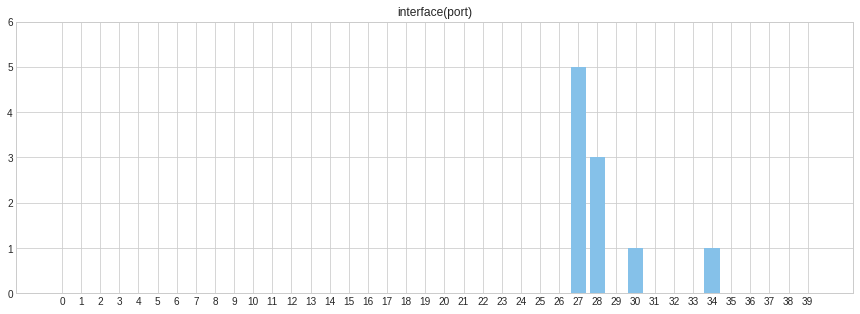

0.9151502608861564


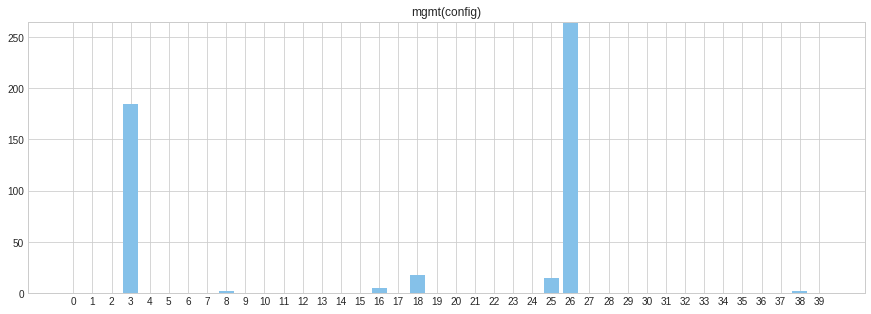

49.617530924059494


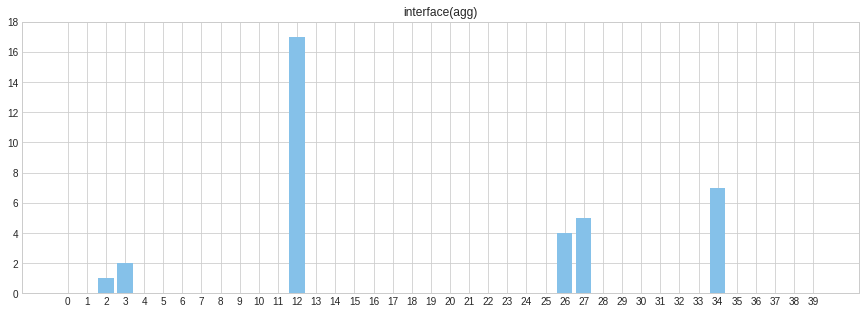

2.9647934160747194


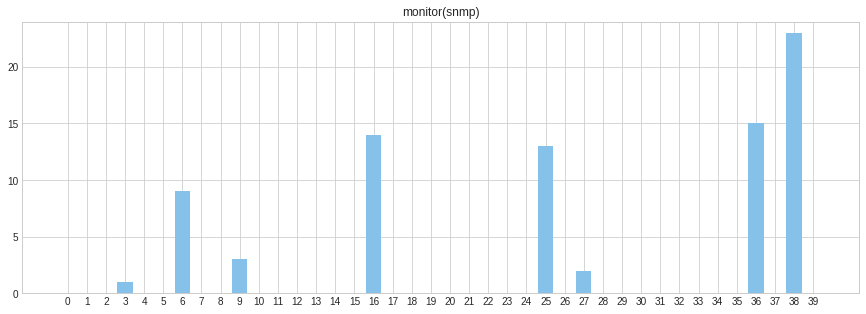

5.13322510708424


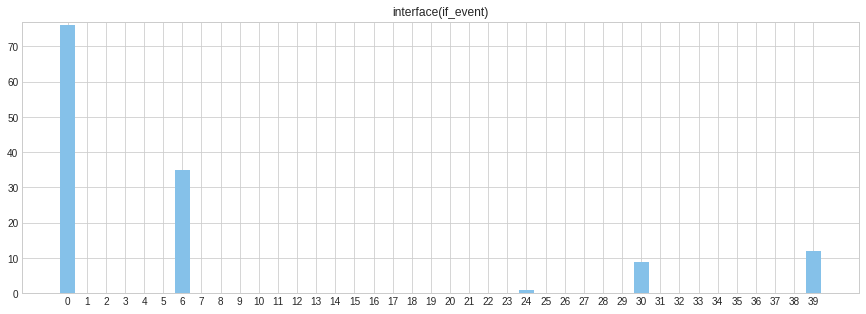

13.02380032862912


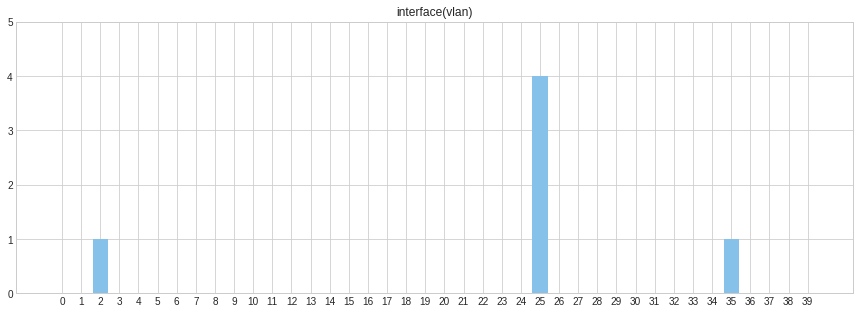

0.653834841531101


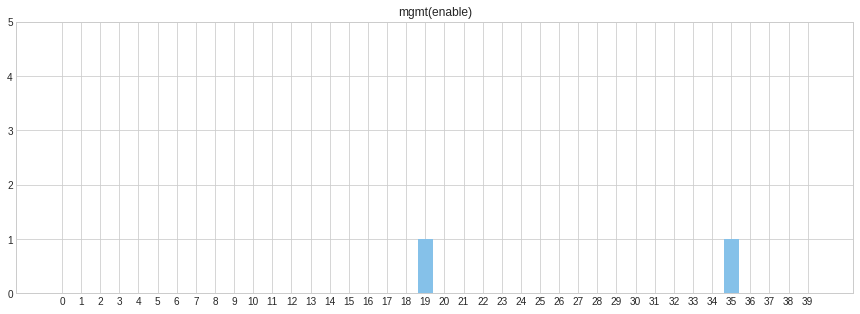

0.21794494717703367


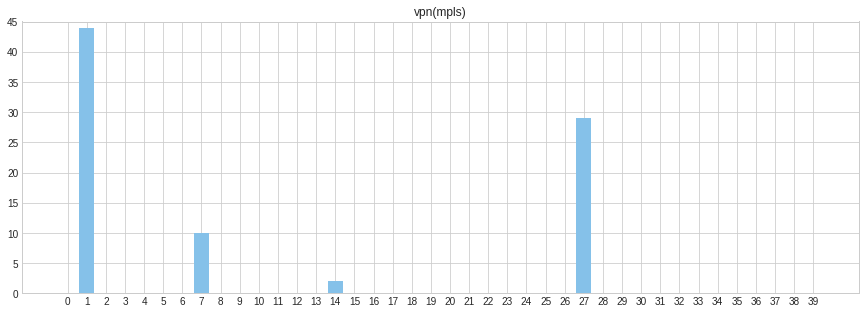

8.216408887099035


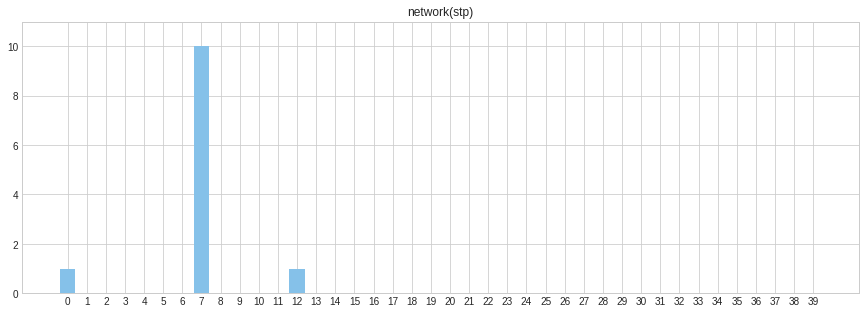

1.5684387141358123


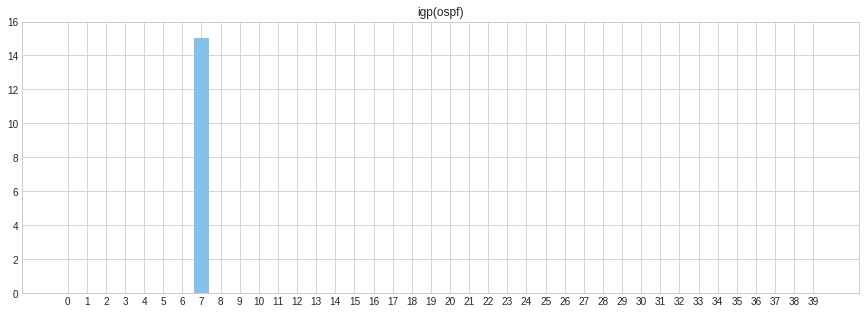

2.341874249399399


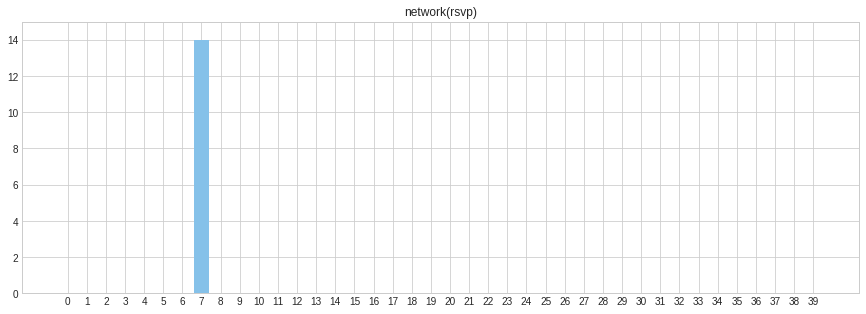

2.1857492994394394


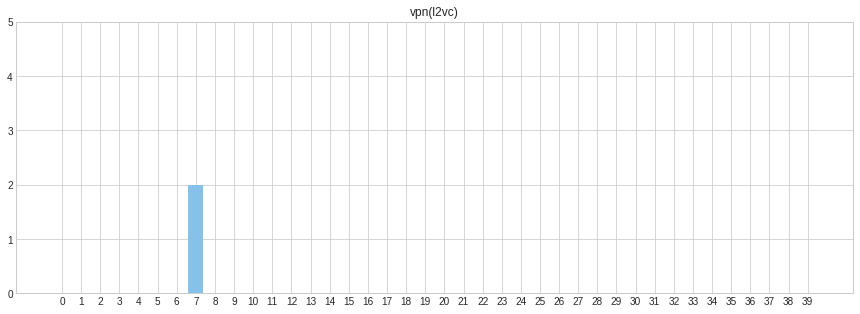

0.3122498999199199


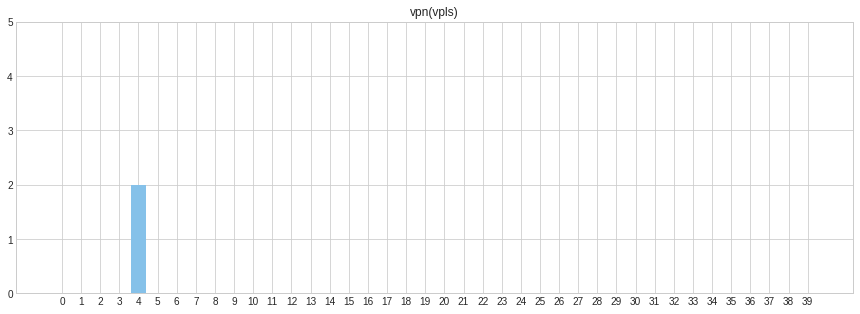

0.3122498999199199


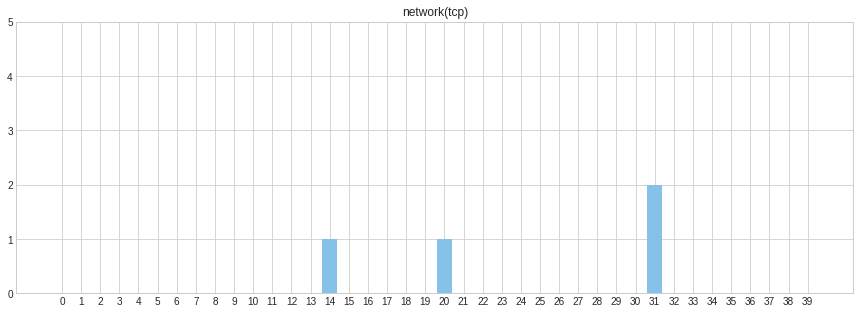

0.37416573867739417


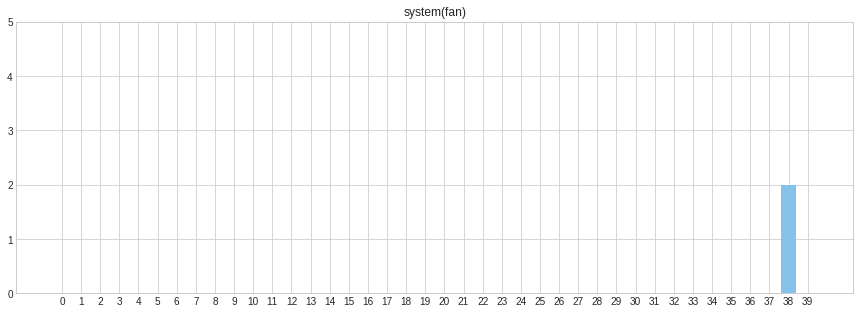

0.3122498999199199


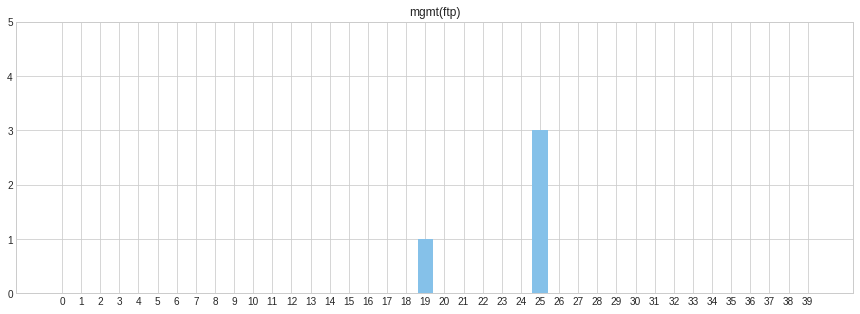

0.4898979485566356


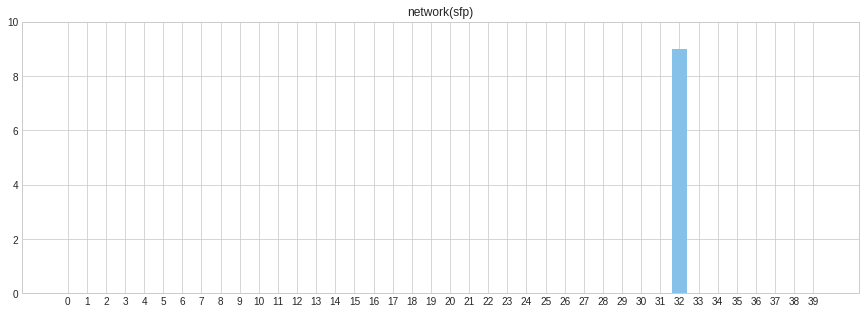

1.4051245496396396


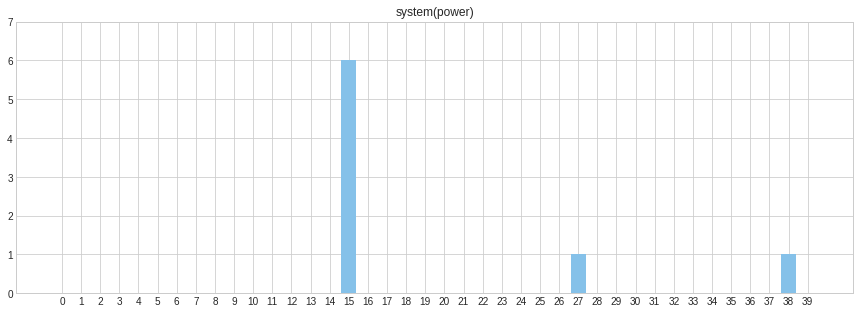

0.9539392014169455


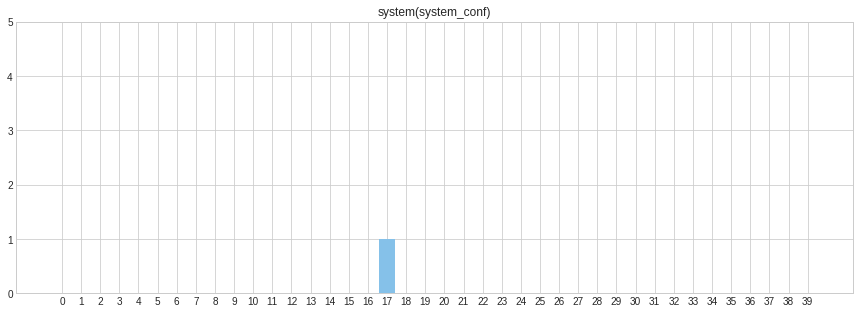

0.15612494995995996


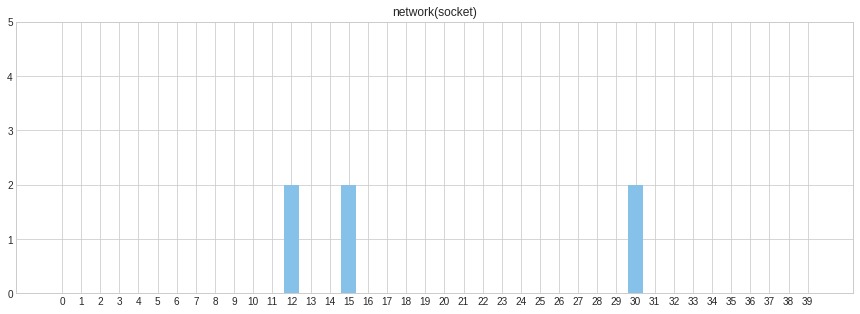

0.5267826876426369


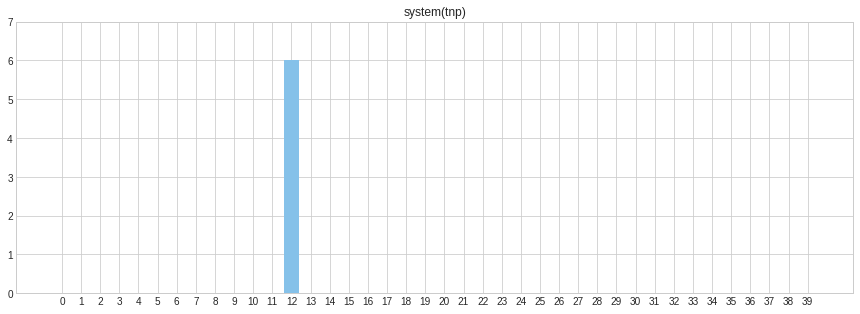

0.9367496997597597


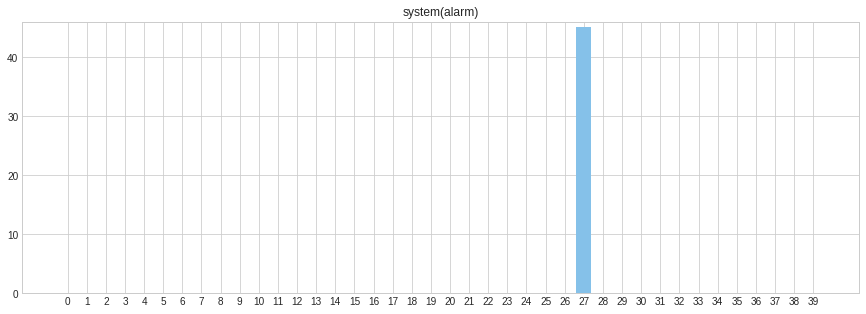

7.025622748198198


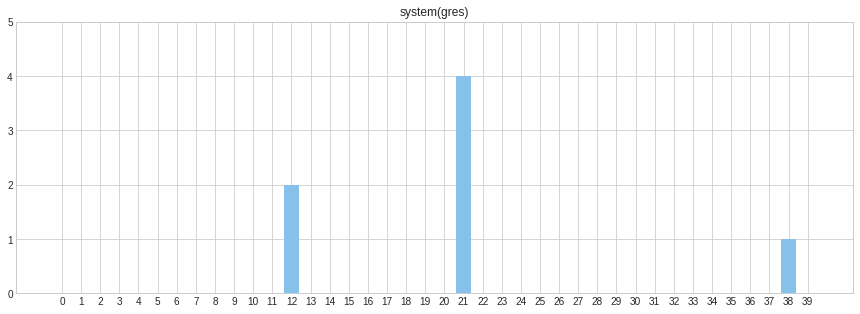

0.7031180555212617


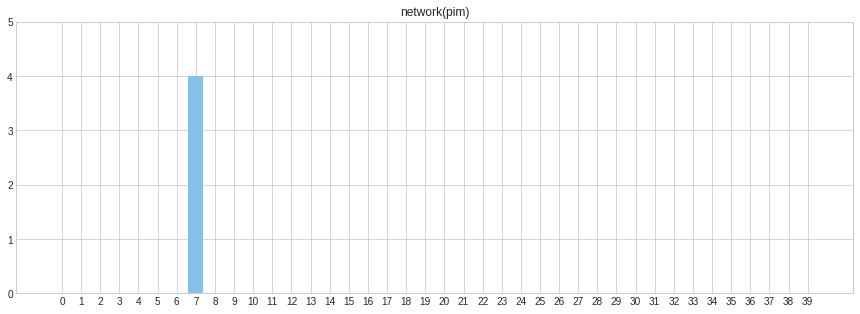

0.6244997998398398


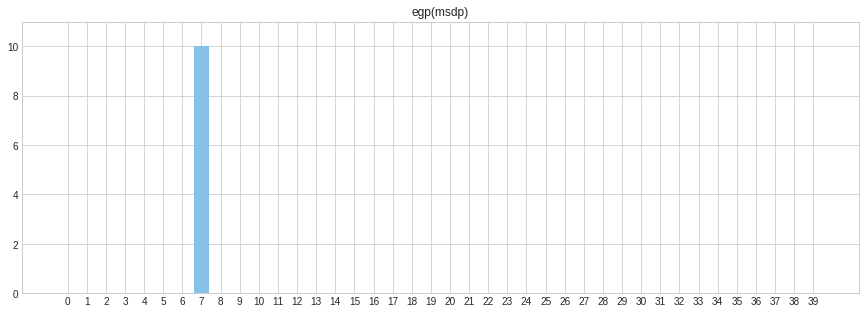

1.5612494995995996


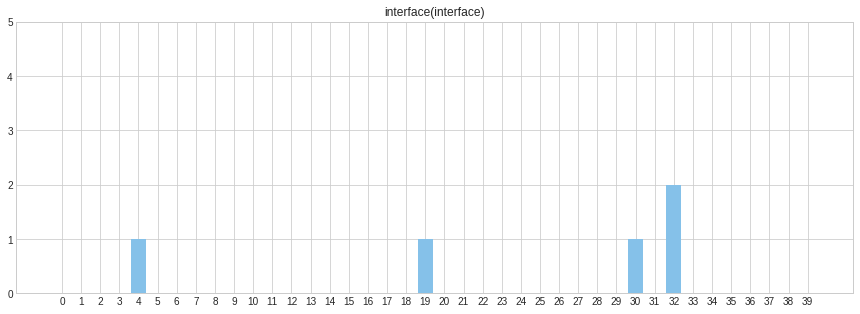

0.3992179855667828


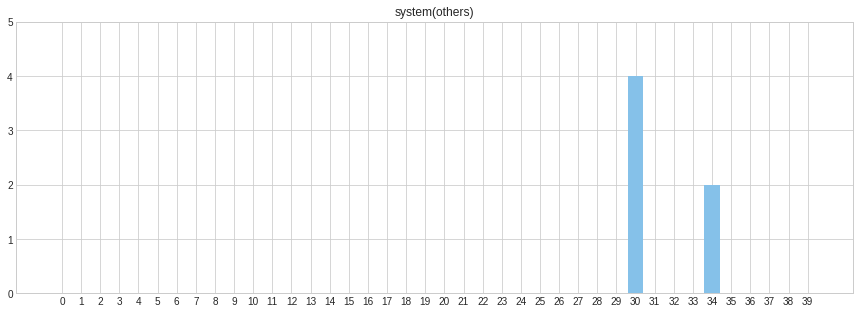

0.6910137480542627


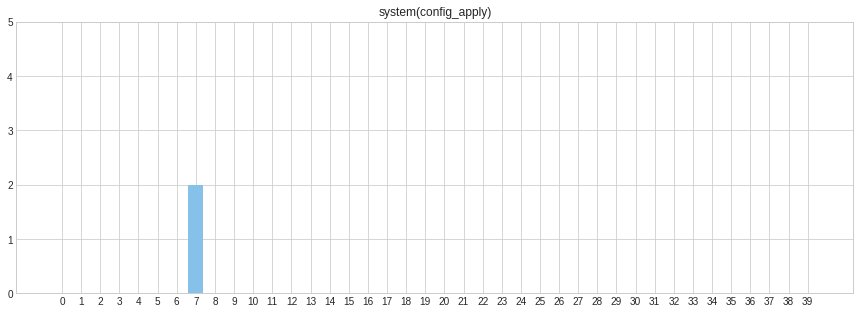

0.3122498999199199


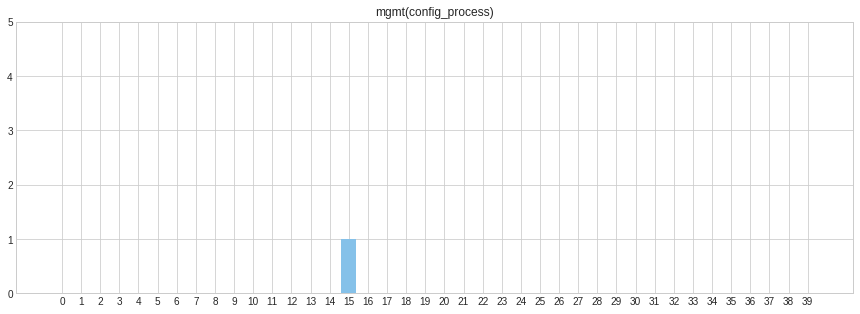

0.15612494995995996


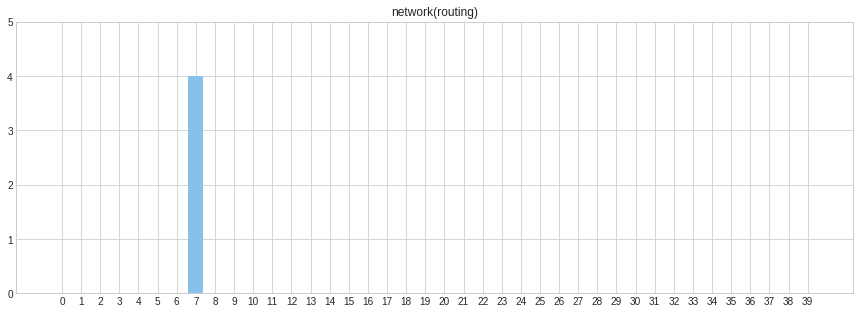

0.6244997998398398


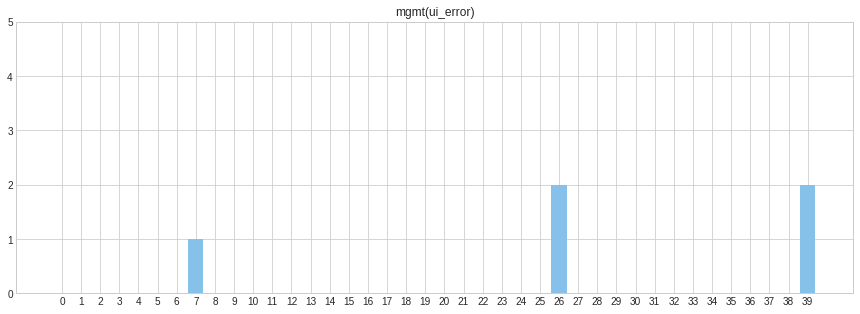

0.4575751304430782


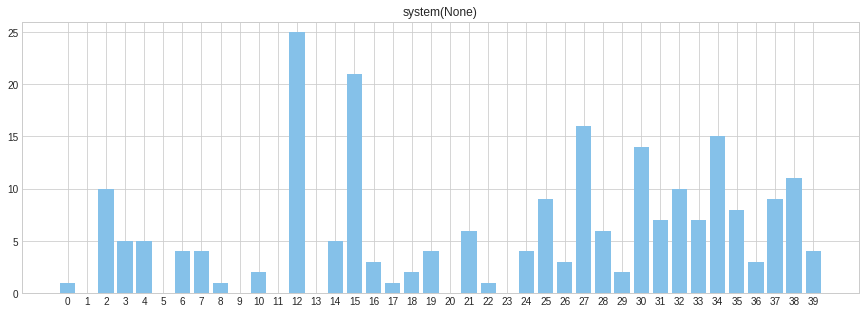

5.8275209137333865


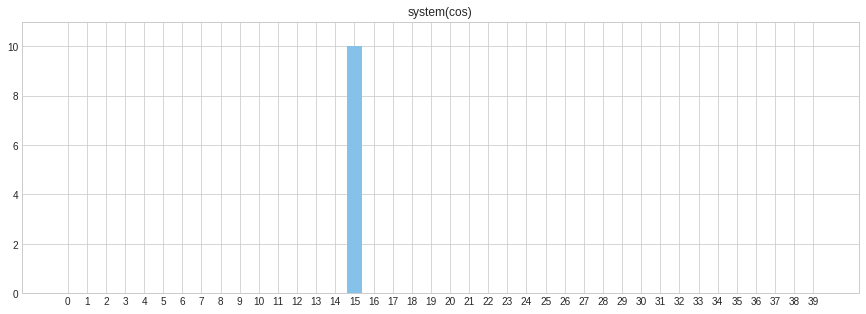

1.5612494995995996


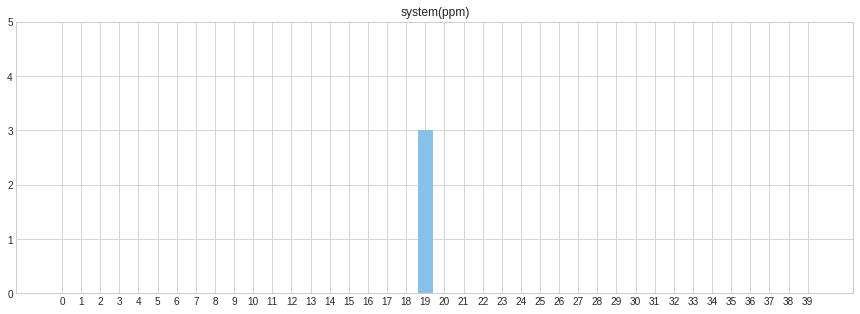

0.4683748498798799


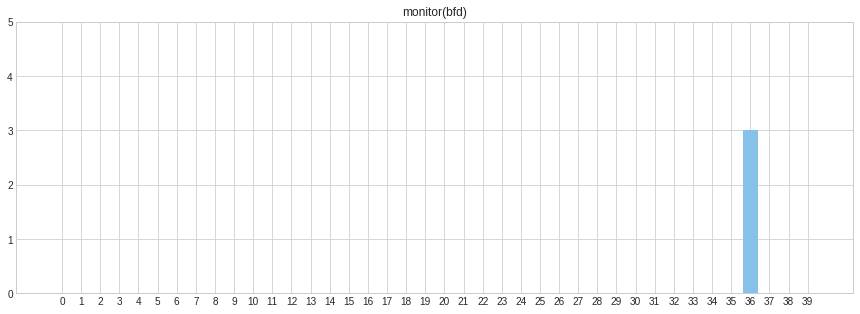

0.4683748498798799


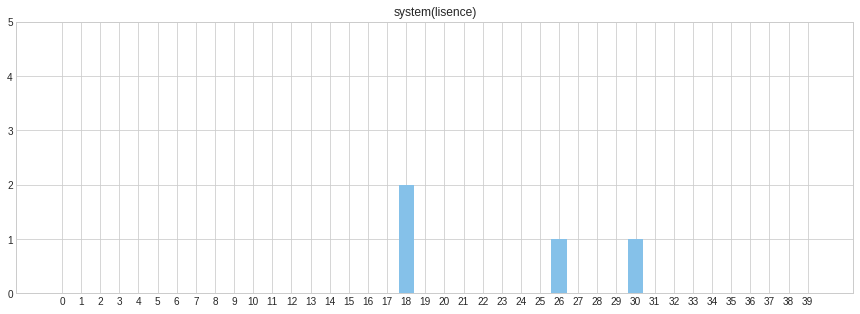

0.37416573867739406


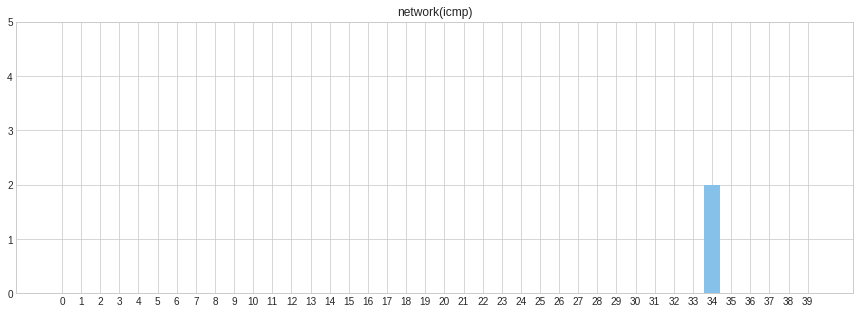

0.3122498999199199


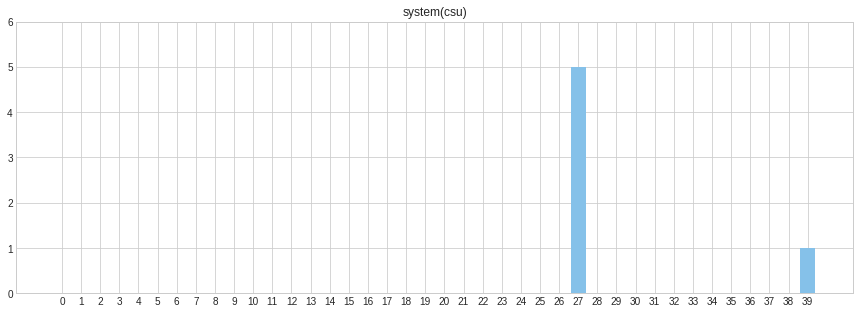

0.7921489758877429


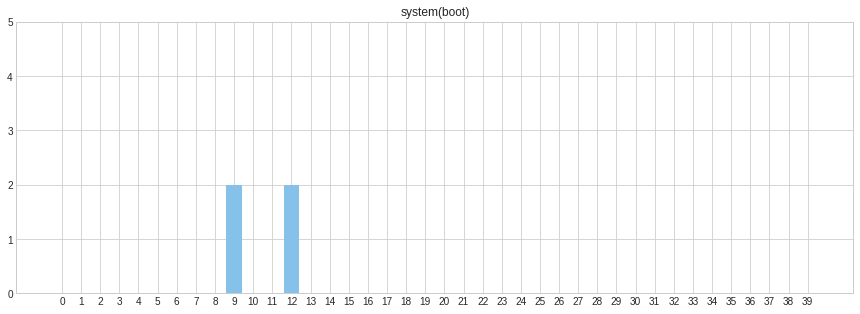

0.4358898943540673


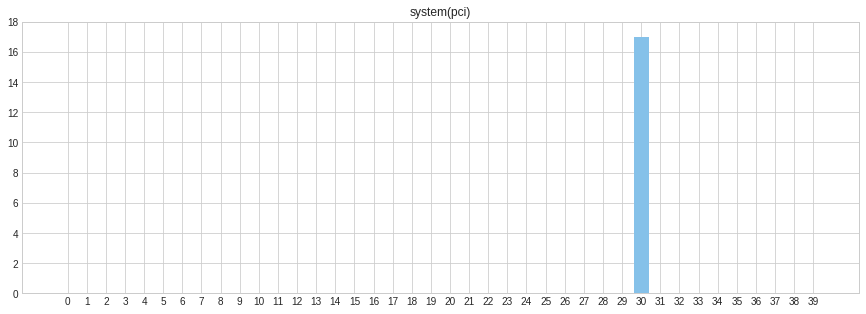

2.654124149319319


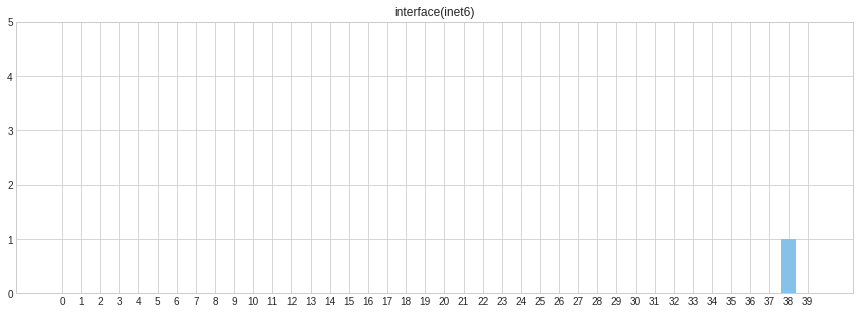

0.15612494995995996


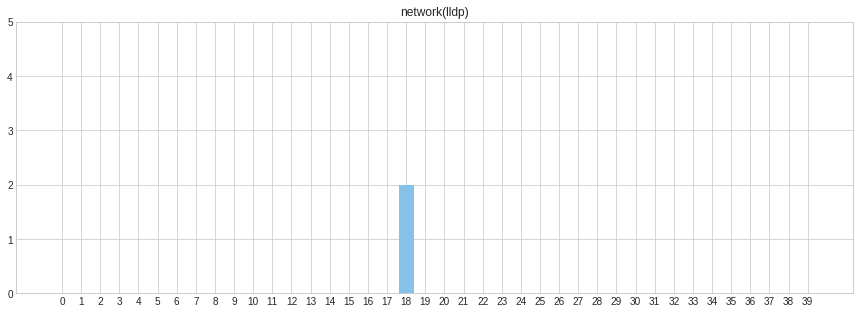

0.3122498999199199


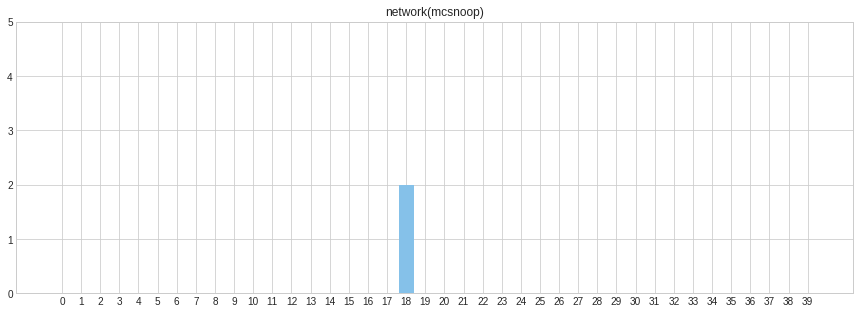

0.3122498999199199


In [21]:
## plot per category graphs
## x-axis: infered topic
## y-axis: cnt

plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
cvs = []

for cat, res in inf_per_cat.items():
    plt.figure(figsize=(15, 5))
    plt.title(cat)
    y = collections.Counter(res)
    y = [y[i] if i in y else 0 for i in range(40)]
    plt.bar(np.arange(40), y, color="#85C1E9")
    plt.xticks(np.arange(40))
    minY = 5 if max(y) < 5 else max(y)+1
    plt.ylim(0, minY)
    plt.show()

    print(np.array(y).std())
    cvs.append((cat, np.array(y).std()/np.array(y).mean()))

In [26]:
## 推定トピック別のLT

lt_per_inf_topic = {}
for i in range(40):
    lt_per_inf_topic[i] = []
    
for ltid, data in raw_lt.items():
    lt = data['lt']
        
    c = list(collections.Counter([word2id[w] for w in string_to_corpus(lt, max_len=10)]).items())
    topic_dist, word_topic, word_topic_dist = lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append(lt)
    
    
for split_words in uniq_corpus:

    lt_word_id_cnt = collections.Counter([word2id[w] for w in split_words])
    c = [(tid, cnt) for tid, cnt in lt_word_id_cnt.items()]    
    c = [cc for cc in c if id2word[cc[0]] not in stop_words]
    
    topic_dist, word_topic, word_topic_dist = lda[c]
    inf_topic = np.argmax(np.array([t[1] for t in topic_dist]))
    
    lt_per_inf_topic[inf_topic].append(" ".join(split_words))
    
for inf_topic, lts in lt_per_inf_topic.items():
    print(inf_topic, inf_topic_words[inf_topic])
    
    for lt in lts:
        print("\t", lt)
    print()

0 ['event', 'neighbor', 'mcsn', 'updown', 'connect', 'pointtopoint', 'than', 's', 'packetdd', 'exchange']
	 rpd[**]: EVENT <MTU> ** index ** <Up Broadcast PointToPoint Multicast> address #** **
	 rpd[**]: EVENT Delete UpDown ** index ** ** -> ** <Broadcast Multicast Localup>
	 rpd[**]: EVENT <Delete UpDown> ** index ** <Broadcast Multicast> address #** **
	 rpd[**]: EVENT Add ** index ** ** -> ** <Up Broadcast Multicast Localup>
	 **: rpd[**]: EVENT <UpDown> index ** <Broadcast Multicast> address #** **
	 **: rpd[**]: EVENT <UpDown> ** index ** <Broadcast Multicast> address #** **
	 **: rpd[**]: EVENT UpDown ** index ** ** -> ** <Broadcast Multicast Localup>
	 **: rpd[**]: EVENT UpDown ** index ** <Broadcast Multicast Localup>
	 rpd[**]: EVENT <UpDown> ** index ** <Broadcast Multicast> address #** **
	 rpd[**]: EVENT UpDown ** index ** ** -> ** <Broadcast Multicast Localup>
	 mcsn[**]: EVENT <UpDown> index ** <Broadcast Multicast> address #** **
	 mcsn[**]: STP **
	 rpd[**]: EVENT <UpD

	 ripng update routes to neighbor
	 proto table
	 getmsgctl returned t error ack
	 static uninstall ipv6 no stable
	 static add ipv6 unable to allocate policy table
	 static uninstall ipv4 no stable
	 ripng recvfrom failed protocol driver not attached.
	 static add ipv6 allocating policy table
	 route add needless update
	 router solicitation recv failed protocol wrong type for socket.
	 asbrstatus already non asbr
	 getmsgdata returned
	 ripng update routes on interface
	 auth data len
	 getmsgctl failed
	 sent invalid length
	 static install ipv6 no stable
	 ls checksum 0x
	 network cant create ospf6 socket.
	 malformed as path from
	 asn ipaddress
	 asn octet str
	 asn counter
	 routeridnew update
	 wrong lsa checksum discard
	 failed to convert returned value to integer
	 refcnt uptime type table
	 ripng recvfrom failed wrong medium type.
	 cant bind ripng socket wrong medium type.
	 asn integer
	 called with null lsdb
	 static add ipv4 unable to allocate policy table
	 routeridold

	 ospf mpls te lsa schedule unknown opcode
	 ripv2 unknown authentication type
	 wtf!
	 ripv2 md5 authentication from
	 family 0x%x type auth string
	 ripv2 authentication failure
	 ripv2 authentication failed no auth rte in packet
	 ripd restarting!
	 simple password
	 bgpd daemon failed
	 turn off
	 mplste on off
	 wrongsystemtype
	 ripv2 md5 authentication strange authentication length field
	 only one of two lsas compared is headeronly
	 drelection2nd dr
	 nssahellorecvpacket from
	 inactive
	 ospf mpls te ism change cannot get linkparams from oi?
	 route add replacing previous best
	 ripv2 md5 authentication packet length field greater than received length !
	 zclient connection fail
	 drelection1st backup
	 ospf mpls te ism change cannot refer to ospf from oi?
	 ripv1 mask check / considered for output
	 ospf mpls te lsa refresh ospf mpls te lsa new ?

28 ['packet', 'received', 'port', 'down', 'flags', 'host', 'netlink', 'rip', 'filtered', 'limit']
	 [**]: EVT ** ** ** PORT ** **

In [27]:
with open('20180919_result.txt', 'w') as f:
    for inf_topic, lts in lt_per_inf_topic.items():
        f.write(str(inf_topic))
        f.write("[" + " ".join(inf_topic_words[inf_topic]) + "]" )
        f.write("\n")

        for lt in lts:
            f.write("\t" + lt)
            f.write("\n")
        f.write("\n")